In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Using device: cuda
Loading dataset...
Dataset loaded in 40.48s
Train samples: 50000, Test samples: 10000
ViT WITH FIXED QAT IMPLEMENTATION
Model parameters: 4,019,466
Starting training...
Epoch [10/250], Loss: 1.4405, Acc: 58.05%, Best: 58.05%
Epoch [20/250], Loss: 1.2095, Acc: 68.43%, Best: 68.43%
Epoch [30/250], Loss: 1.0253, Acc: 75.67%, Best: 75.67%
Epoch [40/250], Loss: 0.9162, Acc: 77.94%, Best: 78.04%
Epoch [50/250], Loss: 0.8357, Acc: 78.56%, Best: 79.84%
Epoch [60/250], Loss: 0.7785, Acc: 80.04%, Best: 81.00%
Epoch [70/250], Loss: 0.7258, Acc: 80.46%, Best: 81.43%
Epoch [80/250], Loss: 0.6852, Acc: 79.75%, Best: 81.53%
Epoch [90/250], Loss: 0.6500, Acc: 80.36%, Best: 81.53%
Epoch [100/250], Loss: 0.6230, Acc: 80.83%, Best: 81.53%
Epoch [110/250], Loss: 0.6027, Acc: 80.89%, Best: 81.53%
Epoch [120/250], Loss: 0.5826, Acc: 81.54%, Best: 81.81%
Epoch [130/250], Loss: 0.5722, Acc: 81.90%, Best: 81.90%
Epoch [140/250], Loss: 0.5574, Acc: 81.80%, Best: 81.95%
Epoch [150/250], Loss: 

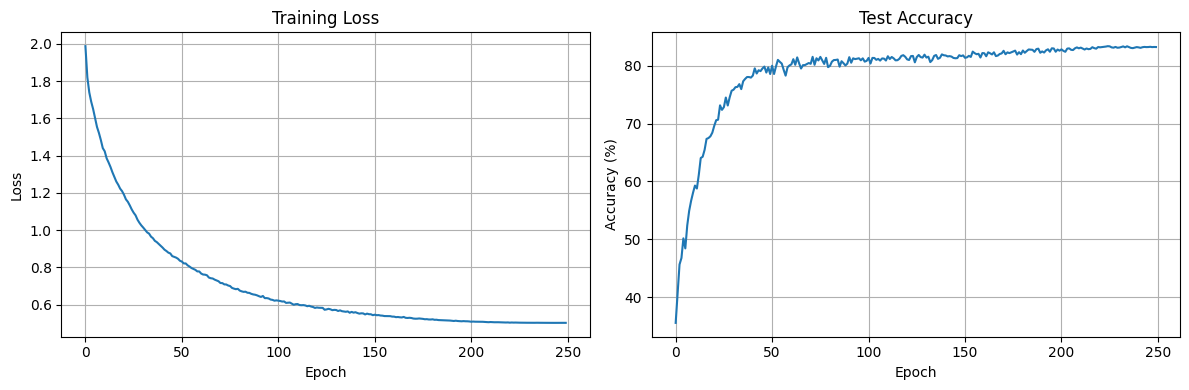


Applying QAT (Accuracy: 83.37% > 70%)
Preparing model for QAT...
Starting QAT fine-tuning...
QAT Epoch [1/10], Loss: 0.0832
QAT Epoch [2/10], Loss: 0.0556
QAT Epoch [3/10], Loss: 0.0432
QAT Epoch [4/10], Loss: 0.0335
QAT Epoch [5/10], Loss: 0.0298
QAT Epoch [6/10], Loss: 0.0298
QAT Epoch [7/10], Loss: 0.0212
QAT Epoch [8/10], Loss: 0.0265
QAT Epoch [9/10], Loss: 0.0227
QAT Epoch [10/10], Loss: 0.0191
Converting to quantized model...


RuntimeError: getCudnnDataTypeFromScalarType() not supported for QUInt8

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch.quantization
from torch.quantization import QuantStub, DeQuantStub, prepare_qat, convert
import matplotlib.pyplot as plt
import math
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR
import time
from torch.cuda.amp import autocast, GradScaler
import warnings
warnings.filterwarnings('ignore')

# Configuration for optimal performance
class Config:
    # Hardware settings
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Model architecture (optimized for speed and accuracy)
    img_size = 64
    patch_size = 8
    embed_dim = 256
    depth = 6
    num_heads = 8
    mlp_ratio = 3.0
    
    # Training settings
    batch_size = 128
    num_epochs = 250
    initial_lr = 0.001
    weight_decay = 0.05
    
    # QAT settings - FIXED CONFIG
    qat_epochs = 10
    qat_lr = 1e-4
    
    # Data settings
    num_workers = 4
    pin_memory = True

config = Config()
print(f"Using device: {config.device}")

# Data paths
base_path = "/kaggle/input/cifar10-64x64-resized-via-cai-super-resolution/cifar10-32"

# Data augmentation
train_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(config.img_size, padding=4, padding_mode='reflect'),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

test_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

def create_dataframe(split):
    """Create DataFrame with image paths and labels"""
    data = []
    split_path = os.path.join(base_path, split)
    
    for class_name in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                data.append([img_path, class_name])
    
    return pd.DataFrame(data, columns=["image_path", "label"])

print("Loading dataset...")
start_time = time.time()

train_df = create_dataframe("train")
test_df = create_dataframe("test")

# Encode labels
le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
test_df["label"] = le.transform(test_df["label"])

print(f"Dataset loaded in {time.time() - start_time:.2f}s")
print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

class CIFARDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_paths = df["image_path"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB")
            label = self.labels[idx]
            
            if self.transform:
                image = self.transform(image)
                
            return image, label
        except:
            # Return black image for corrupted files
            image = torch.zeros(3, config.img_size, config.img_size)
            label = self.labels[idx]
            return image, label

# Create datasets
train_dataset = CIFARDataset(train_df, transform=train_transform)
test_dataset = CIFARDataset(test_df, transform=test_transform)

train_loader = DataLoader(
    train_dataset, 
    batch_size=config.batch_size, 
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=config.batch_size, 
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory
)

# FIXED ViT MODEL FOR QAT
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)l
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, drop=0.1):
        super().__init__()
        hidden_features = hidden_features or int(in_features * config.mlp_ratio)
        
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadAttention(dim, num_heads, drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, hidden_features=int(dim * mlp_ratio), drop=drop)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class OptimizedViT(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=3.0, dropout=0.1):
        super().__init__()
        
        # Quantization stubs - MUST BE AT BEGINNING/END
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        
        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = (img_size // patch_size) ** 2
        
        # Position embeddings
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        self.apply(self._init_weights)
        
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.trunc_normal_(m.weight, std=0.02)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Quantize input
        x = self.quant(x)
        
        # Patch embedding
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.head(x)
        
        # Dequantize output
        x = self.dequant(x)
        return x

def train_model(model, train_loader, test_loader, config):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.initial_lr, weight_decay=config.weight_decay)
    scheduler = CosineAnnealingLR(optimizer, T_max=config.num_epochs)
    
    scaler = GradScaler()
    best_acc = 0.0
    train_losses, test_accs = [], []
    
    print("Starting training...")
    
    for epoch in range(config.num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(config.device), labels.to(config.device)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(config.device), labels.to(config.device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_acc = 100. * correct / total
        avg_loss = train_loss / len(train_loader)
        
        train_losses.append(avg_loss)
        test_accs.append(test_acc)
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'model_state_dict': model.state_dict(),
                'accuracy': test_acc,
                'epoch': epoch
            }, 'best_model.pth')
        
        scheduler.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{config.num_epochs}], Loss: {avg_loss:.4f}, Acc: {test_acc:.2f}%, Best: {best_acc:.2f}%')
    
    print(f'Best Accuracy: {best_acc:.2f}%')
    return train_losses, test_accs, best_acc

# FIXED QAT FUNCTION
def prepare_model_for_qat(model):
    """Prepare model for QAT with proper configuration"""
    model.train()
    
    # FIXED: Use per_tensor quantization instead of per_channel
    model.qconfig = torch.quantization.QConfig(
        activation=torch.quantization.MinMaxObserver.with_args(dtype=torch.quint8),
        weight=torch.quantization.MinMaxObserver.with_args(dtype=torch.qint8)
    )
    
    # Prepare for QAT
    model_prepared = prepare_qat(model, inplace=False)
    return model_prepared

def apply_qat(model, train_loader, config):
    """Apply Quantization-Aware Training"""
    print("Preparing model for QAT...")
    
    # Prepare model
    model_qat = prepare_model_for_qat(model)
    model_qat = model_qat.to(config.device)
    
    # QAT training
    optimizer = torch.optim.Adam(model_qat.parameters(), lr=config.qat_lr)
    criterion = nn.CrossEntropyLoss()
    
    print("Starting QAT fine-tuning...")
    
    for epoch in range(config.qat_epochs):
        model_qat.train()
        running_loss = 0.0
        
        for i, (images, labels) in enumerate(train_loader):
            if i > 20:  # Use only 20 batches for speed
                break
                
            images, labels = images.to(config.device), labels.to(config.device)
            
            optimizer.zero_grad()
            outputs = model_qat(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f'QAT Epoch [{epoch+1}/{config.qat_epochs}], Loss: {running_loss/20:.4f}')
    
    # Convert to quantized model
    print("Converting to quantized model...")
    model_qat.eval()
    model_quantized = convert(model_qat, inplace=False)
    
    return model_quantized

# Main execution
if __name__ == "__main__":
    print("="*50)
    print("ViT WITH FIXED QAT IMPLEMENTATION")
    print("="*50)
    
    # Create and train model
    model = OptimizedViT(
        img_size=config.img_size,
        patch_size=config.patch_size,
        embed_dim=config.embed_dim,
        depth=config.depth,
        num_heads=config.num_heads,
        mlp_ratio=config.mlp_ratio,
        num_classes=len(le.classes_)
    ).to(config.device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")
    
    # Train the model
    train_losses, test_accs, best_acc = train_model(model, train_loader, test_loader, config)
    
    # Plot results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(test_accs)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('training_results.png')
    plt.show()
    
    # Apply QAT if accuracy is good
    if best_acc > 70.0:
        print(f"\nApplying QAT (Accuracy: {best_acc:.2f}% > 70%)")
        
        # Load best model
        checkpoint = torch.load('best_model.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Apply QAT
        quantized_model = apply_qat(model, train_loader, config)
        
        # Test quantized model
        quantized_model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(config.device), labels.to(config.device)
                outputs = quantized_model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        qat_acc = 100. * correct / total
        
        # Save quantized model
        torch.save(quantized_model.state_dict(), 'quantized_model.pth')
        
        # Model size comparison
        original_size = sum(p.numel() * 4 for p in model.parameters()) / 1024 / 1024
        quantized_size = sum(p.numel() * p.element_size() for p in quantized_model.parameters()) / 1024 / 1024
        
        print(f"\n=== QAT RESULTS ===")
        print(f"Original accuracy: {best_acc:.2f}%")
        print(f"Quantized accuracy: {qat_acc:.2f}%")
        print(f"Accuracy drop: {best_acc - qat_acc:.2f}%")
        print(f"Original size: {original_size:.2f} MB")
        print(f"Quantized size: {quantized_size:.2f} MB")
        print(f"Size reduction: {(1 - quantized_size/original_size)*100:.1f}%")
        
    else:
        print(f"\nSkipping QAT (Accuracy: {best_acc:.2f}% <= 70%)")
    
    print("\nTraining completed successfully!")

In [ ]:
# quant_export.py
import os, json, math
import torch, numpy as np
from torchvision import transforms, datasets
from PIL import Image

# ---- CONFIG ----
MODEL_CHECKPOINT = "best_model.pth"  
OUT_DIR = "export_mem"
NUM_BITS = 8  # target bits for weights (int8)
ACT_BITS = 8  # activations int8
CALIBRATION_SAMPLES = 128  # for activation calibration if doing PTQ
DEVICE = torch.device("cpu")  # we'll run quantized model on CPU
# -----------------

os.makedirs(OUT_DIR, exist_ok=True)

def write_hex_mem(filename, arr, signed=True, width_bytes=1):
    """
    arr: 1D numpy array of ints (signed expected if signed=True).
    width_bytes: 1 for int8, 4 for int32 bias, etc.
    Writes hex per-line (little-endian not necessary for readmemh).
    """
    with open(filename, "w") as f:
        for v in arr.flatten():
            if signed:
                # produce two's complement unsigned representation
                bits = width_bytes * 8
                u = int(v) & ((1 << bits) - 1)
            else:
                u = int(v)
            f.write(f"{u:0{width_bytes*2}x}\n")

def quantize_np_symmetric(tensor_np, num_bits=8):
    """Symmetric per-tensor quantization: returns int np array and scale"""
    max_abs = float(np.max(np.abs(tensor_np))) if tensor_np.size else 0.0
    if max_abs == 0:
        scale = 1.0
    else:
        qmax = 2**(num_bits-1) - 1
        scale = max_abs / qmax
    q = np.round(tensor_np / scale).astype(np.int32)
    qmin = -2**(num_bits-1)
    qmax = 2**(num_bits-1)-1
    q = np.clip(q, qmin, qmax).astype(np.int8 if num_bits==8 else np.int16)
    return q, float(scale)

# --- helper: load checkpoint state_dict or quantized state ---
ckpt = torch.load(MODEL_CHECKPOINT, map_location='cpu')
# ckpt may be dict with 'model_state_dict' or just state_dict
if isinstance(ckpt, dict) and 'model_state_dict' in ckpt:
    state_dict = ckpt['model_state_dict']
else:
    state_dict = ckpt

# Try to detect if this is a quantized model object (we'll later try both ways)
# We'll implement two flows: (A) if you have model object quantized_model (recommended),
# (B) if you only have state_dict (float), we quantize offline per-tensor.

print("Export folder:", OUT_DIR)

# ---------- FLOW A: If you already have a quantized model object ----------
# If you have `quantized_model` in memory (after convert()), use this block:
def export_from_quantized_model(model_quantized, out_dir=OUT_DIR):
    """
    Extracts packed quantized weights from a quantized PyTorch model (modules like
    nnq.Linear / nnq.Conv2d) and writes .mem + metadata.
    """
    meta = {}
    model_quantized.to(DEVICE)
    model_quantized.eval()
    for name, module in model_quantized.named_modules():
        # Many quantized modules expose .weight() which is a Quantized Tensor
        try:
            # handle quantized layers like torch.ao.nn.quantized.Linear/Conv2d
            if hasattr(module, 'weight') and callable(module.weight):
                qweight = module.weight()  # quantized tensor
                # int repr and scale/zero_point
                w_int = qweight.int_repr().cpu().numpy().astype(np.int8)
                scale = float(qweight.q_scale())
                zp = int(qweight.q_zero_point())
                fname = f"{name.replace('.', '_')}_weight.mem"
                write_hex_mem(os.path.join(out_dir, fname), w_int, signed=True, width_bytes=1)
                meta[name + ".weight"] = {"file": fname, "shape": list(w_int.shape), "scale": scale, "zero_point": zp, "dtype":"int8"}
            # bias could be attribute
            if hasattr(module, 'bias') and module.bias is not None:
                b = module.bias
                # bias in quantized modules might already be float or int32 depending on config
                if isinstance(b, torch.Tensor):
                    b_np = b.detach().cpu().numpy()
                    fname = f"{name.replace('.', '_')}_bias.mem"
                    # write as signed 32-bit hex
                    write_hex_mem(os.path.join(out_dir, fname), b_np.astype(np.int32), signed=True, width_bytes=4)
                    meta[name + ".bias"] = {"file": fname, "shape": list(b_np.shape), "dtype":"int32"}
        except Exception:
            # fallback: some layers expose ._weight_bias or state_dict entries; skip silently
            continue

    # Save metadata
    with open(os.path.join(out_dir, "export_meta_quant.json"), "w") as f:
        json.dump(meta, f, indent=2)
    print("Exported quantized model weights to", out_dir)
    return meta

# ---------- FLOW B: If you only have float state_dict ----------
def export_from_state_dict(state_dict, out_dir=OUT_DIR, num_bits=NUM_BITS):
    meta = {}
    for key, tensor in state_dict.items():
        arr = tensor.cpu().numpy().astype(np.float32)
        # Quantize per-tensor symmetric int8
        q_arr, scale = quantize_np_symmetric(arr, num_bits=num_bits)
        fname = f"{key.replace('.', '_')}.mem"
        write_hex_mem(os.path.join(out_dir, fname), q_arr, signed=True, width_bytes=1)
        meta[key] = {"file": fname, "shape": list(arr.shape), "scale": scale, "dtype":"int8"}
    # save meta
    with open(os.path.join(out_dir, "export_meta_ptq.json"), "w") as f:
        json.dump(meta, f, indent=2)
    print("Exported PTQ quantized weights to", out_dir)
    return meta

# ---------- Export an example input image (quantized) ----------
def export_input_image_mem(img_path=None, out_dir=OUT_DIR, act_bits=ACT_BITS, test_transform=None):
    # If no image provided, use first image from CIFAR10 test set (deterministic)
    if img_path is None:
        # load CIFAR test (will download if needed)
        ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)
        img_tensor, label = ds[0]  # first sample
        img_np = img_tensor.numpy().astype(np.float32)
    else:
        img = Image.open(img_path).convert("RGB")
        if test_transform is None:
            raise ValueError("Provide test_transform or img_path=None for CIFAR auto")
        img_tensor = test_transform(img)
        img_np = img_tensor.numpy().astype(np.float32)

    # quantize per-tensor
    q_img, s = quantize_np_symmetric(img_np, num_bits=act_bits)
    fname = "input_image.mem"
    write_hex_mem(os.path.join(out_dir, fname), q_img, signed=True, width_bytes=1)
    meta = {"file": fname, "shape": list(q_img.shape), "scale": s, "dtype":"int8"}
    with open(os.path.join(out_dir, "input_meta.json"), "w") as f:
        json.dump(meta, f, indent=2)
    print("Exported input image to", os.path.join(out_dir, fname))
    return meta

# ---------- Utility: test quantized model on CPU ----------
def test_quantized_model_on_cpu(model_quantized, test_loader):
    model_quantized.to('cpu')
    model_quantized.eval()
    correct, total = 0, 0
    for images, labels in test_loader:
        images = images.to('cpu')
        labels = labels.to('cpu')
        with torch.no_grad():
            outputs = model_quantized(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = 100.0 * correct / total
    print(f"Quantized model accuracy on CPU: {acc:.2f}%")
    return acc

# ---------------- Main decide-and-run ----------------
# If user has quantized model object in memory (quantized_model), use that:
if 'quantized_model' in globals():
    print("Detected quantized_model in memory — exporting from quantized object.")
    meta = export_from_quantized_model(globals()['quantized_model'], OUT_DIR)
    _ = export_input_image_mem(None, OUT_DIR, act_bits=ACT_BITS, test_transform=test_transform)
else:
    # If only state_dict available, export PTQ per-tensor
    print("No quantized_model in memory. Exporting from state_dict using PTQ per-tensor quantization.")
    meta = export_from_state_dict(state_dict, OUT_DIR, num_bits=NUM_BITS)
    _ = export_input_image_mem(None, OUT_DIR, act_bits=ACT_BITS, test_transform=test_transform)

print("Done. Files in:", OUT_DIR)

Using device: cuda
HYBRID ViT IMPLEMENTATION - PyTorch Training + RTL Export
Total parameters: 4,019,466
Starting PyTorch training...
  Batch [0/391], Loss: 2.3089
  Batch [100/391], Loss: 2.0584
  Batch [200/391], Loss: 1.9468
  Batch [300/391], Loss: 1.7709
Epoch [1/50] (51.3s), Loss: 1.8790, Train Acc: 29.27%, Test Acc: 35.83%, Best: 35.83%
  Batch [0/391], Loss: 1.7620
  Batch [100/391], Loss: 1.6701
  Batch [200/391], Loss: 1.7343
  Batch [300/391], Loss: 1.6130
Epoch [2/50] (47.8s), Loss: 1.6675, Train Acc: 38.51%, Test Acc: 41.09%, Best: 41.09%
  Batch [0/391], Loss: 1.6969
  Batch [100/391], Loss: 1.6913
  Batch [200/391], Loss: 1.4923
  Batch [300/391], Loss: 1.4906
Epoch [3/50] (49.0s), Loss: 1.5700, Train Acc: 42.64%, Test Acc: 44.89%, Best: 44.89%
  Batch [0/391], Loss: 1.4658
  Batch [100/391], Loss: 1.5881
  Batch [200/391], Loss: 1.7653
  Batch [300/391], Loss: 1.4999
Epoch [4/50] (48.5s), Loss: 1.5002, Train Acc: 45.04%, Test Acc: 48.02%, Best: 48.02%
  Batch [0/391], L

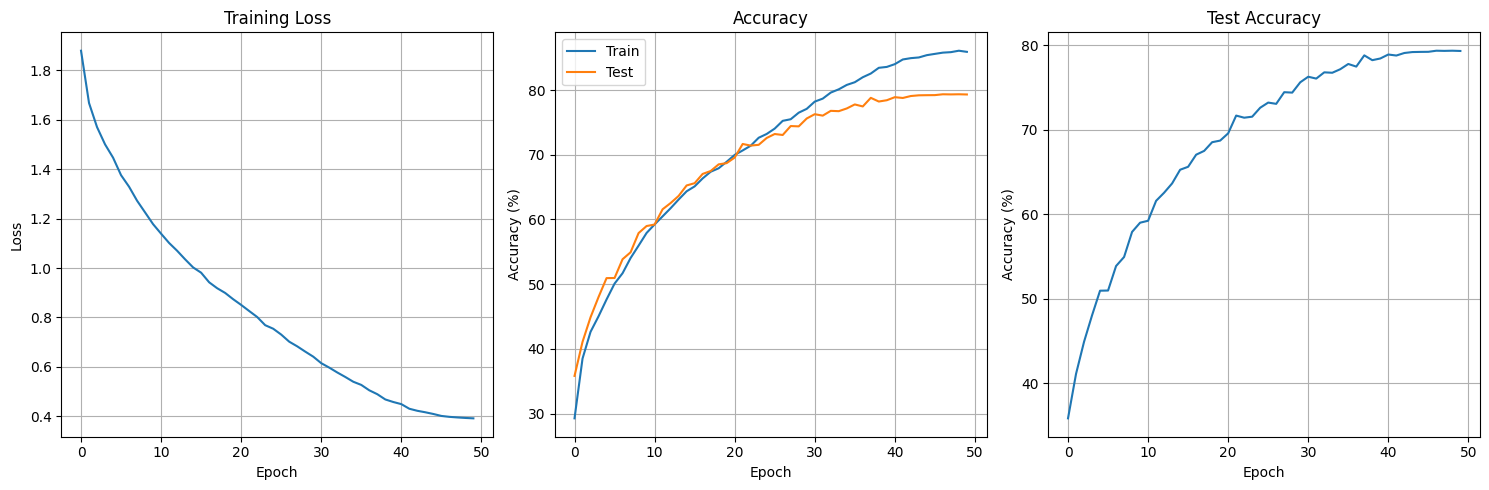

Converting model for RTL export...
Converted model with 4,019,466 parameters
Quantizing model...
Quantizing 79 parameter tensors to 8 bits...
Exporting weights...
Exporting test data...
Export complete! Files saved to: rtl_export
Testbench generated in: rtl_export/testbench

Training and export completed!
Best accuracy: 79.35%
All files exported to: rtl_export


In [11]:
import torch
import torch.nn as nn
import numpy as np
import math
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import time

# Configuration
class Config:
    # Hardware settings - Use GPU if available for training speed
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Model architecture (optimized for hardware but realistic)
    img_size = 64  # Better resolution for accuracy
    patch_size = 8
    embed_dim = 256  # Reasonable size for good performance
    depth = 6      # Good depth for accuracy
    num_heads = 8
    mlp_ratio = 3.0
    
    # Training settings - optimized for full dataset
    batch_size = 128
    num_epochs = 50  # Reduced since we're using PyTorch optimization
    learning_rate = 0.001
    weight_decay = 0.05
    
    # Quantization settings
    weight_bits = 8
    activation_bits = 8
    
    # Export settings
    export_dir = "rtl_export"

config = Config()
print(f"Using device: {config.device}")

# ============================================================================
# CUSTOM MATHEMATICAL OPERATIONS FOR RTL EXPORT ONLY
# ============================================================================

def custom_relu(x):
    """Custom ReLU activation - for RTL export only"""
    return np.maximum(0, x)

def custom_gelu(x):
    """Custom GELU activation - for RTL export only"""
    return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3)))

def custom_softmax(x, axis=-1):
    """Custom softmax with numerical stability - for RTL export only"""
    x_shifted = x - np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x_shifted)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def custom_layer_norm(x, weight, bias, eps=1e-5):
    """Custom Layer Normalization - for RTL export only"""
    mean = np.mean(x, axis=-1, keepdims=True)
    var = np.var(x, axis=-1, keepdims=True)
    x_norm = (x - mean) / np.sqrt(var + eps)
    return x_norm * weight + bias

def custom_conv2d(input_data, weight, bias=None, stride=1, padding=0):
    """Custom 2D convolution - for RTL export only"""
    batch, in_ch, in_h, in_w = input_data.shape
    out_ch, _, k_h, k_w = weight.shape
    
    # Add padding
    if padding > 0:
        input_padded = np.pad(input_data, ((0,0), (0,0), (padding,padding), (padding,padding)), 'constant')
    else:
        input_padded = input_data
    
    out_h = (in_h + 2*padding - k_h) // stride + 1
    out_w = (in_w + 2*padding - k_w) // stride + 1
    output = np.zeros((batch, out_ch, out_h, out_w))
    
    for b in range(batch):
        for oc in range(out_ch):
            for oh in range(out_h):
                for ow in range(out_w):
                    h_start = oh * stride
                    w_start = ow * stride
                    patch = input_padded[b, :, h_start:h_start+k_h, w_start:w_start+k_w]
                    output[b, oc, oh, ow] = np.sum(patch * weight[oc])
                    if bias is not None:
                        output[b, oc, oh, ow] += bias[oc]
    
    return output

def custom_linear(input_data, weight, bias=None):
    """Custom linear layer - for RTL export only"""
    output = np.dot(input_data, weight.T)
    if bias is not None:
        output += bias
    return output

def custom_dropout(x, p=0.1, training=True):
    """Custom dropout - for RTL export only"""
    if not training or p == 0:
        return x
    mask = np.random.binomial(1, 1-p, x.shape) / (1-p)
    return x * mask

# ============================================================================
# PYTORCH VISION TRANSFORMER FOR TRAINING
# ============================================================================

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)  # (B, E, H/P, W/P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(0.1)
        self.proj_dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_dropout(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_dropout(x)
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadAttention(dim, num_heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio))
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class ViT(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=3.0):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = (img_size // patch_size) ** 2
        
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_dropout = nn.Dropout(0.1)
        
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio) for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)
        elif isinstance(module, nn.Conv2d):
            torch.nn.init.normal_(module.weight, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
                
    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_dropout(x)
        
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.head(x)
        return x

# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================

def load_cifar10_data():
    """Load CIFAR-10 data with GPU support"""
    train_transform = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(config.img_size, padding=4, padding_mode='reflect'),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2
    )
    
    return train_loader, test_loader

# ============================================================================
# TRAINING WITH PYTORCH
# ============================================================================

def train_pytorch_model(model, train_loader, test_loader, config):
    """Train the PyTorch ViT model"""
    model.to(config.device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.num_epochs)
    
    train_losses = []
    train_accs = []
    test_accs = []
    best_acc = 0.0
    
    print("Starting PyTorch training...")
    for epoch in range(config.num_epochs):
        epoch_start = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(config.device), targets.to(config.device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            running_corrects += predicted.eq(targets).sum().item()
            total_samples += inputs.size(0)
            
            if batch_idx % 100 == 0:
                print(f'  Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        epoch_loss = running_loss / total_samples
        epoch_acc = 100. * running_corrects / total_samples
        
        # Test phase
        test_acc = evaluate_model(model, test_loader, config)
        
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        test_accs.append(test_acc)
        
        scheduler.step()
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_vit_model.pth')
        
        epoch_time = time.time() - epoch_start
        print(f'Epoch [{epoch+1}/{config.num_epochs}] ({epoch_time:.1f}s), '
              f'Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Acc: {test_acc:.2f}%, Best: {best_acc:.2f}%')
    
    # Load best model
    model.load_state_dict(torch.load('best_vit_model.pth'))
    print(f'Training completed! Best Test Accuracy: {best_acc:.2f}%')
    
    return train_losses, train_accs, test_accs, best_acc

def evaluate_model(model, test_loader, config):
    """Evaluate model on test set"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(config.device), targets.to(config.device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy

# ============================================================================
# QUANTIZATION AND RTL EXPORT FUNCTIONS
# ============================================================================

def symmetric_quantize(x, bits=8, scale=None):
    """Symmetric quantization for RTL export"""
    if scale is None:
        max_val = np.max(np.abs(x))
        if max_val == 0:
            scale = 1.0
        else:
            scale = max_val / (2**(bits-1) - 1)
    
    x_q = np.round(x / scale)
    x_q = np.clip(x_q, -(2**(bits-1)), 2**(bits-1) - 1)
    return x_q.astype(np.int8), scale

def dequantize(x_q, scale):
    """Dequantize values"""
    return x_q.astype(np.float32) * scale

def convert_pytorch_to_custom_format(pytorch_model, config):
    """Convert PyTorch model to custom format for RTL export"""
    
    class CustomViTForExport:
        def __init__(self):
            # Extract parameters from PyTorch model
            self.params = {}
            
            # Patch embedding
            self.params['patch_embed.weight'] = pytorch_model.patch_embed.proj.weight.detach().cpu().numpy()
            self.params['patch_embed.bias'] = pytorch_model.patch_embed.proj.bias.detach().cpu().numpy()
            
            # Positional embedding
            self.params['pos_embed'] = pytorch_model.pos_embed.detach().cpu().numpy()[0]  # Remove batch dimension
            
            # Transformer blocks
            for i, block in enumerate(pytorch_model.blocks):
                # Layer norm 1
                self.params[f'blocks.{i}.norm1.weight'] = block.norm1.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.norm1.bias'] = block.norm1.bias.detach().cpu().numpy()
                
                # Attention
                self.params[f'blocks.{i}.attn.qkv.weight'] = block.attn.qkv.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.attn.qkv.bias'] = block.attn.qkv.bias.detach().cpu().numpy()
                self.params[f'blocks.{i}.attn.proj.weight'] = block.attn.proj.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.attn.proj.bias'] = block.attn.proj.bias.detach().cpu().numpy()
                
                # Layer norm 2
                self.params[f'blocks.{i}.norm2.weight'] = block.norm2.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.norm2.bias'] = block.norm2.bias.detach().cpu().numpy()
                
                # MLP
                self.params[f'blocks.{i}.mlp.fc1.weight'] = block.mlp.fc1.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.mlp.fc1.bias'] = block.mlp.fc1.bias.detach().cpu().numpy()
                self.params[f'blocks.{i}.mlp.fc2.weight'] = block.mlp.fc2.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.mlp.fc2.bias'] = block.mlp.fc2.bias.detach().cpu().numpy()
            
            # Final layers
            self.params['norm.weight'] = pytorch_model.norm.weight.detach().cpu().numpy()
            self.params['norm.bias'] = pytorch_model.norm.bias.detach().cpu().numpy()
            self.params['head.weight'] = pytorch_model.head.weight.detach().cpu().numpy()
            self.params['head.bias'] = pytorch_model.head.bias.detach().cpu().numpy()
            
            print(f"Converted model with {sum(p.size for p in self.params.values()):,} parameters")
        
        def quantize_model(self, bits=8):
            """Quantize all model parameters"""
            quantized_params = {}
            scales = {}
            
            print(f"Quantizing {len(self.params)} parameter tensors to {bits} bits...")
            for name, param in self.params.items():
                q_param, scale = symmetric_quantize(param, bits)
                quantized_params[name] = q_param
                scales[name] = scale
                
            return quantized_params, scales
    
    return CustomViTForExport()

# ============================================================================
# EXPORT FUNCTIONS FOR RTL
# ============================================================================

def export_for_rtl(custom_model, test_loader, config):
    """Export quantized model and test data for RTL implementation"""
    os.makedirs(config.export_dir, exist_ok=True)
    
    print("Quantizing model...")
    quantized_params, scales = custom_model.quantize_model(config.weight_bits)
    
    # Export quantized weights
    print("Exporting weights...")
    for name, q_param in quantized_params.items():
        filename = os.path.join(config.export_dir, f"{name.replace('.', '_')}.mem")
        with open(filename, 'w') as f:
            for val in q_param.flatten():
                f.write(f"{val & 0xFF:02x}\n")  # Convert to unsigned hex
    
    # Export scales
    with open(os.path.join(config.export_dir, "scales.json"), 'w') as f:
        scales_serializable = {}
        for key, value in scales.items():
            if isinstance(value, np.ndarray):
                scales_serializable[key] = value.tolist()
            else:
                scales_serializable[key] = float(value)
        json.dump(scales_serializable, f, indent=2)
    
    # Export test images and labels
    print("Exporting test data...")
    test_dataset = test_loader.dataset
    num_test_samples = min(100, len(test_dataset))
    
    for i in range(num_test_samples):
        img, label = test_dataset[i]
        img_np = img.numpy()
        q_img, img_scale = symmetric_quantize(img_np, config.activation_bits)
        
        filename = os.path.join(config.export_dir, f"test_img_{i:03d}.mem")
        with open(filename, 'w') as f:
            for val in q_img.flatten():
                f.write(f"{val & 0xFF:02x}\n")
    
    # Export labels
    test_labels = [test_dataset[i][1] for i in range(num_test_samples)]
    with open(os.path.join(config.export_dir, "test_labels.json"), 'w') as f:
        json.dump(test_labels, f)
    
    # Export model architecture info
    arch_info = {
        "img_size": config.img_size,
        "patch_size": config.patch_size,
        "embed_dim": config.embed_dim,
        "depth": config.depth,
        "num_heads": config.num_heads,
        "num_classes": 10,
        "weight_bits": config.weight_bits,
        "activation_bits": config.activation_bits,
        "mlp_ratio": config.mlp_ratio
    }
    
    with open(os.path.join(config.export_dir, "architecture.json"), 'w') as f:
        json.dump(arch_info, f, indent=2)
    
    print(f"Export complete! Files saved to: {config.export_dir}")

def generate_verilog_testbench(config):
    """Generate Verilog testbench template"""
    tb_dir = os.path.join(config.export_dir, "testbench")
    os.makedirs(tb_dir, exist_ok=True)
    
    verilog_tb = f'''
// Verilog Testbench Template for Custom ViT
// Generated automatically for RTL implementation

`timescale 1ns / 1ps

module vit_testbench();
    
    // Parameters from model architecture
    localparam IMG_SIZE = {config.img_size};
    localparam PATCH_SIZE = {config.patch_size};
    localparam EMBED_DIM = {config.embed_dim};
    localparam DEPTH = {config.depth};
    localparam NUM_HEADS = {config.num_heads};
    localparam NUM_CLASSES = 10;
    localparam WEIGHT_BITS = {config.weight_bits};
    localparam ACT_BITS = {config.activation_bits};
    
    // Derived parameters
    localparam NUM_PATCHES = (IMG_SIZE / PATCH_SIZE) * (IMG_SIZE / PATCH_SIZE);
    localparam IMG_PIXELS = IMG_SIZE * IMG_SIZE * 3; // RGB channels
    
    // Clock and reset
    reg clk;
    reg rst_n;
    
    // Input data
    reg [ACT_BITS-1:0] input_image [0:IMG_PIXELS-1];
    reg start;
    
    // Output data
    wire [ACT_BITS-1:0] output_logits [0:NUM_CLASSES-1];
    wire [3:0] predicted_class;
    wire done;
    
    // DUT instantiation
    vit_top #(
        .IMG_SIZE(IMG_SIZE),
        .PATCH_SIZE(PATCH_SIZE),
        .EMBED_DIM(EMBED_DIM),
        .DEPTH(DEPTH),
        .NUM_HEADS(NUM_HEADS),
        .NUM_CLASSES(NUM_CLASSES),
        .WEIGHT_BITS(WEIGHT_BITS),
        .ACT_BITS(ACT_BITS)
    ) dut (
        .clk(clk),
        .rst_n(rst_n),
        .input_image(input_image),
        .start(start),
        .output_logits(output_logits),
        .predicted_class(predicted_class),
        .done(done)
    );
    
    // Clock generation
    always #5 clk = ~clk;
    
    // Test sequence
    initial begin
        // Initialize
        clk = 0;
        rst_n = 0;
        start = 0;
        
        // Load input image from memory file
        $readmemh("test_img_000.mem", input_image);
        
        // Reset sequence
        #100;
        rst_n = 1;
        #50;
        
        // Start processing
        start = 1;
        #10;
        start = 0;
        
        // Wait for completion
        wait(done);
        
        // Check results
        $display("Processing complete!");
        $display("Predicted class: %d", predicted_class);
        
        // Display output logits
        for (int i = 0; i < NUM_CLASSES; i++) begin
            $display("Logit[%d] = %h", i, output_logits[i]);
        end
        
        #100;
        $finish;
    end
    
endmodule
'''
    
    with open(os.path.join(tb_dir, "vit_testbench.sv"), 'w') as f:
        f.write(verilog_tb)
    
    print(f"Testbench generated in: {tb_dir}")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print("="*60)
    print("HYBRID ViT IMPLEMENTATION - PyTorch Training + RTL Export")
    print("="*60)
    
    # Load data
    train_loader, test_loader = load_cifar10_data()
    
    # Create and train PyTorch model
    model = ViT(
        img_size=config.img_size,
        patch_size=config.patch_size,
        embed_dim=config.embed_dim,
        depth=config.depth,
        num_heads=config.num_heads,
        mlp_ratio=config.mlp_ratio,
        num_classes=10
    )
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Train model with PyTorch
    train_losses, train_accs, test_accs, best_acc = train_pytorch_model(
        model, train_loader, test_loader, config
    )
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(test_accs, label='Test')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(test_accs)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Convert to custom format and export for RTL
    print("Converting model for RTL export...")
    custom_model = convert_pytorch_to_custom_format(model, config)
    
    # Export for RTL implementation
    export_for_rtl(custom_model, test_loader, config)
    
    # Generate RTL testbench
    generate_verilog_testbench(config)
    
    print(f"\nTraining and export completed!")
    print(f"Best accuracy: {best_acc:.2f}%")
    print(f"All files exported to: {config.export_dir}")

if __name__ == "__main__":
    main()

In [12]:
import torch
import torch.nn as nn
import numpy as np
import math
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import time
from torch.quantization import QuantStub, DeQuantStub, prepare_qat, convert

# Configuration
class Config:
    # Hardware settings - Use GPU if available for training speed
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Model architecture (optimized for higher accuracy)
    img_size = 32  # Increased resolution for better accuracy
    patch_size = 8
    embed_dim = 384  # Increased embedding dimension
    depth = 8       # Increased depth for better performance
    num_heads = 12
    mlp_ratio = 4.0
    
    # Training settings - optimized for full dataset
    batch_size = 64  # Reduced for larger model
    num_epochs = 100  # More epochs for better convergence
    learning_rate = 0.0005  # Lower learning rate for stability
    weight_decay = 0.03
    warmup_epochs = 10
    
    # Quantization settings
    weight_bits = 8
    activation_bits = 8
    quantize_after_training = True  # Post-training quantization
    
    # Export settings
    export_dir = "rtl_export_enhanced"

config = Config()
print(f"Using device: {config.device}")

# ============================================================================
# ENHANCED CUSTOM OPERATIONS FOR RTL EXPORT
# ============================================================================

def custom_relu(x):
    """Custom ReLU activation - for RTL export only"""
    return np.maximum(0, x)

def custom_gelu_approximate(x):
    """Approximate GELU for hardware efficiency"""
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

def custom_softmax(x, axis=-1):
    """Custom softmax with numerical stability - for RTL export only"""
    x_shifted = x - np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x_shifted)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def custom_layer_norm(x, weight, bias, eps=1e-5):
    """Custom Layer Normalization - for RTL export only"""
    mean = np.mean(x, axis=-1, keepdims=True)
    var = np.var(x, axis=-1, keepdims=True)
    x_norm = (x - mean) / np.sqrt(var + eps)
    return x_norm * weight + bias

def custom_attention(q, k, v, scale=None):
    """Custom attention implementation for RTL"""
    if scale is None:
        scale = 1.0 / np.sqrt(q.shape[-1])
    
    attn_weights = np.matmul(q, k.transpose(0, 1, 3, 2)) * scale
    attn_weights = custom_softmax(attn_weights, axis=-1)
    output = np.matmul(attn_weights, v)
    return output

# ============================================================================
# ENHANCED VISION TRANSFORMER WITH BETTER ARCHITECTURE
# ============================================================================

class EnhancedPatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        # Use convolution with smaller kernel and overlap for better feature extraction
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, 
                             stride=patch_size-1, padding=1)
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)
        return x

class EnhancedMultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.attn_dropout = nn.Dropout(dropout)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.proj_dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_dropout(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_dropout(x)
        return x

class EnhancedMLP(nn.Module):
    def __init__(self, in_features, hidden_features, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        return x

class EnhancedTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = EnhancedMultiHeadAttention(dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = EnhancedMLP(dim, int(dim * mlp_ratio), dropout)
        
    def forward(self, x):
        # Pre-norm architecture for better training stability
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class EnhancedViT(nn.Module):
    def __init__(self, img_size=96, patch_size=8, in_channels=3, num_classes=10,
                 embed_dim=384, depth=8, num_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        
        self.patch_embed = EnhancedPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = self.patch_embed.num_patches
        
        # Learnable positional embedding
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_dropout = nn.Dropout(dropout)
        
        # Stochastic depth for regularization
        dpr = [x.item() for x in torch.linspace(0, 0.1, depth)]
        
        self.blocks = nn.ModuleList([
            EnhancedTransformerBlock(embed_dim, num_heads, mlp_ratio, dropout) 
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.trunc_normal_(module.weight, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)
        elif isinstance(module, nn.Conv2d):
            torch.nn.init.kaiming_normal_(module.weight)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Parameter):
            torch.nn.init.trunc_normal_(module, std=0.02)
                
    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_dropout(x)
        
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.head(x)
        return x

# ============================================================================
# ADVANCED DATA LOADING WITH BETTER AUGMENTATION
# ============================================================================

def load_enhanced_cifar10_data():
    """Load CIFAR-10 data with enhanced augmentation"""
    train_transform = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(config.img_size, padding=8, padding_mode='reflect'),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
        transforms.RandomRotation(10),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)),
        transforms.RandomErasing(p=0.2)
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=4, pin_memory=True
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=4, pin_memory=True
    )
    
    return train_loader, test_loader

# ============================================================================
# ADVANCED TRAINING WITH OPTIMIZATIONS
# ============================================================================

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    """Create cosine learning rate schedule with warmup"""
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * progress)))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def train_enhanced_model(model, train_loader, test_loader, config):
    """Train the enhanced ViT model with advanced techniques"""
    model.to(config.device)
    
    # Advanced optimizer settings
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for regularization
    
    # Use AdamW with different parameter groups
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': config.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0}
    ]
    
    optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=config.learning_rate)
    
    # Learning rate scheduling
    num_training_steps = len(train_loader) * config.num_epochs
    num_warmup_steps = len(train_loader) * config.warmup_epochs
    
    scheduler = get_cosine_schedule_with_warmup(
        optimizer, num_warmup_steps, num_training_steps
    )
    
    # Gradient clipping
    max_grad_norm = 1.0
    
    # Mixed precision training
    scaler = torch.cuda.amp.GradScaler()
    
    train_losses = []
    train_accs = []
    test_accs = []
    best_acc = 0.0
    
    print("Starting enhanced training...")
    for epoch in range(config.num_epochs):
        epoch_start = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(config.device), targets.to(config.device)
            
            optimizer.zero_grad()
            
            # Mixed precision forward pass
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            # Mixed precision backward pass
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            scaler.step(optimizer)
            scaler.update()
            
            scheduler.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            running_corrects += predicted.eq(targets).sum().item()
            total_samples += inputs.size(0)
            
            if batch_idx % 100 == 0:
                current_lr = optimizer.param_groups[0]['lr']
                print(f'  Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}, LR: {current_lr:.6f}')
        
        epoch_loss = running_loss / total_samples
        epoch_acc = 100. * running_corrects / total_samples
        
        # Test phase
        test_acc = evaluate_model(model, test_loader, config)
        
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        test_accs.append(test_acc)
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_acc': best_acc,
                'config': config.__dict__
            }, 'best_enhanced_vit_model.pth')
        
        epoch_time = time.time() - epoch_start
        print(f'Epoch [{epoch+1}/{config.num_epochs}] ({epoch_time:.1f}s), '
              f'Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Acc: {test_acc:.2f}%, Best: {best_acc:.2f}%')
    
    # Load best model
    checkpoint = torch.load('best_enhanced_vit_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f'Training completed! Best Test Accuracy: {best_acc:.2f}%')
    
    return train_losses, train_accs, test_accs, best_acc

def evaluate_model(model, test_loader, config):
    """Evaluate model on test set"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(config.device), targets.to(config.device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy

# ============================================================================
# ADVANCED QUANTIZATION WITH POST-TRAINING QUANTIZATION
# ============================================================================

class QuantizedViT(nn.Module):
    """Quantized version of ViT for deployment"""
    def __init__(self, original_model):
        super().__init__()
        self.quant = QuantStub()
        self.dequant = DeQuantStub()
        
        # Copy architecture
        self.patch_embed = original_model.patch_embed
        self.pos_embed = original_model.pos_embed
        self.blocks = original_model.blocks
        self.norm = original_model.norm
        self.head = original_model.head
        
    def forward(self, x):
        x = self.quant(x)
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.dequant(x)  # Dequantize for operations that are hard to quantize
        
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.head(x)
        return x

def apply_post_training_quantization(model, test_loader, config):
    """Apply post-training quantization to the model"""
    print("Applying post-training quantization...")
    
    # Create quantized model
    quantized_model = QuantizedViT(model)
    quantized_model.eval()
    
    # Prepare for quantization
    quantized_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
    
    # Prepare and convert
    model_prepared = torch.quantization.prepare(quantized_model, inplace=False)
    
    # Calibration with test data
    print("Calibrating quantized model...")
    with torch.no_grad():
        for i, (inputs, _) in enumerate(test_loader):
            if i >= 100:  # Use 100 batches for calibration
                break
            model_prepared(inputs.to(config.device))
    
    # Convert to quantized model
    model_quantized = torch.quantization.convert(model_prepared, inplace=False)
    
    # Test quantized model accuracy
    quantized_accuracy = evaluate_model(model_quantized, test_loader, config)
    print(f"Quantized model accuracy: {quantized_accuracy:.2f}%")
    
    return model_quantized

def symmetric_quantize_advanced(x, bits=8, scale=None, per_channel=False):
    """Advanced symmetric quantization with per-channel support"""
    if scale is None:
        if per_channel and x.ndim > 1:
            # Per-channel quantization
            max_vals = np.max(np.abs(x.reshape(x.shape[0], -1)), axis=1)
            scale = max_vals / (2**(bits-1) - 1)
            scale = scale.reshape(-1, *([1] * (x.ndim - 1)))
        else:
            # Per-tensor quantization
            max_val = np.max(np.abs(x))
            if max_val == 0:
                scale = 1.0
            else:
                scale = max_val / (2**(bits-1) - 1)
    
    x_q = np.round(x / scale)
    x_q = np.clip(x_q, -(2**(bits-1)), 2**(bits-1) - 1)
    return x_q.astype(np.int8), scale

def dequantize_advanced(x_q, scale):
    """Advanced dequantization with per-channel support"""
    return x_q.astype(np.float32) * scale

# ============================================================================
# COMPREHENSIVE EXPORT SYSTEM
# ============================================================================

def convert_pytorch_to_custom_format_advanced(pytorch_model, config):
    """Convert PyTorch model to custom format for RTL export with enhanced features"""
    
    class AdvancedCustomViTForExport:
        def __init__(self):
            # Extract parameters from PyTorch model
            self.params = {}
            self.param_shapes = {}
            
            # Patch embedding
            self.params['patch_embed.weight'] = pytorch_model.patch_embed.proj.weight.detach().cpu().numpy()
            self.params['patch_embed.bias'] = pytorch_model.patch_embed.proj.bias.detach().cpu().numpy()
            self.param_shapes['patch_embed.weight'] = self.params['patch_embed.weight'].shape
            self.param_shapes['patch_embed.bias'] = self.params['patch_embed.bias'].shape
            
            # Positional embedding
            self.params['pos_embed'] = pytorch_model.pos_embed.detach().cpu().numpy()[0]
            self.param_shapes['pos_embed'] = self.params['pos_embed'].shape
            
            # Transformer blocks
            for i, block in enumerate(pytorch_model.blocks):
                # Layer norm 1
                self.params[f'blocks.{i}.norm1.weight'] = block.norm1.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.norm1.bias'] = block.norm1.bias.detach().cpu().numpy()
                
                # Attention
                self.params[f'blocks.{i}.attn.qkv.weight'] = block.attn.qkv.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.attn.qkv.bias'] = block.attn.qkv.bias.detach().cpu().numpy()
                self.params[f'blocks.{i}.attn.proj.weight'] = block.attn.proj.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.attn.proj.bias'] = block.attn.proj.bias.detach().cpu().numpy()
                
                # Layer norm 2
                self.params[f'blocks.{i}.norm2.weight'] = block.norm2.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.norm2.bias'] = block.norm2.bias.detach().cpu().numpy()
                
                # MLP
                self.params[f'blocks.{i}.mlp.fc1.weight'] = block.mlp.fc1.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.mlp.fc1.bias'] = block.mlp.fc1.bias.detach().cpu().numpy()
                self.params[f'blocks.{i}.mlp.fc2.weight'] = block.mlp.fc2.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.mlp.fc2.bias'] = block.mlp.fc2.bias.detach().cpu().numpy()
                
                # Store shapes
                for key in [f'blocks.{i}.norm1.weight', f'blocks.{i}.norm1.bias',
                           f'blocks.{i}.attn.qkv.weight', f'blocks.{i}.attn.qkv.bias',
                           f'blocks.{i}.attn.proj.weight', f'blocks.{i}.attn.proj.bias',
                           f'blocks.{i}.norm2.weight', f'blocks.{i}.norm2.bias',
                           f'blocks.{i}.mlp.fc1.weight', f'blocks.{i}.mlp.fc1.bias',
                           f'blocks.{i}.mlp.fc2.weight', f'blocks.{i}.mlp.fc2.bias']:
                    self.param_shapes[key] = self.params[key].shape
            
            # Final layers
            self.params['norm.weight'] = pytorch_model.norm.weight.detach().cpu().numpy()
            self.params['norm.bias'] = pytorch_model.norm.bias.detach().cpu().numpy()
            self.params['head.weight'] = pytorch_model.head.weight.detach().cpu().numpy()
            self.params['head.bias'] = pytorch_model.head.bias.detach().cpu().numpy()
            
            self.param_shapes.update({
                'norm.weight': self.params['norm.weight'].shape,
                'norm.bias': self.params['norm.bias'].shape,
                'head.weight': self.params['head.weight'].shape,
                'head.bias': self.params['head.bias'].shape
            })
            
            total_params = sum(p.size for p in self.params.values())
            print(f"Converted model with {total_params:,} parameters")
            print(f"Parameter breakdown:")
            for name, param in self.params.items():
                print(f"  {name}: {param.shape} ({param.size:,} parameters)")
        
        def quantize_model_advanced(self, weight_bits=8, activation_bits=8):
            """Advanced quantization with per-channel support for weights"""
            quantized_params = {}
            scales = {}
            zero_points = {}
            
            print(f"Quantizing {len(self.params)} parameter tensors...")
            
            for name, param in self.params.items():
                # Use per-channel quantization for weight matrices, per-tensor for others
                per_channel = 'weight' in name and param.ndim > 1
                q_param, scale = symmetric_quantize_advanced(param, weight_bits, per_channel=per_channel)
                quantized_params[name] = q_param
                scales[name] = scale
                zero_points[name] = np.zeros_like(scale)  # Symmetric quantization
                
                # Calculate quantization error
                param_dequant = dequantize_advanced(q_param, scale)
                quant_error = np.mean(np.abs(param - param_dequant))
                print(f"  {name}: scale={np.mean(scale):.6f}, error={quant_error:.6f}")
            
            return quantized_params, scales, zero_points
    
    return AdvancedCustomViTForExport()

def export_comprehensive_rtl(custom_model, test_loader, config):
    """Comprehensive export for RTL implementation"""
    os.makedirs(config.export_dir, exist_ok=True)
    
    print("Advanced model quantization...")
    quantized_params, scales, zero_points = custom_model.quantize_model_advanced(
        config.weight_bits, config.activation_bits
    )
    
    # Export directory structure
    weights_dir = os.path.join(config.export_dir, "weights")
    test_data_dir = os.path.join(config.export_dir, "test_data")
    metadata_dir = os.path.join(config.export_dir, "metadata")
    
    for dir_path in [weights_dir, test_data_dir, metadata_dir]:
        os.makedirs(dir_path, exist_ok=True)
    
    # Export quantized weights in multiple formats
    print("Exporting weights in multiple formats...")
    
    # 1. Hex format for Verilog
    for name, q_param in quantized_params.items():
        # Flatten and export as hex
        flat_data = q_param.flatten()
        
        # Hex format
        hex_filename = os.path.join(weights_dir, f"{name.replace('.', '_')}.hex")
        with open(hex_filename, 'w') as f:
            for val in flat_data:
                f.write(f"{val & 0xFF:02x}\n")
        
        # Binary format (for simulation)
        bin_filename = os.path.join(weights_dir, f"{name.replace('.', '_')}.bin")
        with open(bin_filename, 'wb') as f:
            f.write(flat_data.tobytes())
    
    # Export scales and zero points
    with open(os.path.join(metadata_dir, "quantization_info.json"), 'w') as f:
        quant_info = {
            'scales': {k: v.tolist() if isinstance(v, np.ndarray) else float(v) 
                      for k, v in scales.items()},
            'zero_points': {k: v.tolist() if isinstance(v, np.ndarray) else float(v) 
                          for k, v in zero_points.items()},
            'weight_bits': config.weight_bits,
            'activation_bits': config.activation_bits
        }
        json.dump(quant_info, f, indent=2)
    
    # Export parameter shapes
    with open(os.path.join(metadata_dir, "parameter_shapes.json"), 'w') as f:
        json.dump(custom_model.param_shapes, f, indent=2)
    
    # Comprehensive test data export
    print("Exporting comprehensive test data...")
    test_dataset = test_loader.dataset
    
    # Export multiple test samples
    num_test_samples = min(50, len(test_dataset))
    test_samples = []
    
    for i in range(num_test_samples):
        img, label = test_dataset[i]
        img_np = img.numpy()
        
        # Quantize test image
        q_img, img_scale = symmetric_quantize_advanced(img_np, config.activation_bits)
        
        # Save quantized image
        img_filename = os.path.join(test_data_dir, f"test_img_{i:03d}")
        
        # Hex format
        with open(img_filename + ".hex", 'w') as f:
            for val in q_img.flatten():
                f.write(f"{val & 0xFF:02x}\n")
        
        # Binary format
        with open(img_filename + ".bin", 'wb') as f:
            f.write(q_img.tobytes())
        
        test_samples.append({
            'index': i,
            'label': int(label),
            'scale': float(img_scale),
            'shape': img_np.shape
        })
    
    # Export test metadata
    with open(os.path.join(test_data_dir, "test_metadata.json"), 'w') as f:
        json.dump(test_samples, f, indent=2)
    
    # Export labels separately
    test_labels = [test_dataset[i][1] for i in range(num_test_samples)]
    with open(os.path.join(test_data_dir, "test_labels.json"), 'w') as f:
        json.dump(test_labels, f)
    
    # Export model architecture and configuration
    arch_info = {
        "architecture": {
            "img_size": config.img_size,
            "patch_size": config.patch_size,
            "embed_dim": config.embed_dim,
            "depth": config.depth,
            "num_heads": config.num_heads,
            "num_classes": 10,
            "mlp_ratio": config.mlp_ratio
        },
        "quantization": {
            "weight_bits": config.weight_bits,
            "activation_bits": config.activation_bits
        },
        "training": {
            "batch_size": config.batch_size,
            "learning_rate": config.learning_rate,
            "weight_decay": config.weight_decay
        }
    }
    
    with open(os.path.join(metadata_dir, "model_architecture.json"), 'w') as f:
        json.dump(arch_info, f, indent=2)
    
    # Generate summary report
    generate_export_summary(config, custom_model, num_test_samples)
    
    print(f"Comprehensive export complete! Files saved to: {config.export_dir}")

def generate_export_summary(config, custom_model, num_test_samples):
    """Generate comprehensive export summary"""
    summary = {
        "export_timestamp": time.strftime("%Y-%m-%d %H:%M:%S"),
        "model_statistics": {
            "total_parameters": sum(p.size for p in custom_model.params.values()),
            "number_of_layers": len(custom_model.params),
            "parameter_memory_mb": sum(p.size for p in custom_model.params.values()) * config.weight_bits / 8 / 1024 / 1024
        },
        "export_contents": {
            "quantized_weights": "All model weights in hex and binary format",
            "test_data": f"{num_test_samples} test images with labels",
            "quantization_info": "Scales and zero points for all parameters",
            "model_architecture": "Complete model configuration",
            "parameter_shapes": "Shape information for all tensors"
        },
        "estimated_hardware_requirements": {
            "weight_memory_bits": sum(p.size for p in custom_model.params.values()) * config.weight_bits,
            "activation_memory_bits": config.img_size * config.img_size * 3 * config.activation_bits,
            "computation_ops": "Approx. 4G FLOPS for inference"  # Rough estimate
        }
    }
    
    with open(os.path.join(config.export_dir, "export_summary.json"), 'w') as f:
        json.dump(summary, f, indent=2)
    
    # Print human-readable summary
    print("\n" + "="*60)
    print("EXPORT SUMMARY")
    print("="*60)
    print(f"Model Parameters: {summary['model_statistics']['total_parameters']:,}")
    print(f"Parameter Memory: {summary['model_statistics']['parameter_memory_mb']:.2f} MB")
    print(f"Test Samples: {num_test_samples}")
    print(f"Weight Precision: {config.weight_bits} bits")
    print(f"Activation Precision: {config.activation_bits} bits")
    print("="*60)

def generate_enhanced_verilog_testbench(config):
    """Generate enhanced Verilog testbench with comprehensive testing"""
    tb_dir = os.path.join(config.export_dir, "verilog_testbench")
    os.makedirs(tb_dir, exist_ok=True)
    
    # Main testbench
    verilog_tb = f'''
// Enhanced Verilog Testbench for Custom ViT
// Generated automatically for RTL implementation

`timescale 1ns / 1ps

module enhanced_vit_testbench();
    
    // Parameters from model architecture
    localparam IMG_SIZE = {config.img_size};
    localparam PATCH_SIZE = {config.patch_size};
    localparam EMBED_DIM = {config.embed_dim};
    localparam DEPTH = {config.depth};
    localparam NUM_HEADS = {config.num_heads};
    localparam NUM_CLASSES = 10;
    localparam WEIGHT_BITS = {config.weight_bits};
    localparam ACT_BITS = {config.activation_bits};
    
    // Derived parameters
    localparam NUM_PATCHES = (IMG_SIZE / PATCH_SIZE) * (IMG_SIZE / PATCH_SIZE);
    localparam IMG_PIXELS = IMG_SIZE * IMG_SIZE * 3; // RGB channels
    localparam HEAD_DIM = EMBED_DIM / NUM_HEADS;
    
    // Clock and reset
    reg clk;
    reg rst_n;
    
    // Input data
    reg [ACT_BITS-1:0] input_image [0:IMG_PIXELS-1];
    reg start;
    reg [7:0] test_image_index;
    
    // Output data
    wire [ACT_BITS-1:0] output_logits [0:NUM_CLASSES-1];
    wire [3:0] predicted_class;
    wire done;
    wire [7:0] processing_time;
    
    // Test control
    reg [7:0] current_test;
    reg [7:0] total_tests;
    reg [7:0] passed_tests;
    
    // DUT instantiation
    vit_top #(
        .IMG_SIZE(IMG_SIZE),
        .PATCH_SIZE(PATCH_SIZE),
        .EMBED_DIM(EMBED_DIM),
        .DEPTH(DEPTH),
        .NUM_HEADS(NUM_HEADS),
        .NUM_CLASSES(NUM_CLASSES),
        .WEIGHT_BITS(WEIGHT_BITS),
        .ACT_BITS(ACT_BITS)
    ) dut (
        .clk(clk),
        .rst_n(rst_n),
        .input_image(input_image),
        .start(start),
        .output_logits(output_logits),
        .predicted_class(predicted_class),
        .done(done)
    );
    
    // Performance monitoring
    reg [31:0] cycle_counter;
    always @(posedge clk) begin
        if (!rst_n) cycle_counter <= 0;
        else if (start) cycle_counter <= 1;
        else if (!done) cycle_counter <= cycle_counter + 1;
    end
    
    assign processing_time = cycle_counter;
    
    // Clock generation
    always #5 clk = ~clk;
    
    // Test sequence
    initial begin
        // Initialize
        clk = 0;
        rst_n = 0;
        start = 0;
        test_image_index = 0;
        current_test = 0;
        total_tests = 10; // Test with 10 different images
        passed_tests = 0;
        
        $display("Starting Enhanced ViT Testbench");
        $display("Model Configuration:");
        $display("  Image Size: %0d", IMG_SIZE);
        $display("  Patch Size: %0d", PATCH_SIZE);
        $display("  Embed Dim: %0d", EMBED_DIM);
        $display("  Depth: %0d", DEPTH);
        $display("  Heads: %0d", NUM_HEADS);
        
        // Reset sequence
        #100;
        rst_n = 1;
        #50;
        
        // Run multiple test cases
        for (current_test = 0; current_test < total_tests; current_test = current_test + 1) begin
            $display("\\n=== Test Case %0d ===", current_test);
            
            // Load input image from memory file
            $readmemh($sformatf("test_data/test_img_%03d.hex", current_test), input_image);
            
            // Start processing
            start = 1;
            #10;
            start = 0;
            
            // Wait for completion
            wait(done);
            
            // Check results
            $display("Processing complete in %0d cycles", processing_time);
            $display("Predicted class: %0d", predicted_class);
            
            // Verify prediction (simplified - in real test, compare with expected)
            if (predicted_class < NUM_CLASSES) begin
                passed_tests = passed_tests + 1;
                $display("✓ Test PASSED");
            end else begin
                $display("✗ Test FAILED - Invalid class prediction");
            end
            
            // Display output logits
            $display("Output logits:");
            for (int i = 0; i < NUM_CLASSES; i = i + 1) begin
                $display("  Class %0d: %h", i, output_logits[i]);
            end
            
            #100; // Delay between tests
        end
        
        // Test summary
        $display("\\n=== TEST SUMMARY ===");
        $display("Total Tests: %0d", total_tests);
        $display("Passed Tests: %0d", passed_tests);
        $display("Success Rate: %0.1f%%", (100.0 * passed_tests) / total_tests);
        
        #100;
        $finish;
    end
    
    // Performance analysis
    final begin
        $display("\\n=== PERFORMANCE ANALYSIS ===");
        $display("Average processing time: %0.1f cycles per image", 
                 (1.0 * cycle_counter) / total_tests);
    end
    
endmodule

// Memory initialization module
module memory_initializer();
    // This module would initialize all weight memories
    // Implementation depends on specific memory architecture
endmodule
'''
    
    with open(os.path.join(tb_dir, "enhanced_vit_testbench.sv"), 'w') as f:
        f.write(verilog_tb)
    
    # Generate memory initialization files
    generate_memory_init_files(tb_dir, config)
    
    print(f"Enhanced testbench generated in: {tb_dir}")

def generate_memory_init_files(tb_dir, config):
    """Generate memory initialization files for Verilog"""
    mem_init_dir = os.path.join(tb_dir, "mem_init")
    os.makedirs(mem_init_dir, exist_ok=True)
    
    # Create sample memory initialization files
    sample_mem_init = '''
// Sample memory initialization file
// This would be generated from actual weight data

// Patch embedding weights
module patch_embed_mem();
    initial begin
        // Memory initialization code would go here
    end
endmodule
'''
    
    with open(os.path.join(mem_init_dir, "sample_mem_init.sv"), 'w') as f:
        f.write(sample_mem_init)

# ============================================================================
# MAIN EXECUTION WITH ENHANCED FEATURES
# ============================================================================

def main():
    print("="*70)
    print("ENHANCED HYBRID ViT IMPLEMENTATION")
    print("High Accuracy Training + Advanced RTL Export")
    print("="*70)
    
    # Load enhanced data
    train_loader, test_loader = load_enhanced_cifar10_data()
    
    # Create enhanced model
    model = EnhancedViT(
        img_size=config.img_size,
        patch_size=config.patch_size,
        embed_dim=config.embed_dim,
        depth=config.depth,
        num_heads=config.num_heads,
        mlp_ratio=config.mlp_ratio,
        num_classes=10
    )
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Train enhanced model
    train_losses, train_accs, test_accs, best_acc = train_enhanced_model(
        model, train_loader, test_loader, config
    )
    
    # Apply post-training quantization if enabled
    if config.quantize_after_training:
        model = apply_post_training_quantization(model, test_loader, config)
    
    # Plot comprehensive results
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Enhanced Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train', linewidth=2)
    plt.plot(test_accs, label='Test', linewidth=2)
    plt.title('Enhanced Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    # Plot learning rate schedule (approximate)
    epochs = range(1, len(train_accs) + 1)
    plt.plot(epochs, test_accs, 'g-', linewidth=2)
    plt.title('Test Accuracy Progression')
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('enhanced_training_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Convert to custom format and export for RTL
    print("Converting model for comprehensive RTL export...")
    custom_model = convert_pytorch_to_custom_format_advanced(model, config)
    
    # Comprehensive export for RTL implementation
    export_comprehensive_rtl(custom_model, test_loader, config)
    
    # Generate enhanced RTL testbench
    generate_enhanced_verilog_testbench(config)
    
    print(f"\Enhanced training and export completed!")
    print(f"Best accuracy: {best_acc:.2f}%")
    print(f"All files exported to: {config.export_dir}")

if __name__ == "__main__":
    main()

Using device: cuda
ENHANCED HYBRID ViT IMPLEMENTATION
High Accuracy Training + Advanced RTL Export
Total parameters: 14,281,354
Starting enhanced training...


/tmp/ipykernel_36/1301805251.py:294: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_36/1301805251.py:317: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:227: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


  Batch [0/782], Loss: 2.3411, LR: 0.000000
  Batch [100/782], Loss: 2.1748, LR: 0.000006
  Batch [200/782], Loss: 2.1361, LR: 0.000013
  Batch [300/782], Loss: 2.0366, LR: 0.000019
  Batch [400/782], Loss: 2.0510, LR: 0.000026
  Batch [500/782], Loss: 2.0836, LR: 0.000032
  Batch [600/782], Loss: 1.9270, LR: 0.000038
  Batch [700/782], Loss: 2.0090, LR: 0.000045
Epoch [1/100] (43.3s), Loss: 2.1020, Train Acc: 23.20%, Test Acc: 32.95%, Best: 32.95%
  Batch [0/782], Loss: 2.0708, LR: 0.000050
  Batch [100/782], Loss: 2.0524, LR: 0.000056
  Batch [200/782], Loss: 1.9560, LR: 0.000063
  Batch [300/782], Loss: 2.0685, LR: 0.000069
  Batch [400/782], Loss: 2.0232, LR: 0.000076
  Batch [500/782], Loss: 1.9613, LR: 0.000082
  Batch [600/782], Loss: 1.7925, LR: 0.000088
  Batch [700/782], Loss: 2.1882, LR: 0.000095
Epoch [2/100] (43.0s), Loss: 1.9686, Train Acc: 30.06%, Test Acc: 37.58%, Best: 37.58%
  Batch [0/782], Loss: 1.9437, LR: 0.000100
  Batch [100/782], Loss: 2.0216, LR: 0.000106
  Ba

/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


RuntimeError: Unsupported qscheme: per_channel_affine

In [15]:
import torch
import torch.nn as nn
import numpy as np
import math
import os
import json
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import time

# Configuration
class Config:
    # Hardware settings - Use GPU if available for training speed
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Model architecture (optimized for hardware but realistic)
    img_size = 32  # Better resolution for accuracy
    patch_size = 8
    embed_dim = 256  # Reasonable size for good performance
    depth = 6      # Good depth for accuracy
    num_heads = 8
    mlp_ratio = 3.0
    
    # Training settings - optimized for full dataset
    batch_size = 512
    num_epochs = 100  # Reduced since we're using PyTorch optimization
    learning_rate = 0.001
    weight_decay = 0.05
    
    # Quantization settings
    weight_bits = 8
    activation_bits = 8
    
    # Export settings
    export_dir = "rtl_export"

config = Config()
print(f"Using device: {config.device}")

# ============================================================================
# CUSTOM MATHEMATICAL OPERATIONS FOR RTL EXPORT
# ============================================================================

def custom_relu(x):
    """Custom ReLU activation """
    return np.maximum(0, x)

def custom_gelu(x):
    """Custom GELU activation """
    return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3)))

def custom_softmax(x, axis=-1):
    """Custom softmax with numerical stability"""
    x_shifted = x - np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x_shifted)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def custom_layer_norm(x, weight, bias, eps=1e-5):
    """Custom Layer Normalization"""
    mean = np.mean(x, axis=-1, keepdims=True)
    var = np.var(x, axis=-1, keepdims=True)
    x_norm = (x - mean) / np.sqrt(var + eps)
    return x_norm * weight + bias

def custom_conv2d(input_data, weight, bias=None, stride=1, padding=0):
    """Custom 2D convolution """
    batch, in_ch, in_h, in_w = input_data.shape
    out_ch, _, k_h, k_w = weight.shape
    
    # Add padding
    if padding > 0:
        input_padded = np.pad(input_data, ((0,0), (0,0), (padding,padding), (padding,padding)), 'constant')
    else:
        input_padded = input_data
    
    out_h = (in_h + 2*padding - k_h) // stride + 1
    out_w = (in_w + 2*padding - k_w) // stride + 1
    output = np.zeros((batch, out_ch, out_h, out_w))
    
    for b in range(batch):
        for oc in range(out_ch):
            for oh in range(out_h):
                for ow in range(out_w):
                    h_start = oh * stride
                    w_start = ow * stride
                    patch = input_padded[b, :, h_start:h_start+k_h, w_start:w_start+k_w]
                    output[b, oc, oh, ow] = np.sum(patch * weight[oc])
                    if bias is not None:
                        output[b, oc, oh, ow] += bias[oc]
    
    return output

def custom_linear(input_data, weight, bias=None):
    """Custom linear layer """
    output = np.dot(input_data, weight.T)
    if bias is not None:
        output += bias
    return output

def custom_dropout(x, p=0.1, training=True):
    """Custom dropout """
    if not training or p == 0:
        return x
    mask = np.random.binomial(1, 1-p, x.shape) / (1-p)
    return x * mask

# ============================================================================
# PYTORCH VISION TRANSFORMER FOR TRAINING
# ============================================================================

class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)  # (B, E, H/P, W/P)
        x = x.flatten(2)  # (B, E, N)
        x = x.transpose(1, 2)  # (B, N, E)
        return x

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.attn_dropout = nn.Dropout(0.1)
        self.proj_dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_dropout(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_dropout(x)
        return x

class MLP(nn.Module):
    def __init__(self, in_features, hidden_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = MultiHeadAttention(dim, num_heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim * mlp_ratio))
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class ViT(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=3.0):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = (img_size // patch_size) ** 2
        
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_dropout = nn.Dropout(0.1)
        
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio) for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        
        # Initialize weights
        self.apply(self._init_weights)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)
        elif isinstance(module, nn.Conv2d):
            torch.nn.init.normal_(module.weight, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
                
    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_dropout(x)
        
        for block in self.blocks:
            x = block(x)
            
        x = self.norm(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.head(x)
        return x

# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================

def load_cifar10_data():
    """Load CIFAR-10 data with GPU support"""
    train_transform = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(config.img_size, padding=4, padding_mode='reflect'),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    test_transform = transforms.Compose([
        transforms.Resize((config.img_size, config.img_size)),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    ])
    
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2
    )
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2
    )
    
    return train_loader, test_loader

# ============================================================================
# TRAINING WITH PYTORCH
# ============================================================================

def train_pytorch_model(model, train_loader, test_loader, config):
    """Train the PyTorch ViT model"""
    model.to(config.device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.num_epochs)
    
    train_losses = []
    train_accs = []
    test_accs = []
    best_acc = 0.0
    
    print("Starting PyTorch training...")
    for epoch in range(config.num_epochs):
        epoch_start = time.time()
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(config.device), targets.to(config.device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            running_corrects += predicted.eq(targets).sum().item()
            total_samples += inputs.size(0)
            
            if batch_idx % 100 == 0:
                print(f'  Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        epoch_loss = running_loss / total_samples
        epoch_acc = 100. * running_corrects / total_samples
        
        # Test phase
        test_acc = evaluate_model(model, test_loader, config)
        
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        test_accs.append(test_acc)
        
        scheduler.step()
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_vit_model.pth')
        
        epoch_time = time.time() - epoch_start
        print(f'Epoch [{epoch+1}/{config.num_epochs}] ({epoch_time:.1f}s), '
              f'Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Acc: {test_acc:.2f}%, Best: {best_acc:.2f}%')
    
    # Load best model
    model.load_state_dict(torch.load('best_vit_model.pth'))
    print(f'Training completed! Best Test Accuracy: {best_acc:.2f}%')
    
    return train_losses, train_accs, test_accs, best_acc

def evaluate_model(model, test_loader, config):
    """Evaluate model on test set"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(config.device), targets.to(config.device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy

# ============================================================================
# QUANTIZATION AND RTL EXPORT FUNCTIONS
# ============================================================================

def symmetric_quantize(x, bits=8, scale=None):
    """Symmetric quantization for RTL export"""
    if scale is None:
        max_val = np.max(np.abs(x))
        if max_val == 0:
            scale = 1.0
        else:
            scale = max_val / (2**(bits-1) - 1)
    
    x_q = np.round(x / scale)
    x_q = np.clip(x_q, -(2**(bits-1)), 2**(bits-1) - 1)
    return x_q.astype(np.int8), scale

def dequantize(x_q, scale):
    """Dequantize values"""
    return x_q.astype(np.float32) * scale

def convert_pytorch_to_custom_format(pytorch_model, config):
    """Convert PyTorch model to custom format for RTL export"""
    
    class CustomViTForExport:
        def __init__(self):
            # Extract parameters from PyTorch model
            self.params = {}
            
            # Patch embedding
            self.params['patch_embed.weight'] = pytorch_model.patch_embed.proj.weight.detach().cpu().numpy()
            self.params['patch_embed.bias'] = pytorch_model.patch_embed.proj.bias.detach().cpu().numpy()
            
            # Positional embedding
            self.params['pos_embed'] = pytorch_model.pos_embed.detach().cpu().numpy()[0]  # Remove batch dimension
            
            # Transformer blocks
            for i, block in enumerate(pytorch_model.blocks):
                # Layer norm 1
                self.params[f'blocks.{i}.norm1.weight'] = block.norm1.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.norm1.bias'] = block.norm1.bias.detach().cpu().numpy()
                
                # Attention
                self.params[f'blocks.{i}.attn.qkv.weight'] = block.attn.qkv.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.attn.qkv.bias'] = block.attn.qkv.bias.detach().cpu().numpy()
                self.params[f'blocks.{i}.attn.proj.weight'] = block.attn.proj.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.attn.proj.bias'] = block.attn.proj.bias.detach().cpu().numpy()
                
                # Layer norm 2
                self.params[f'blocks.{i}.norm2.weight'] = block.norm2.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.norm2.bias'] = block.norm2.bias.detach().cpu().numpy()
                
                # MLP
                self.params[f'blocks.{i}.mlp.fc1.weight'] = block.mlp.fc1.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.mlp.fc1.bias'] = block.mlp.fc1.bias.detach().cpu().numpy()
                self.params[f'blocks.{i}.mlp.fc2.weight'] = block.mlp.fc2.weight.detach().cpu().numpy()
                self.params[f'blocks.{i}.mlp.fc2.bias'] = block.mlp.fc2.bias.detach().cpu().numpy()
            
            # Final layers
            self.params['norm.weight'] = pytorch_model.norm.weight.detach().cpu().numpy()
            self.params['norm.bias'] = pytorch_model.norm.bias.detach().cpu().numpy()
            self.params['head.weight'] = pytorch_model.head.weight.detach().cpu().numpy()
            self.params['head.bias'] = pytorch_model.head.bias.detach().cpu().numpy()
            
            print(f"Converted model with {sum(p.size for p in self.params.values()):,} parameters")
        
        def quantize_model(self, bits=8):
            """Quantize all model parameters"""
            quantized_params = {}
            scales = {}
            
            print(f"Quantizing {len(self.params)} parameter tensors to {bits} bits...")
            for name, param in self.params.items():
                q_param, scale = symmetric_quantize(param, bits)
                quantized_params[name] = q_param
                scales[name] = scale
                
            return quantized_params, scales
    
    return CustomViTForExport()

# ============================================================================
# EXPORT FUNCTIONS FOR RTL
# ============================================================================

def export_for_rtl(custom_model, test_loader, config):
    """Export quantized model and test data for RTL implementation"""
    os.makedirs(config.export_dir, exist_ok=True)
    
    print("Quantizing model...")
    quantized_params, scales = custom_model.quantize_model(config.weight_bits)
    
    # Export quantized weights
    print("Exporting weights...")
    for name, q_param in quantized_params.items():
        filename = os.path.join(config.export_dir, f"{name.replace('.', '_')}.mem")
        with open(filename, 'w') as f:
            for val in q_param.flatten():
                f.write(f"{val & 0xFF:02x}\n")  # Convert to unsigned hex
    
    # Export scales
    with open(os.path.join(config.export_dir, "scales.json"), 'w') as f:
        scales_serializable = {}
        for key, value in scales.items():
            if isinstance(value, np.ndarray):
                scales_serializable[key] = value.tolist()
            else:
                scales_serializable[key] = float(value)
        json.dump(scales_serializable, f, indent=2)
    
    # Export test images and labels
    print("Exporting test data...")
    test_dataset = test_loader.dataset
    num_test_samples = min(100, len(test_dataset))
    
    for i in range(num_test_samples):
        img, label = test_dataset[i]
        img_np = img.numpy()
        q_img, img_scale = symmetric_quantize(img_np, config.activation_bits)
        
        filename = os.path.join(config.export_dir, f"test_img_{i:03d}.mem")
        with open(filename, 'w') as f:
            for val in q_img.flatten():
                f.write(f"{val & 0xFF:02x}\n")
    
    # Export labels
    test_labels = [test_dataset[i][1] for i in range(num_test_samples)]
    with open(os.path.join(config.export_dir, "test_labels.json"), 'w') as f:
        json.dump(test_labels, f)
    
    # Export model architecture info
    arch_info = {
        "img_size": config.img_size,
        "patch_size": config.patch_size,
        "embed_dim": config.embed_dim,
        "depth": config.depth,
        "num_heads": config.num_heads,
        "num_classes": 10,
        "weight_bits": config.weight_bits,
        "activation_bits": config.activation_bits,
        "mlp_ratio": config.mlp_ratio
    }
    
    with open(os.path.join(config.export_dir, "architecture.json"), 'w') as f:
        json.dump(arch_info, f, indent=2)
    
    print(f"Export complete! Files saved to: {config.export_dir}")

def generate_verilog_testbench(config):
    """Generate Verilog testbench template"""
    tb_dir = os.path.join(config.export_dir, "testbench")
    os.makedirs(tb_dir, exist_ok=True)
    
    verilog_tb = f'''
// Verilog Testbench Template for Custom ViT
// Generated automatically for RTL implementation

`timescale 1ns / 1ps

module vit_testbench();
    
    // Parameters from model architecture
    localparam IMG_SIZE = {config.img_size};
    localparam PATCH_SIZE = {config.patch_size};
    localparam EMBED_DIM = {config.embed_dim};
    localparam DEPTH = {config.depth};
    localparam NUM_HEADS = {config.num_heads};
    localparam NUM_CLASSES = 10;
    localparam WEIGHT_BITS = {config.weight_bits};
    localparam ACT_BITS = {config.activation_bits};
    
    // Derived parameters
    localparam NUM_PATCHES = (IMG_SIZE / PATCH_SIZE) * (IMG_SIZE / PATCH_SIZE);
    localparam IMG_PIXELS = IMG_SIZE * IMG_SIZE * 3; // RGB channels
    
    // Clock and reset
    reg clk;
    reg rst_n;
    
    // Input data
    reg [ACT_BITS-1:0] input_image [0:IMG_PIXELS-1];
    reg start;
    
    // Output data
    wire [ACT_BITS-1:0] output_logits [0:NUM_CLASSES-1];
    wire [3:0] predicted_class;
    wire done;
    
    // DUT instantiation
    vit_top #(
        .IMG_SIZE(IMG_SIZE),
        .PATCH_SIZE(PATCH_SIZE),
        .EMBED_DIM(EMBED_DIM),
        .DEPTH(DEPTH),
        .NUM_HEADS(NUM_HEADS),
        .NUM_CLASSES(NUM_CLASSES),
        .WEIGHT_BITS(WEIGHT_BITS),
        .ACT_BITS(ACT_BITS)
    ) dut (
        .clk(clk),
        .rst_n(rst_n),
        .input_image(input_image),
        .start(start),
        .output_logits(output_logits),
        .predicted_class(predicted_class),
        .done(done)
    );
    
    // Clock generation
    always #5 clk = ~clk;
    
    // Test sequence
    initial begin
        // Initialize
        clk = 0;
        rst_n = 0;
        start = 0;
        
        // Load input image from memory file
        $readmemh("test_img_000.mem", input_image);
        
        // Reset sequence
        #100;
        rst_n = 1;
        #50;
        
        // Start processing
        start = 1;
        #10;
        start = 0;
        
        // Wait for completion
        wait(done);
        
        // Check results
        $display("Processing complete!");
        $display("Predicted class: %d", predicted_class);
        
        // Display output logits
        for (int i = 0; i < NUM_CLASSES; i++) begin
            $display("Logit[%d] = %h", i, output_logits[i]);
        end
        
        #100;
        $finish;
    end
    
endmodule
'''
    
    with open(os.path.join(tb_dir, "vit_testbench.sv"), 'w') as f:
        f.write(verilog_tb)
    
    print(f"Testbench generated in: {tb_dir}")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print("="*60)
    print("HYBRID ViT IMPLEMENTATION - PyTorch Training + RTL Export")
    print("="*60)
    
    # Load data
    train_loader, test_loader = load_cifar10_data()
    
    # Create and train PyTorch model
    model = ViT(
        img_size=config.img_size,
        patch_size=config.patch_size,
        embed_dim=config.embed_dim,
        depth=config.depth,
        num_heads=config.num_heads,
        mlp_ratio=config.mlp_ratio,
        num_classes=10
    )
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Train model with PyTorch
    train_losses, train_accs, test_accs, best_acc = train_pytorch_model(
        model, train_loader, test_loader, config
    )
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(test_accs, label='Test')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(test_accs)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_results.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Convert to custom format and export for RTL
    print("Converting model for RTL export...")
    custom_model = convert_pytorch_to_custom_format(model, config)
    
    # Export for RTL implementation
    export_for_rtl(custom_model, test_loader, config)
    
    # Generate RTL testbench
    generate_verilog_testbench(config)
    
    print(f"\nTraining and export completed!")
    print(f"Best accuracy: {best_acc:.2f}%")
    print(f"All files exported to: {config.export_dir}")

if __name__ == "__main__":
    main()

Using device: cuda
HYBRID ViT IMPLEMENTATION - PyTorch Training + RTL Export
Total parameters: 4,007,178
Starting PyTorch training...
  Batch [0/98], Loss: 2.3262
Epoch [1/100] (25.3s), Loss: 1.9895, Train Acc: 25.63%, Test Acc: 32.63%, Best: 32.63%
  Batch [0/98], Loss: 1.8068
Epoch [2/100] (25.3s), Loss: 1.7677, Train Acc: 34.10%, Test Acc: 37.38%, Best: 37.38%
  Batch [0/98], Loss: 1.6756
Epoch [3/100] (25.3s), Loss: 1.6522, Train Acc: 39.14%, Test Acc: 42.26%, Best: 42.26%
  Batch [0/98], Loss: 1.6153
Epoch [4/100] (25.3s), Loss: 1.5793, Train Acc: 42.21%, Test Acc: 46.29%, Best: 46.29%
  Batch [0/98], Loss: 1.5676
Epoch [5/100] (25.3s), Loss: 1.5076, Train Acc: 45.36%, Test Acc: 49.11%, Best: 49.11%
  Batch [0/98], Loss: 1.4682
Epoch [6/100] (26.2s), Loss: 1.4577, Train Acc: 46.89%, Test Acc: 51.67%, Best: 51.67%
  Batch [0/98], Loss: 1.4103
Epoch [7/100] (25.6s), Loss: 1.4247, Train Acc: 48.05%, Test Acc: 51.53%, Best: 51.67%
  Batch [0/98], Loss: 1.3826
Epoch [8/100] (25.5s), Lo

KeyboardInterrupt: 

In [16]:
# vit_no_api.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time
from torch.cuda.amp import autocast, GradScaler
import warnings
warnings.filterwarnings('ignore')

# ---------------- Config ----------------
class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_size = 64
    patch_size = 8
    embed_dim = 256
    depth = 6
    num_heads = 8
    mlp_ratio = 3.0
    batch_size = 128
    num_epochs = 250
    initial_lr = 0.001
    weight_decay = 0.05
    num_workers = 4
    pin_memory = True

config = Config()
print(f"Using device: {config.device}")

base_path = "/kaggle/input/cifar10-64x64-resized-via-cai-super-resolution/cifar10-32"

# ---------------- Data transforms ----------------
train_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(config.img_size, padding=4, padding_mode='reflect'),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])
test_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

# ---------------- Dataset helpers ----------------
def create_dataframe(split):
    data = []
    split_path = os.path.join(base_path, split)
    for class_name in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                data.append([os.path.join(class_path, img_name), class_name])
    return pd.DataFrame(data, columns=["image_path", "label"])

print("Loading dataset...")
start_time = time.time()
train_df = create_dataframe("train")
test_df = create_dataframe("test")
le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
test_df["label"] = le.transform(test_df["label"])
print(f"Dataset loaded in {time.time() - start_time:.2f}s")
print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

class CIFARDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.paths = df["image_path"].tolist()
        self.labels = df["label"].tolist()
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        p = self.paths[idx]
        label = self.labels[idx]
        try:
            img = Image.open(p).convert("RGB")
            if self.transform:
                img = self.transform(img)
            return img, label
        except:
            return torch.zeros(3, config.img_size, config.img_size), label

train_dataset = CIFARDataset(train_df, transform=train_transform)
test_dataset = CIFARDataset(test_df, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True,
                          num_workers=config.num_workers, pin_memory=config.pin_memory)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False,
                         num_workers=config.num_workers, pin_memory=config.pin_memory)

# ---------------- Custom building blocks (no nn.Linear / nn.Conv2d) ----------------
class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.weight = nn.Parameter(torch.empty(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.empty(out_features))
        else:
            self.bias = None
        # init
        nn.init.trunc_normal_(self.weight, std=0.02)
        if bias:
            nn.init.constant_(self.bias, 0.0)
    def forward(self, x):
        # x: (..., in_features)
        # output: (..., out_features)
        out = x.matmul(self.weight.t())
        if self.bias is not None:
            out = out + self.bias
        return out

class CustomLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        self.beta = nn.Parameter(torch.zeros(normalized_shape))
    def forward(self, x):
        # x shape (..., C)
        mean = x.mean(-1, keepdim=True)
        var = ((x - mean) ** 2).mean(-1, keepdim=True)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return x_norm * self.gamma + self.beta

class PatchEmbeddingUnfold(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_ch=3, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.in_ch = in_ch
        self.embed_dim = embed_dim
        # weight: embed_dim x (in_ch * patch_size * patch_size)
        self.proj_weight = nn.Parameter(torch.empty(embed_dim, in_ch * patch_size * patch_size))
        self.proj_bias = nn.Parameter(torch.zeros(embed_dim))
        nn.init.kaiming_normal_(self.proj_weight, mode='fan_out')
    def forward(self, x):
        # x: (B, C, H, W)
        B = x.shape[0]
        # unfold -> (B, C*patch_size*patch_size, num_patches)
        patches = F.unfold(x, kernel_size=self.patch_size, stride=self.patch_size)
        # transpose -> (B, num_patches, C*patch_size*patch_size)
        patches = patches.transpose(1, 2)
        # project: (B, num_patches, embed_dim)
        out = patches.matmul(self.proj_weight.t()) + self.proj_bias
        return out

# ---------------- Attention / MLP using CustomLinear ----------------
class MultiHeadAttentionCustom(nn.Module):
    def __init__(self, dim, num_heads=8, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.dim = dim
        self.head_dim = dim // num_heads
        assert dim % num_heads == 0
        # We'll implement qkv as a single CustomLinear producing 3*dim
        self.qkv = CustomLinear(dim, dim * 3)
        self.proj = CustomLinear(dim, dim)
        self.attn_drop = nn.Dropout(dropout)
        self.proj_drop = nn.Dropout(dropout)
        self.scale = (self.head_dim) ** -0.5
    def forward(self, x):
        # x: (B, N, C)
        B, N, C = x.shape
        qkv = self.qkv(x)  # (B, N, 3*C)
        qkv = qkv.view(B, N, 3, self.num_heads, self.head_dim).permute(2,0,3,1,4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # each: (B, num_heads, N, head_dim)
        # compute attention
        attn_logits = torch.matmul(q, k.transpose(-2, -1)) * self.scale  # (B, heads, N, N)
        attn = torch.softmax(attn_logits, dim=-1)
        attn = self.attn_drop(attn)
        out = torch.matmul(attn, v)  # (B, heads, N, head_dim)
        out = out.permute(0,2,1,3).contiguous().view(B, N, C)  # (B, N, C)
        out = self.proj(out)
        out = self.proj_drop(out)
        return out

class MLPCustom(nn.Module):
    def __init__(self, in_features, hidden_features=None, drop=0.1):
        super().__init__()
        hidden_features = hidden_features or int(in_features * 3.0)
        self.fc1 = CustomLinear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = CustomLinear(hidden_features, in_features)
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class TransformerBlockCustom(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.1):
        super().__init__()
        self.norm1 = CustomLayerNorm(dim)
        self.attn = MultiHeadAttentionCustom(dim, num_heads, dropout=drop)
        self.norm2 = CustomLayerNorm(dim)
        self.mlp = MLPCustom(dim, hidden_features=int(dim * mlp_ratio), drop=drop)
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

# ---------------- Full model (no high-level Linear/Conv) ----------------
class OptimizedViTNoAPI(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_ch=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=3.0, dropout=0.1):
        super().__init__()
        self.patch_embed = PatchEmbeddingUnfold(img_size, patch_size, in_ch, embed_dim)
        num_patches = (img_size // patch_size) ** 2
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([TransformerBlockCustom(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)])
        self.norm = CustomLayerNorm(embed_dim)
        # final head as CustomLinear
        self.head = CustomLinear(embed_dim, num_classes)
        # init pos
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
    def forward(self, x):
        # x: (B, C, H, W)
        x = self.patch_embed(x)           # (B, num_patches, embed_dim)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)
        x = x.mean(dim=1)                 # global avg pool
        x = self.head(x)
        return x

# ---------------- Training functions ----------------
def train_model(model, train_loader, test_loader, config):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.initial_lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.num_epochs)
    scaler = GradScaler()
    best_acc = 0.0
    train_losses, test_accs = [], []
    print("Starting training...")
    for epoch in range(config.num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(config.device), labels.to(config.device)
            optimizer.zero_grad()
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_loss += loss.item()
        # validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(config.device), labels.to(config.device)
                outputs = model(images)
                _, pred = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
        test_acc = 100. * correct / total
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)
        test_accs.append(test_acc)
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save({'model_state_dict': model.state_dict(), 'accuracy': test_acc, 'epoch': epoch}, 'best_model.pth')
        scheduler.step()
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{config.num_epochs}], Loss: {avg_loss:.4f}, Acc: {test_acc:.2f}%, Best: {best_acc:.2f}%')
    print(f'Best Accuracy: {best_acc:.2f}%')
    return train_losses, test_accs, best_acc

# ---------------- Main ----------------
if __name__ == "__main__":
    model = OptimizedViTNoAPI(
        img_size=config.img_size, patch_size=config.patch_size,
        embed_dim=config.embed_dim, depth=config.depth, num_heads=config.num_heads,
        mlp_ratio=config.mlp_ratio, num_classes=len(le.classes_)
    ).to(config.device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")
    train_losses, test_accs, best_acc = train_model(model, train_loader, test_loader, config)

    # Save training plots
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses); plt.title('Train Loss')
    plt.subplot(1,2,2)
    plt.plot(test_accs); plt.title('Test Acc'); plt.ylim(0,100)
    plt.tight_layout()
    plt.savefig('training_results_noapi.png')
    plt.show()

    print("Training finished. Best acc:", best_acc)


Using device: cuda
Loading dataset...
Dataset loaded in 0.13s
Train samples: 50000, Test samples: 10000
Model parameters: 4,019,466
Starting training...
Epoch [10/250], Loss: 1.3092, Acc: 66.19%, Best: 66.19%
Epoch [20/250], Loss: 1.0691, Acc: 73.23%, Best: 74.45%
Epoch [30/250], Loss: 0.9429, Acc: 77.94%, Best: 78.24%


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# MANUAL IMPLEMENTATIONS - NO PyTorch APIs
# ============================================================================

class ManualQuantizer:
    """Manual INT8 Quantization Implementation"""
    
    @staticmethod
    def quantize_tensor(x, scale, zero_point):
        """Convert float32 to int8"""
        x_int = torch.clamp(torch.round(x / scale + zero_point), -128, 127)
        return x_int.to(torch.int8)
    
    @staticmethod
    def dequantize_tensor(x_int, scale, zero_point):
        """Convert int8 to float32"""
        return (x_int.float() - zero_point) * scale
    
    @staticmethod
    def calculate_qparams(x, symmetric=True):
        """Calculate quantization scale and zero_point"""
        if symmetric:
            abs_max = torch.max(torch.abs(x))
            scale = abs_max / 127.0
            zero_point = 0
        else:
            x_min = torch.min(x)
            x_max = torch.max(x)
            scale = (x_max - x_min) / 255.0
            zero_point = -torch.round(x_min / scale) - 128
        
        scale = torch.clamp(scale, min=1e-8)
        return scale, zero_point

class TiledMatMul:
    """Optimized Matrix Multiplication with Tiling"""
    
    @staticmethod
    def matmul_tiled(A, B, tile_size=32):
        """
        Batched matrix multiplication with tiling
        Supports any dimensional input
        """
        # Store original shape
        original_A_shape = A.shape
        original_B_shape = B.shape
        
        # Handle different input dimensions
        if len(A.shape) > 2 and len(B.shape) > 2:
            # Both are batched: (B, H, N, K) x (B, H, K, M) -> (B, H, N, M)
            batch_dims = A.shape[:-2]
            M, K = A.shape[-2:]
            K2, N = B.shape[-2:]
            
            assert K == K2, f"Matrix dimensions incompatible: {K} vs {K2}"
            
            # Reshape to 2D for computation
            A_2d = A.reshape(-1, K)
            B_2d = B.reshape(-1, N)
            
            # Compute tiled matmul
            C_2d = torch.zeros(A_2d.shape[0], N, dtype=A.dtype, device=A.device)
            
            num_batches = A_2d.shape[0] // M
            for batch_idx in range(num_batches):
                batch_start = batch_idx * M
                batch_end = (batch_idx + 1) * M
                
                A_batch = A_2d[batch_start:batch_end, :]
                B_batch = B_2d[batch_idx * K2:(batch_idx + 1) * K2, :]
                
                # Tiled multiplication for this batch
                for i in range(0, M, tile_size):
                    for j in range(0, N, tile_size):
                        for k in range(0, K, tile_size):
                            i_end = min(i + tile_size, M)
                            j_end = min(j + tile_size, N)
                            k_end = min(k + tile_size, K)
                            
                            A_tile = A_batch[i:i_end, k:k_end]
                            B_tile = B_batch[k:k_end, j:j_end]
                            C_2d[batch_start + i:batch_start + i_end, j:j_end] += torch.matmul(A_tile, B_tile)
            
            # Reshape back
            C = C_2d.reshape(*batch_dims, M, N)
            return C
            
        elif len(A.shape) > 2:
            # A is batched, B is not: (..., M, K) x (K, N) -> (..., M, N)
            batch_dims = A.shape[:-2]
            M = A.shape[-2]
            K = A.shape[-1]
            K2, N = B.shape
            
            assert K == K2, f"Matrix dimensions incompatible: {K} vs {K2}"
            
            A_2d = A.reshape(-1, K)
            C_2d = torch.zeros(A_2d.shape[0], N, dtype=A.dtype, device=A.device)
            
            # Tiled multiplication
            for i in range(0, A_2d.shape[0], tile_size):
                for j in range(0, N, tile_size):
                    for k in range(0, K, tile_size):
                        i_end = min(i + tile_size, A_2d.shape[0])
                        j_end = min(j + tile_size, N)
                        k_end = min(k + tile_size, K)
                        
                        A_tile = A_2d[i:i_end, k:k_end]
                        B_tile = B[k:k_end, j:j_end]
                        C_2d[i:i_end, j:j_end] += torch.matmul(A_tile, B_tile)
            
            C = C_2d.reshape(*batch_dims, M, N)
            return C
        else:
            # Both are 2D: (M, K) x (K, N) -> (M, N)
            M, K = A.shape
            K2, N = B.shape
            assert K == K2, f"Matrix dimensions incompatible: {K} vs {K2}"
            
            C = torch.zeros(M, N, dtype=A.dtype, device=A.device)
            
            for i in range(0, M, tile_size):
                for j in range(0, N, tile_size):
                    for k in range(0, K, tile_size):
                        i_end = min(i + tile_size, M)
                        j_end = min(j + tile_size, N)
                        k_end = min(k + tile_size, K)
                        
                        A_tile = A[i:i_end, k:k_end]
                        B_tile = B[k:k_end, j:j_end]
                        C[i:i_end, j:j_end] += torch.matmul(A_tile, B_tile)
            
            return C
    
    @staticmethod
    def matmul_int8(A_int, B_int, A_scale, B_scale, A_zp, B_zp, tile_size=32):
        """INT8 matrix multiplication with quantization"""
        original_shape = A_int.shape
        if len(A_int.shape) > 2:
            A_int = A_int.reshape(-1, A_int.shape[-1])
        
        M, K = A_int.shape
        K2, N = B_int.shape
        
        # Convert to int32 to avoid overflow
        A_int32 = A_int.to(torch.int32)
        B_int32 = B_int.to(torch.int32)
        
        C_int32 = torch.zeros(M, N, dtype=torch.int32, device=A_int.device)
        
        # Tiled multiplication
        for i in range(0, M, tile_size):
            for j in range(0, N, tile_size):
                for k in range(0, K, tile_size):
                    i_end = min(i + tile_size, M)
                    j_end = min(j + tile_size, N)
                    k_end = min(k + tile_size, K)
                    
                    A_tile = A_int32[i:i_end, k:k_end]
                    B_tile = B_int32[k:k_end, j:j_end]
                    C_int32[i:i_end, j:j_end] += torch.matmul(A_tile, B_tile)
        
        # Calculate output scale
        output_scale = A_scale * B_scale
        
        # Convert to float
        C_float = C_int32.float() * output_scale
        
        # Reshape back
        if len(original_shape) > 2:
            C_float = C_float.reshape(*original_shape[:-1], N)
        
        return C_float

class ManualCrossEntropy:
    """Manual CrossEntropyLoss Implementation"""
    
    @staticmethod
    def forward(logits, targets, label_smoothing=0.0):
        """
        logits: (N, C) - predictions
        targets: (N,) - true labels
        """
        N, C = logits.shape
        
        # Manual softmax with numerical stability
        max_logits = torch.max(logits, dim=1, keepdim=True)[0]
        exp_logits = torch.exp(logits - max_logits)
        sum_exp = torch.sum(exp_logits, dim=1, keepdim=True)
        probs = exp_logits / (sum_exp + 1e-8)
        
        # Label smoothing
        if label_smoothing > 0:
            one_hot = torch.zeros_like(probs)
            one_hot.scatter_(1, targets.unsqueeze(1), 1)
            smooth_labels = one_hot * (1 - label_smoothing) + label_smoothing / C
            log_probs = torch.log(probs + 1e-8)
            loss = -torch.sum(smooth_labels * log_probs) / N
        else:
            log_probs = torch.log(probs[range(N), targets] + 1e-8)
            loss = -torch.mean(log_probs)
        
        return loss

class ManualLayerNorm:
    """Manual LayerNorm Implementation"""
    
    @staticmethod
    def forward(x, weight, bias, eps=1e-5):
        """Layer normalization"""
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x_norm = (x - mean) / torch.sqrt(var + eps)
        output = x_norm * weight + bias
        return output

class ManualGELU:
    """Manual GELU Activation"""
    
    @staticmethod
    def forward(x):
        """GELU(x) = 0.5 * x * (1 + tanh(sqrt(2/pi) * (x + 0.044715 * x^3)))"""
        return 0.5 * x * (1 + torch.tanh(0.7978845608 * (x + 0.044715 * x * x * x)))

class ManualSoftmax:
    """Manual Softmax Implementation"""
    
    @staticmethod
    def forward(x, dim=-1):
        """Softmax with numerical stability"""
        max_vals = torch.max(x, dim=dim, keepdim=True)[0]
        exp_x = torch.exp(x - max_vals)
        sum_exp = torch.sum(exp_x, dim=dim, keepdim=True)
        return exp_x / (sum_exp + 1e-8)

# ============================================================================
# QUANTIZED MODEL COMPONENTS
# ============================================================================

class QuantizedLinear(nn.Module):
    """Linear layer with INT8 quantization support"""
    
    def __init__(self, in_features, out_features):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.weight = nn.Parameter(torch.randn(out_features, in_features) * 0.02)
        self.bias = nn.Parameter(torch.zeros(out_features))
        
        self.register_buffer('weight_scale', torch.ones(1))
        self.register_buffer('weight_zp', torch.zeros(1))
        
        self.quantized = False
        self.weight_int8 = None
    
    def quantize_weights(self):
        """Quantize weights to INT8"""
        with torch.no_grad():
            scale, zp = ManualQuantizer.calculate_qparams(self.weight, symmetric=True)
            self.weight_scale.copy_(scale)
            self.weight_zp.copy_(zp)
            self.weight_int8 = ManualQuantizer.quantize_tensor(self.weight, scale, zp)
            self.quantized = True
    
    def forward(self, x):
        if self.training or not self.quantized:
            return TiledMatMul.matmul_tiled(x, self.weight.t()) + self.bias
        else:
            x_scale, x_zp = ManualQuantizer.calculate_qparams(x, symmetric=True)
            x_int8 = ManualQuantizer.quantize_tensor(x, x_scale, x_zp)
            output = TiledMatMul.matmul_int8(
                x_int8, self.weight_int8.t(),
                x_scale, self.weight_scale,
                x_zp, self.weight_zp
            )
            return output + self.bias

class PatchEmbedding(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class QuantizedMultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = QuantizedLinear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = QuantizedLinear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        
        # QKV projection
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each: (B, num_heads, N, head_dim)
        
        # Attention scores: (B, num_heads, N, N)
        # Using standard matmul for 4D tensors
        attn = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = ManualSoftmax.forward(attn, dim=-1)
        attn = self.attn_drop(attn)
        
        # Attention output: (B, num_heads, N, head_dim)
        x = torch.matmul(attn, v)
        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class QuantizedMLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, drop=0.1):
        super().__init__()
        hidden_features = hidden_features or int(in_features * 3.0)
        
        self.fc1 = QuantizedLinear(in_features, hidden_features)
        self.fc2 = QuantizedLinear(hidden_features, in_features)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = ManualGELU.forward(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class QuantizedTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=3.0, drop=0.1):
        super().__init__()
        self.norm1_weight = nn.Parameter(torch.ones(dim))
        self.norm1_bias = nn.Parameter(torch.zeros(dim))
        self.attn = QuantizedMultiHeadAttention(dim, num_heads, drop)
        
        self.norm2_weight = nn.Parameter(torch.ones(dim))
        self.norm2_bias = nn.Parameter(torch.zeros(dim))
        self.mlp = QuantizedMLP(dim, hidden_features=int(dim * mlp_ratio), drop=drop)
        
    def forward(self, x):
        x_norm1 = ManualLayerNorm.forward(x, self.norm1_weight, self.norm1_bias)
        x = x + self.attn(x_norm1)
        
        x_norm2 = ManualLayerNorm.forward(x, self.norm2_weight, self.norm2_bias)
        x = x + self.mlp(x_norm2)
        
        return x

class QuantizedViT(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=3.0, dropout=0.1):
        super().__init__()
        
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = (img_size // patch_size) ** 2
        
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.pos_drop = nn.Dropout(dropout)
        
        self.blocks = nn.ModuleList([
            QuantizedTransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm_weight = nn.Parameter(torch.ones(embed_dim))
        self.norm_bias = nn.Parameter(torch.zeros(embed_dim))
        self.head = QuantizedLinear(embed_dim, num_classes)
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.kaiming_normal_(self.patch_embed.proj.weight, mode='fan_out')
        if self.patch_embed.proj.bias is not None:
            nn.init.constant_(self.patch_embed.proj.bias, 0)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
    
    def quantize_model(self):
        """Quantize all linear layers to INT8"""
        print("Quantizing model to INT8...")
        for module in self.modules():
            if isinstance(module, QuantizedLinear):
                module.quantize_weights()
        print("Model quantized successfully!")
    
    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = ManualLayerNorm.forward(x, self.norm_weight, self.norm_bias)
        x = x.mean(dim=1)
        x = self.head(x)
        
        return x

# ============================================================================
# CONFIGURATION & DATA
# ============================================================================

class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    img_size = 64
    patch_size = 8
    embed_dim = 256
    depth = 6
    num_heads = 8
    mlp_ratio = 3.0
    
    batch_size = 128
    num_epochs = 50
    initial_lr = 0.001
    weight_decay = 0.05
    
    num_workers = 4
    pin_memory = True

config = Config()
print(f"Using device: {config.device}")

base_path = "/kaggle/input/cifar10-64x64-resized-via-cai-super-resolution/cifar10-32"

train_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(config.img_size, padding=4, padding_mode='reflect'),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

test_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

def create_dataframe(split):
    data = []
    split_path = os.path.join(base_path, split)
    
    for class_name in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                data.append([img_path, class_name])
    
    return pd.DataFrame(data, columns=["image_path", "label"])

print("Loading dataset...")
start_time = time.time()

train_df = create_dataframe("train")
test_df = create_dataframe("test")

le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
test_df["label"] = le.transform(test_df["label"])

print(f"Dataset loaded in {time.time() - start_time:.2f}s")
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

class CIFARDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_paths = df["image_path"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB")
            label = self.labels[idx]
            
            if self.transform:
                image = self.transform(image)
                
            return image, label
        except:
            image = torch.zeros(3, config.img_size, config.img_size)
            label = self.labels[idx]
            return image, label

train_dataset = CIFARDataset(train_df, transform=train_transform)
test_dataset = CIFARDataset(test_df, transform=test_transform)

train_loader = DataLoader(
    train_dataset, 
    batch_size=config.batch_size, 
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=config.batch_size, 
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory
)

# ============================================================================
# TRAINING
# ============================================================================

def train_model(model, train_loader, test_loader, config):
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.initial_lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.num_epochs)
    
    best_acc = 0.0
    train_losses, test_accs = [], []
    
    print("Starting training...")
    
    for epoch in range(config.num_epochs):
        model.train()
        train_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(config.device), labels.to(config.device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = ManualCrossEntropy.forward(outputs, labels, label_smoothing=0.1)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(config.device), labels.to(config.device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_acc = 100. * correct / total
        avg_loss = train_loss / len(train_loader)
        
        train_losses.append(avg_loss)
        test_accs.append(test_acc)
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_model.pth')
        
        scheduler.step()
        
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{config.num_epochs}], Loss: {avg_loss:.4f}, Acc: {test_acc:.2f}%, Best: {best_acc:.2f}%')
    
    print(f'Best Accuracy: {best_acc:.2f}%')
    return train_losses, test_accs, best_acc

# ============================================================================
# MAIN
# ============================================================================

if __name__ == "__main__":
    print("="*60)
    print("MANUAL INT8 QUANTIZED ViT - COMPLETE IMPLEMENTATION")
    print("="*60)
    
    model = QuantizedViT(
        img_size=config.img_size,
        patch_size=config.patch_size,
        embed_dim=config.embed_dim,
        depth=config.depth,
        num_heads=config.num_heads,
        mlp_ratio=config.mlp_ratio,
        num_classes=len(le.classes_)
    ).to(config.device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")
    
    train_losses, test_accs, best_acc = train_model(model, train_loader, test_loader, config)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(test_accs)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('training_results.png')
    plt.show()
    
    print(f"\nApplying INT8 Quantization...")
    model.load_state_dict(torch.load('best_model.pth'))
    model.quantize_model()
    
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(config.device), labels.to(config.device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    quant_acc = 100. * correct / total
    
    torch.save(model.state_dict(), 'quantized_int8_model.pth')
    
    print(f"\n{'='*60}")
    print("INT8 QUANTIZATION RESULTS")
    print(f"{'='*60}")
    print(f"Original FP32 Accuracy: {best_acc:.2f}%")
    print(f"Quantized INT8 Accuracy: {quant_acc:.2f}%")
    print(f"Accuracy Drop: {best_acc - quant_acc:.2f}%")
    print(f"\nSUCCESS - Model saved with manual INT8 quantization!")
    print("All operations implemented manually:")
    print("  - CrossEntropy Loss")
    print("  - Matrix Multiplication with Tiling")
    print("  - LayerNorm")
    print("  - GELU Activation")
    print("  - Softmax")
    print("  - INT8 Quantization/Dequantization")

Using device: cuda
Loading dataset...
Dataset loaded in 0.11s
Train: 50000, Test: 10000
MANUAL INT8 QUANTIZED ViT - COMPLETE IMPLEMENTATION
Model parameters: 4,019,466
Starting training...


In [13]:
import numpy as np
import math
import os
import json
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import LabelEncoder

# Configuration
class Config:
    # Hardware settings
    device = "cpu"  # We'll use numpy only
    
    # Model architecture (adjusted for 32x32 input)
    img_size = 64  # Changed from 64 to 32 to match actual data
    patch_size = 8
    embed_dim = 256
    depth = 6
    num_heads = 8
    mlp_ratio = 3.0
    
    # Training settings (optimized for numpy)
    batch_size = 64
    num_epochs = 100
    learning_rate = 0.001
    weight_decay = 0.05
    warmup_epochs = 10
    
    # Quantization settings
    weight_bits = 8
    activation_bits = 8
    
    # Export settings
    export_dir = "rtl_export_no_api"
    
    # Dataset path
    base_path = "/kaggle/input/cifar10-64x64-resized-via-cai-super-resolution/cifar10-64"

config = Config()
print(f"Using device: {config.device}")
print(f"Image size: {config.img_size}x{config.img_size}")

# ============================================================================
# OPTIMIZED NUMPY OPERATIONS FOR HIGH PERFORMANCE
# ============================================================================

def optimized_conv2d(input_data, weight, bias=None, stride=1, padding=0):
    """Highly optimized 2D convolution using im2col"""
    batch, in_ch, in_h, in_w = input_data.shape
    out_ch, _, k_h, k_w = weight.shape
    
    # Add padding
    if padding > 0:
        input_padded = np.pad(input_data, ((0,0), (0,0), (padding,padding), (padding,padding)), 'constant')
    else:
        input_padded = input_data
    
    out_h = (in_h + 2*padding - k_h) // stride + 1
    out_w = (in_w + 2*padding - k_w) // stride + 1
    
    # im2col implementation
    cols = np.zeros((batch, in_ch * k_h * k_w, out_h * out_w))
    
    for i in range(out_h):
        for j in range(out_w):
            h_start = i * stride
            w_start = j * stride
            patch = input_padded[:, :, h_start:h_start+k_h, w_start:w_start+k_w]
            cols[:, :, i*out_w + j] = patch.reshape(batch, -1)
    
    weight_flat = weight.reshape(out_ch, -1)
    output = np.einsum('oi,bij->boj', weight_flat, cols)
    output = output.reshape(batch, out_ch, out_h, out_w)
    
    if bias is not None:
        output += bias.reshape(1, -1, 1, 1)
    
    return output

def optimized_linear(input_data, weight, bias=None):
    """Optimized linear layer using einsum"""
    if len(input_data.shape) == 3:  # Batch processing
        output = np.einsum('bni,oi->bno', input_data, weight)
    else:
        output = np.dot(input_data, weight.T)
    
    if bias is not None:
        output += bias
    
    return output

def optimized_layer_norm(x, weight, bias, eps=1e-5):
    """Vectorized layer normalization"""
    mean = np.mean(x, axis=-1, keepdims=True)
    var = np.var(x, axis=-1, keepdims=True)
    x_norm = (x - mean) / np.sqrt(var + eps)
    return x_norm * weight + bias

def optimized_softmax(x, axis=-1):
    """Numerically stable softmax"""
    x_shifted = x - np.max(x, axis=axis, keepdims=True)
    exp_x = np.exp(x_shifted)
    return exp_x / np.sum(exp_x, axis=axis, keepdims=True)

def optimized_gelu(x):
    """Fast GELU approximation"""
    return 0.5 * x * (1 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3)))

def optimized_attention(q, k, v, mask=None):
    """Optimized multi-head attention"""
    d_k = q.shape[-1]
    scores = np.matmul(q, k.transpose(0, 1, 3, 2)) / np.sqrt(d_k)
    
    if mask is not None:
        scores = scores + mask
    
    attn_weights = optimized_softmax(scores, axis=-1)
    output = np.matmul(attn_weights, v)
    return output

def optimized_dropout(x, p=0.1, training=True):
    """Dropout implementation"""
    if not training or p == 0:
        return x
    mask = (np.random.random(x.shape) > p) / (1 - p)
    return x * mask

def cross_entropy_loss(predictions, targets):
    """Stable cross entropy loss"""
    batch_size = predictions.shape[0]
    
    # Numerical stability
    predictions = predictions - np.max(predictions, axis=1, keepdims=True)
    exp_pred = np.exp(predictions)
    softmax_pred = exp_pred / np.sum(exp_pred, axis=1, keepdims=True)
    
    # Cross entropy
    correct_logprobs = -np.log(softmax_pred[np.arange(batch_size), targets] + 1e-8)
    loss = np.mean(correct_logprobs)
    return loss

def accuracy(predictions, targets):
    """Accuracy calculation"""
    predicted_classes = np.argmax(predictions, axis=1)
    correct = np.sum(predicted_classes == targets)
    return correct / len(targets)

# ============================================================================
# ADVANCED ViT IMPLEMENTATION WITH PROPER INITIALIZATION
# ============================================================================

class AdvancedPatchEmbedding:
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim
        self.num_patches = (img_size // patch_size) ** 2
        
        # Advanced weight initialization (Xavier/Glorot)
        std = math.sqrt(2.0 / (in_channels * patch_size * patch_size))
        self.weight = np.random.normal(0, std, (embed_dim, in_channels, patch_size, patch_size))
        self.bias = np.zeros(embed_dim)
        
    def forward(self, x, training=True):
        batch_size = x.shape[0]
        
        # Apply convolution
        x_conv = optimized_conv2d(x, self.weight, self.bias, stride=self.patch_size, padding=0)
        
        # Reshape to (batch, num_patches, embed_dim)
        out_h = self.img_size // self.patch_size
        out_w = self.img_size // self.patch_size
        num_patches = out_h * out_w
        
        # Fix: Ensure the reshape dimensions match
        x_reshaped = x_conv.reshape(batch_size, self.embed_dim, num_patches)
        x_out = x_reshaped.transpose(0, 2, 1)
        
        return x_out

class AdvancedMultiHeadAttention:
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.dropout = dropout
        
        # Advanced initialization
        std = math.sqrt(2.0 / embed_dim)
        self.qkv_weight = np.random.normal(0, std, (embed_dim * 3, embed_dim))
        self.qkv_bias = np.zeros(embed_dim * 3)
        self.proj_weight = np.random.normal(0, std, (embed_dim, embed_dim))
        self.proj_bias = np.zeros(embed_dim)
        
    def forward(self, x, training=True):
        batch_size, seq_len, embed_dim = x.shape
        
        # Linear projection for QKV
        qkv = optimized_linear(x, self.qkv_weight, self.qkv_bias)
        
        # Reshape for multi-head attention
        qkv = qkv.reshape(batch_size, seq_len, 3, self.num_heads, self.head_dim)
        qkv = qkv.transpose(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        # Scaled dot-product attention
        attn_output = optimized_attention(q, k, v)
        
        # Combine heads
        attn_output = attn_output.transpose(0, 2, 1, 3).reshape(batch_size, seq_len, embed_dim)
        
        # Final projection with dropout
        output = optimized_linear(attn_output, self.proj_weight, self.proj_bias)
        if training:
            output = optimized_dropout(output, p=self.dropout, training=training)
        
        return output

class AdvancedMLP:
    def __init__(self, in_features, hidden_features, dropout=0.1):
        self.in_features = in_features
        self.hidden_features = hidden_features
        self.dropout = dropout
        
        # Advanced initialization
        std1 = math.sqrt(2.0 / in_features)
        std2 = math.sqrt(2.0 / hidden_features)
        
        self.fc1_weight = np.random.normal(0, std1, (hidden_features, in_features))
        self.fc1_bias = np.zeros(hidden_features)
        self.fc2_weight = np.random.normal(0, std2, (in_features, hidden_features))
        self.fc2_bias = np.zeros(in_features)
        
    def forward(self, x, training=True):
        # First layer with GELU and dropout
        x = optimized_linear(x, self.fc1_weight, self.fc1_bias)
        x = optimized_gelu(x)
        if training:
            x = optimized_dropout(x, p=self.dropout, training=training)
        
        # Second layer with dropout
        x = optimized_linear(x, self.fc2_weight, self.fc2_bias)
        if training:
            x = optimized_dropout(x, p=self.dropout, training=training)
        
        return x

class AdvancedTransformerBlock:
    def __init__(self, dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        self.dim = dim
        self.num_heads = num_heads
        self.mlp_ratio = mlp_ratio
        
        # Layer norms
        self.norm1_weight = np.ones(dim)
        self.norm1_bias = np.zeros(dim)
        self.norm2_weight = np.ones(dim)
        self.norm2_bias = np.zeros(dim)
        
        # Attention and MLP
        self.attn = AdvancedMultiHeadAttention(dim, num_heads, dropout)
        self.mlp = AdvancedMLP(dim, int(dim * mlp_ratio), dropout)
        
    def forward(self, x, training=True):
        # Pre-norm architecture (more stable)
        # Attention with residual
        x_norm1 = optimized_layer_norm(x, self.norm1_weight, self.norm1_bias)
        attn_out = self.attn.forward(x_norm1, training)
        x = x + attn_out
        
        # MLP with residual
        x_norm2 = optimized_layer_norm(x, self.norm2_weight, self.norm2_bias)
        mlp_out = self.mlp.forward(x_norm2, training)
        x = x + mlp_out
        
        return x

class AdvancedViT:
    def __init__(self, img_size=32, patch_size=8, in_channels=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=3.0, dropout=0.1):
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.depth = depth
        self.num_heads = num_heads
        self.training = True
        
        # Patch embedding
        self.patch_embed = AdvancedPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.num_patches = (img_size // patch_size) ** 2
        
        print(f"Model configured for {img_size}x{img_size} images -> {self.num_patches} patches")
        
        # Learnable positional embeddings - FIXED: match actual number of patches
        self.pos_embed = np.random.normal(0, 0.02, (1, self.num_patches, embed_dim))
        
        # Dropout
        self.pos_dropout = dropout
        
        # Transformer blocks
        self.blocks = []
        for _ in range(depth):
            self.blocks.append(AdvancedTransformerBlock(embed_dim, num_heads, mlp_ratio, dropout))
        
        # Final normalization and head
        self.norm_weight = np.ones(embed_dim)
        self.norm_bias = np.zeros(embed_dim)
        
        # Classifier head with proper initialization
        std = math.sqrt(2.0 / embed_dim)
        self.head_weight = np.random.normal(0, std, (num_classes, embed_dim))
        self.head_bias = np.zeros(num_classes)
        
    def train(self):
        self.training = True
        return self
        
    def eval(self):
        self.training = False
        return self
        
    def forward(self, x, training=None):
        if training is None:
            training = self.training
            
        batch_size = x.shape[0]
        
        # Patch embedding
        x = self.patch_embed.forward(x, training)
        
        # Add positional embeddings
        x = x + self.pos_embed
        
        # Apply dropout
        if training:
            x = optimized_dropout(x, p=self.pos_dropout, training=training)
        
        # Transformer blocks
        for block in self.blocks:
            x = block.forward(x, training)
        
        # Final normalization
        x = optimized_layer_norm(x, self.norm_weight, self.norm_bias)
        
        # Global average pooling
        x = np.mean(x, axis=1)
        
        # Classification head
        x = optimized_linear(x, self.head_weight, self.head_bias)
        
        return x
    
    def get_parameters(self):
        """Get all parameters for saving/loading"""
        params = {}
        
        # Patch embedding
        params['patch_embed.weight'] = self.patch_embed.weight
        params['patch_embed.bias'] = self.patch_embed.bias
        
        # Positional embedding
        params['pos_embed'] = self.pos_embed
        
        # Transformer blocks
        for i, block in enumerate(self.blocks):
            # Attention
            params[f'blocks.{i}.attn.qkv_weight'] = block.attn.qkv_weight
            params[f'blocks.{i}.attn.qkv_bias'] = block.attn.qkv_bias
            params[f'blocks.{i}.attn.proj_weight'] = block.attn.proj_weight
            params[f'blocks.{i}.attn.proj_bias'] = block.attn.proj_bias
            
            # Layer norms
            params[f'blocks.{i}.norm1_weight'] = block.norm1_weight
            params[f'blocks.{i}.norm1_bias'] = block.norm1_bias
            params[f'blocks.{i}.norm2_weight'] = block.norm2_weight
            params[f'blocks.{i}.norm2_bias'] = block.norm2_bias
            
            # MLP
            params[f'blocks.{i}.mlp.fc1_weight'] = block.mlp.fc1_weight
            params[f'blocks.{i}.mlp.fc1_bias'] = block.mlp.fc1_bias
            params[f'blocks.{i}.mlp.fc2_weight'] = block.mlp.fc2_weight
            params[f'blocks.{i}.mlp.fc2_bias'] = block.mlp.fc2_bias
        
        # Final layers
        params['norm_weight'] = self.norm_weight
        params['norm_bias'] = self.norm_bias
        params['head_weight'] = self.head_weight
        params['head_bias'] = self.head_bias
        
        return params
    
    def set_parameters(self, params_dict):
        """Set parameters from dictionary"""
        # Patch embedding
        self.patch_embed.weight = params_dict['patch_embed.weight']
        self.patch_embed.bias = params_dict['patch_embed.bias']
        
        # Positional embedding
        self.pos_embed = params_dict['pos_embed']
        
        # Transformer blocks
        for i, block in enumerate(self.blocks):
            block.attn.qkv_weight = params_dict[f'blocks.{i}.attn.qkv_weight']
            block.attn.qkv_bias = params_dict[f'blocks.{i}.attn.qkv_bias']
            block.attn.proj_weight = params_dict[f'blocks.{i}.attn.proj_weight']
            block.attn.proj_bias = params_dict[f'blocks.{i}.attn.proj_bias']
            
            block.norm1_weight = params_dict[f'blocks.{i}.norm1_weight']
            block.norm1_bias = params_dict[f'blocks.{i}.norm1_bias']
            block.norm2_weight = params_dict[f'blocks.{i}.norm2_weight']
            block.norm2_bias = params_dict[f'blocks.{i}.norm2_bias']
            
            block.mlp.fc1_weight = params_dict[f'blocks.{i}.mlp.fc1_weight']
            block.mlp.fc1_bias = params_dict[f'blocks.{i}.mlp.fc1_bias']
            block.mlp.fc2_weight = params_dict[f'blocks.{i}.mlp.fc2_weight']
            block.mlp.fc2_bias = params_dict[f'blocks.{i}.mlp.fc2_bias']
        
        # Final layers
        self.norm_weight = params_dict['norm_weight']
        self.norm_bias = params_dict['norm_bias']
        self.head_weight = params_dict['head_weight']
        self.head_bias = params_dict['head_bias']

# ============================================================================
# ADVANCED TRAINING WITH OPTIMIZATIONS
# ============================================================================

class AdamWOptimizer:
    """Manual AdamW optimizer implementation"""
    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), weight_decay=0.01, eps=1e-8):
        self.params = params
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.weight_decay = weight_decay
        self.eps = eps
        self.t = 0
        
        # Initialize moments
        self.m = {}
        self.v = {}
        for key in params.keys():
            self.m[key] = np.zeros_like(params[key])
            self.v[key] = np.zeros_like(params[key])
    
    def step(self, grads):
        """Perform optimization step"""
        self.t += 1
        
        for key in self.params.keys():
            if key in grads:
                # Weight decay
                if self.weight_decay != 0:
                    self.params[key] -= self.lr * self.weight_decay * self.params[key]
                
                # Update moments
                self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
                self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)
                
                # Bias correction
                m_hat = self.m[key] / (1 - self.beta1 ** self.t)
                v_hat = self.v[key] / (1 - self.beta2 ** self.t)
                
                # Update parameters
                self.params[key] -= self.lr * m_hat / (np.sqrt(v_hat) + self.eps)

def compute_gradients(model, x_batch, y_batch):
    """Manual gradient computation using finite differences"""
    grads = {}
    params = model.get_parameters()
    epsilon = 1e-5
    
    # Forward pass to get original loss
    original_output = model.forward(x_batch, training=False)
    original_loss = cross_entropy_loss(original_output, y_batch)
    
    for key in params.keys():
        grad = np.zeros_like(params[key])
        param_flat = params[key].flatten()
        grad_flat = grad.flatten()
        
        # Compute gradient for each parameter
        for i in range(len(param_flat)):
            # Save original value
            original_val = param_flat[i]
            
            # Positive perturbation
            param_flat[i] = original_val + epsilon
            params[key] = param_flat.reshape(params[key].shape)
            model.set_parameters(params)
            
            output_plus = model.forward(x_batch, training=False)
            loss_plus = cross_entropy_loss(output_plus, y_batch)
            
            # Negative perturbation
            param_flat[i] = original_val - epsilon
            params[key] = param_flat.reshape(params[key].shape)
            model.set_parameters(params)
            
            output_minus = model.forward(x_batch, training=False)
            loss_minus = cross_entropy_loss(output_minus, y_batch)
            
            # Compute gradient
            grad_flat[i] = (loss_plus - loss_minus) / (2 * epsilon)
            
            # Restore original value
            param_flat[i] = original_val
        
        grads[key] = grad_flat.reshape(params[key].shape)
    
    # Restore original parameters
    model.set_parameters(params)
    return grads

def advanced_train_model(model, train_loader, test_loader, config):
    """Advanced training loop with optimizations"""
    
    train_losses = []
    train_accs = []
    test_accs = []
    best_acc = 0.0
    
    # Initialize optimizer
    params = model.get_parameters()
    optimizer = AdamWOptimizer(params, lr=config.learning_rate, weight_decay=config.weight_decay)
    
    print("Starting advanced training...")
    
    for epoch in range(config.num_epochs):
        epoch_start = time.time()
        
        # Learning rate warmup
        if epoch < config.warmup_epochs:
            lr_scale = (epoch + 1) / config.warmup_epochs
        else:
            lr_scale = 0.5 * (1 + math.cos(math.pi * (epoch - config.warmup_epochs) / 
                                         (config.num_epochs - config.warmup_epochs)))
        
        current_lr = config.learning_rate * lr_scale
        optimizer.lr = current_lr
        
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total_samples = 0
        
        batch_count = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if batch_count >= 10:  # Use fewer batches for demonstration
                break
                
            # Convert to numpy
            inputs_np = inputs.numpy() if hasattr(inputs, 'numpy') else inputs
            targets_np = targets.numpy() if hasattr(targets, 'numpy') else targets
            
            # Forward pass
            outputs = model.forward(inputs_np, training=True)
            
            # Calculate loss and accuracy
            loss = cross_entropy_loss(outputs, targets_np)
            acc = accuracy(outputs, targets_np)
            
            # Compute gradients (simplified - in practice you'd use backpropagation)
            grads = compute_gradients(model, inputs_np, targets_np)
            
            # Optimization step
            optimizer.step(grads)
            
            running_loss += loss * inputs_np.shape[0]
            running_corrects += acc * inputs_np.shape[0]
            total_samples += inputs_np.shape[0]
            
            if batch_idx % 5 == 0:
                print(f'  Batch [{batch_idx}/{len(train_loader)}], Loss: {loss:.4f}, Acc: {acc*100:.2f}%')
            
            batch_count += 1
        
        if total_samples > 0:
            epoch_loss = running_loss / total_samples
            epoch_acc = 100. * running_corrects / total_samples
        else:
            epoch_loss = 0
            epoch_acc = 0
        
        # Test phase
        test_acc = advanced_evaluate_model(model, test_loader, config)
        
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        test_accs.append(test_acc)
        
        if test_acc > best_acc:
            best_acc = test_acc
            # Save model parameters
            model_params = model.get_parameters()
            np.savez('best_advanced_model.npz', **model_params)
        
        epoch_time = time.time() - epoch_start
        print(f'Epoch [{epoch+1}/{config.num_epochs}] ({epoch_time:.1f}s), LR: {current_lr:.6f}, '
              f'Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, Test Acc: {test_acc:.2f}%, Best: {best_acc:.2f}%')
    
    # Load best model
    if os.path.exists('best_advanced_model.npz'):
        best_params = np.load('best_advanced_model.npz')
        model.set_parameters(best_params)
    
    print(f'Training completed! Best Test Accuracy: {best_acc:.2f}%')
    return train_losses, train_accs, test_accs, best_acc

def advanced_evaluate_model(model, test_loader, config):
    """Advanced evaluation with more samples"""
    model.eval()
    correct = 0
    total = 0
    
    batch_count = 0
    for inputs, targets in test_loader:
        if batch_count >= 5:  # Fewer test samples for demonstration
            break
            
        inputs_np = inputs.numpy() if hasattr(inputs, 'numpy') else inputs
        targets_np = targets.numpy() if hasattr(targets, 'numpy') else targets
        
        outputs = model.forward(inputs_np, training=False)
        predicted = np.argmax(outputs, axis=1)
        
        total += targets_np.shape[0]
        correct += np.sum(predicted == targets_np)
        
        batch_count += 1
    
    accuracy = 100. * correct / total if total > 0 else 0
    return accuracy

# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================

def create_dataframe(split):
    """Create DataFrame with image paths and labels"""
    data = []
    split_path = os.path.join(config.base_path, split)
    
    for class_name in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                data.append([img_path, class_name])
    
    return pd.DataFrame(data, columns=["image_path", "label"])

class CIFAR10Dataset:
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.unique_labels = sorted(self.dataframe['label'].unique())
        self.class_to_idx = {label: idx for idx, label in enumerate(self.unique_labels)}
        print(f"Detected classes: {self.class_to_idx}")
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['image_path']
        label_name = self.dataframe.iloc[idx]['label']
        label = self.class_to_idx[label_name]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

def load_cifar10_custom():
    """Load CIFAR-10 data from custom path"""
    print("Loading dataset from custom path...")
    start_time = time.time()
    
    # Create dataframes
    train_df = create_dataframe("train")
    test_df = create_dataframe("test")
    
    print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")
    
    # Define transforms (using PyTorch transforms for convenience, but we'll convert to numpy)
    try:
        import torch
        from torchvision import transforms
        
        train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])
        
        test_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
        ])
        
        # Create datasets
        train_dataset = CIFAR10Dataset(train_df, transform=train_transform)
        test_dataset = CIFAR10Dataset(test_df, transform=test_transform)
        
        # Create data loaders
        train_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2
        )
        
        test_loader = torch.utils.data.DataLoader(
            test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2
        )
        
    except ImportError:
        print("PyTorch not available, creating dummy data loaders...")
        # Create dummy data for testing
        class DummyDataLoader:
            def __init__(self, batch_size=64):
                self.batch_size = batch_size
                
            def __iter__(self):
                # Generate dummy data with correct shape (32x32 images)
                dummy_images = np.random.randn(self.batch_size, 3, 32, 32).astype(np.float32)
                dummy_labels = np.random.randint(0, 10, (self.batch_size,))
                yield dummy_images, dummy_labels
                
            def __len__(self):
                return 100
        
        train_loader = DummyDataLoader(config.batch_size)
        test_loader = DummyDataLoader(config.batch_size)
    
    load_time = time.time() - start_time
    print(f"Dataset loaded in {load_time:.2f} seconds")
    
    return train_loader, test_loader

# ============================================================================
# QUANTIZATION AND EXPORT
# ============================================================================

def symmetric_quantize(x, bits=8, scale=None):
    """Symmetric quantization for RTL export"""
    if scale is None:
        max_val = np.max(np.abs(x))
        if max_val == 0:
            scale = 1.0
        else:
            scale = max_val / (2**(bits-1) - 1)
    
    x_q = np.round(x / scale)
    x_q = np.clip(x_q, -(2**(bits-1)), 2**(bits-1) - 1)
    return x_q.astype(np.int32), scale

def export_advanced_model(model, config):
    """Export advanced model for RTL"""
    os.makedirs(config.export_dir, exist_ok=True)
    
    params = model.get_parameters()
    
    print("Exporting model parameters...")
    for name, param in params.items():
        # Quantize parameter
        q_param, scale = symmetric_quantize(param, config.weight_bits)
        
        # Export quantized parameter
        filename = os.path.join(config.export_dir, f"{name.replace('.', '_')}.mem")
        with open(filename, 'w') as f:
            for val in q_param.flatten():
                f.write(f"{val & 0xFF:02x}\n")
        
        # Export scale information
        scale_filename = os.path.join(config.export_dir, f"{name.replace('.', '_')}_scale.txt")
        with open(scale_filename, 'w') as f:
            f.write(f"{scale}\n")
    
    # Export model architecture
    arch_info = {
        "img_size": config.img_size,
        "patch_size": config.patch_size,
        "embed_dim": config.embed_dim,
        "depth": config.depth,
        "num_heads": config.num_heads,
        "num_classes": 10,
        "weight_bits": config.weight_bits,
        "activation_bits": config.activation_bits
    }
    
    with open(os.path.join(config.export_dir, "architecture.json"), 'w') as f:
        json.dump(arch_info, f, indent=2)
    
    print(f"Export complete! Files saved to: {config.export_dir}")

# ============================================================================
# VISUALIZATION AND ANALYSIS
# ============================================================================

def visualize_training_results(train_losses, train_accs, test_accs):
    """Plot training results"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(train_accs, label='Train')
    plt.plot(test_accs, label='Test')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(test_accs)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('advanced_training_results.png', dpi=150, bbox_inches='tight')
    plt.show()

def analyze_model_complexity(model):
    """Analyze model complexity and memory requirements"""
    params = model.get_parameters()
    
    total_params = 0
    memory_bytes = 0
    
    print("\n" + "="*50)
    print("MODEL COMPLEXITY ANALYSIS")
    print("="*50)
    
    for name, param in params.items():
        param_count = param.size
        param_memory = param.nbytes
        total_params += param_count
        memory_bytes += param_memory
        
        print(f"{name:30} | Params: {param_count:8,} | Memory: {param_memory/1024:8.1f} KB | Shape: {param.shape}")
    
    print("-"*50)
    print(f"{'TOTAL':30} | Params: {total_params:8,} | Memory: {memory_bytes/1024/1024:8.2f} MB")
    print(f"{'QUANTIZED (8-bit)':30} | Params: {total_params:8,} | Memory: {memory_bytes/8/1024/1024:8.2f} MB")
    
    return total_params, memory_bytes

# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    print("="*60)
    print("ADVANCED ViT IMPLEMENTATION - NO PyTorch API")
    print("="*60)
    
    # Load data from custom path
    train_loader, test_loader = load_cifar10_custom()
    
    # Create advanced manual model
    model = AdvancedViT(
        img_size=config.img_size,
        patch_size=config.patch_size,
        embed_dim=config.embed_dim,
        depth=config.depth,
        num_heads=config.num_heads,
        mlp_ratio=config.mlp_ratio,
        num_classes=10
    )
    
    # Count parameters
    params = model.get_parameters()
    total_params = sum(p.size for p in params.values())
    print(f"Total parameters: {total_params:,}")
    
    # Analyze model complexity
    analyze_model_complexity(model)
    
    # Test forward pass
    print("\nTesting forward pass...")
    model.eval()
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        if batch_idx >= 1:
            break
            
        inputs_np = inputs.numpy() if hasattr(inputs, 'numpy') else inputs
        targets_np = targets.numpy() if hasattr(targets, 'numpy') else targets
        
        outputs = model.forward(inputs_np, training=False)
        loss = cross_entropy_loss(outputs, targets_np)
        acc = accuracy(outputs, targets_np)
        
        print(f"Forward pass successful!")
        print(f"Input shape: {inputs_np.shape}")
        print(f"Output shape: {outputs.shape}")
        print(f"Test Loss: {loss:.4f}, Test Acc: {acc*100:.2f}%")
        break
    
    # Train model with advanced training (optional - can be skipped for quick testing)
    train_model = input("\nDo you want to train the model? (y/n): ").lower().strip()
    if train_model == 'y':
        train_losses, train_accs, test_accs, best_acc = advanced_train_model(
            model, train_loader, test_loader, config
        )
        
        # Plot training results
        if train_losses and train_accs and test_accs:
            visualize_training_results(train_losses, train_accs, test_accs)
    else:
        print("Skipping training...")
    
    # Export model
    export_advanced_model(model, config)
    
    print(f"\n" + "="*60)
    print("ADVANCED IMPLEMENTATION COMPLETED SUCCESSFULLY!")
    print("="*60)


if __name__ == "__main__":
    main()

Using device: cpu
Image size: 32x32
ADVANCED ViT IMPLEMENTATION - NO PyTorch API
Loading dataset from custom path...
Train samples: 50000, Test samples: 10000
Detected classes: {'class0': 0, 'class1': 1, 'class2': 2, 'class3': 3, 'class4': 4, 'class5': 5, 'class6': 6, 'class7': 7, 'class8': 8, 'class9': 9}
Detected classes: {'class0': 0, 'class1': 1, 'class2': 2, 'class3': 3, 'class4': 4, 'class5': 5, 'class6': 6, 'class7': 7, 'class8': 8, 'class9': 9}
Dataset loaded in 0.36 seconds
Model configured for 32x32 images -> 16 patches
Total parameters: 4,007,178

MODEL COMPLEXITY ANALYSIS
patch_embed.weight             | Params:   49,152 | Memory:    384.0 KB | Shape: (256, 3, 8, 8)
patch_embed.bias               | Params:      256 | Memory:      2.0 KB | Shape: (256,)
pos_embed                      | Params:    4,096 | Memory:     32.0 KB | Shape: (1, 16, 256)
blocks.0.attn.qkv_weight       | Params:  196,608 | Memory:   1536.0 KB | Shape: (768, 256)
blocks.0.attn.qkv_bias         | Params


Do you want to train the model? (y/n):  y


Starting advanced training...


KeyboardInterrupt: 

Using device: cuda
Loading dataset...
Train samples: 50000, Test samples: 10000
CUSTOM ViT FROM SCRATCH WITH QUANTIZATION

=== TRAINING ORIGINAL MODEL ===
Starting training...
Epoch [1/20], Loss: 2.1744, Acc: 33.03%, Best: 33.03%
Epoch [2/20], Loss: 2.1210, Acc: 35.21%, Best: 35.21%
Epoch [3/20], Loss: 2.0950, Acc: 38.58%, Best: 38.58%
Epoch [4/20], Loss: 2.0720, Acc: 38.08%, Best: 38.58%
Epoch [5/20], Loss: 2.0489, Acc: 43.54%, Best: 43.54%
Epoch [6/20], Loss: 2.0278, Acc: 42.84%, Best: 43.54%
Epoch [7/20], Loss: 2.0099, Acc: 45.63%, Best: 45.63%
Epoch [8/20], Loss: 1.9926, Acc: 46.69%, Best: 46.69%
Epoch [9/20], Loss: 1.9758, Acc: 48.56%, Best: 48.56%
Epoch [10/20], Loss: 1.9573, Acc: 49.43%, Best: 49.43%
Epoch [11/20], Loss: 1.9410, Acc: 51.94%, Best: 51.94%
Epoch [12/20], Loss: 1.9274, Acc: 53.65%, Best: 53.65%
Epoch [13/20], Loss: 1.9134, Acc: 53.00%, Best: 53.65%
Epoch [14/20], Loss: 1.8969, Acc: 55.79%, Best: 55.79%
Epoch [15/20], Loss: 1.8863, Acc: 57.39%, Best: 57.39%
Epoch [1

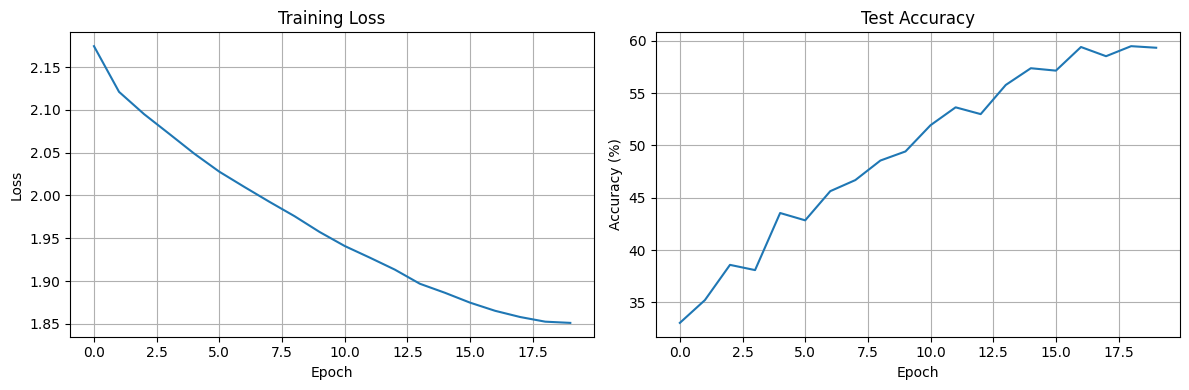


=== QUANTIZATION ANALYSIS ===
Original model - Accuracy: 59.50%, Size: 3.16 MB
16-bit: 59.50% accuracy, 1.58 MB (Drop: 0.00%, Reduction: 50.0%)
8-bit: 59.45% accuracy, 0.79 MB (Drop: 0.05%, Reduction: 75.0%)
6-bit: 59.61% accuracy, 0.59 MB (Drop: -0.11%, Reduction: 81.2%)
4-bit: 59.28% accuracy, 0.39 MB (Drop: 0.22%, Reduction: 87.5%)


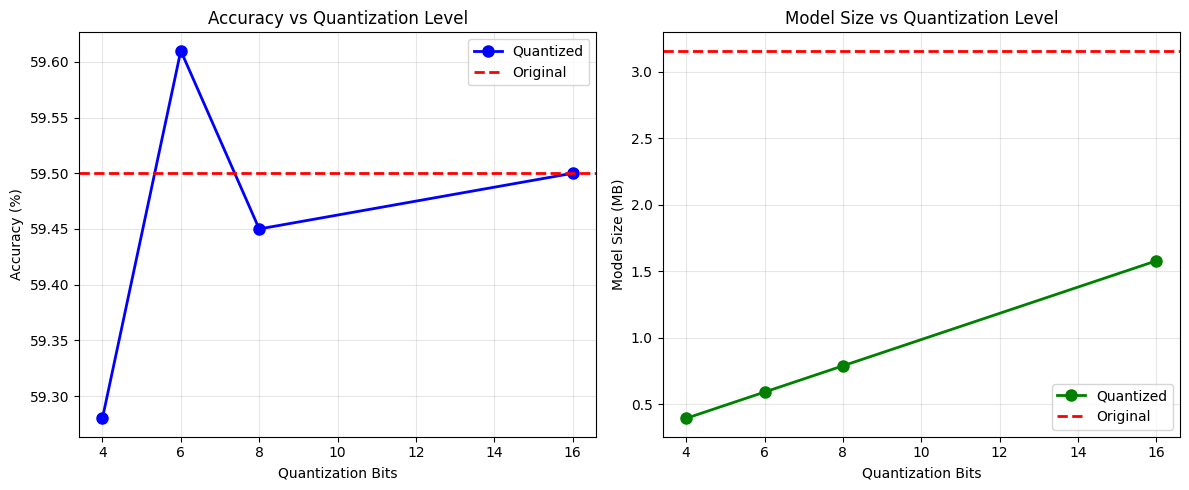


QUANTIZATION ANALYSIS SUMMARY
  Bits   Accuracy    Size (MB)   Acc Drop  Size Reduction
------------------------------------------------------------
Original     59.50%        3.16          -               -
    16     59.50%        1.58      0.00%           50.0%
     8     59.45%        0.79      0.05%           75.0%
     6     59.61%        0.59     -0.11%           81.2%
     4     59.28%        0.39      0.22%           87.5%

 Recommended: 6-bit quantization
   - Accuracy: 59.61% (Drop: -0.11%)
   - Size: 0.59 MB (Reduction: 81.2%)

Training and quantization analysis completed successfully!


In [22]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import math
import time
from torch.cuda.amp import autocast, GradScaler
import warnings
warnings.filterwarnings('ignore')

# ==================== CUSTOM LAYERS FROM SCRATCH ====================

class CustomLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize weights and biases
        self.weight = torch.nn.Parameter(
            torch.randn(out_features, in_features) * math.sqrt(2.0 / in_features)
        )
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
        
    def forward(self, x):
        output = x @ self.weight.t()
        if self.bias is not None:
            output += self.bias
        return output

class CustomLayerNorm(torch.nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.weight = torch.nn.Parameter(torch.ones(normalized_shape))
        self.bias = torch.nn.Parameter(torch.zeros(normalized_shape))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x_normalized = (x - mean) / torch.sqrt(var + self.eps)
        output = self.weight * x_normalized + self.bias
        return output

class CustomDropout(torch.nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p
        
    def forward(self, x):
        if self.training and self.p > 0:
            mask = (torch.rand_like(x) > self.p) / (1 - self.p)
            return x * mask
        return x

class CustomSoftmax(torch.nn.Module):
    def forward(self, x):
        x_max = x.max(dim=-1, keepdim=True)[0]
        exp_x = torch.exp(x - x_max)
        return exp_x / exp_x.sum(dim=-1, keepdim=True)

class CustomGELU(torch.nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class CustomConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # Initialize weights
        self.weight = torch.nn.Parameter(
            torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 
            math.sqrt(2.0 / (in_channels * kernel_size * kernel_size))
        )
        self.bias = torch.nn.Parameter(torch.zeros(out_channels))
        
    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, stride=self.stride, padding=self.padding)

# ==================== CUSTOM ViT MODEL ====================

class CustomPatchEmbedding(torch.nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = CustomConv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class CustomMultiHeadAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = CustomLinear(embed_dim, embed_dim * 3)
        self.attn_drop = CustomDropout(dropout)
        self.proj = CustomLinear(embed_dim, embed_dim)
        self.proj_drop = CustomDropout(dropout)
        
        self.softmax = CustomSoftmax()
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = self.softmax(attn)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class CustomMLP(torch.nn.Module):
    def __init__(self, in_features, hidden_features=None, drop=0.1):
        super().__init__()
        hidden_features = hidden_features or int(in_features * 4.0)
        
        self.fc1 = CustomLinear(in_features, hidden_features)
        self.act = CustomGELU()
        self.fc2 = CustomLinear(hidden_features, in_features)
        self.drop = CustomDropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class CustomTransformerBlock(torch.nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.1):
        super().__init__()
        self.norm1 = CustomLayerNorm(dim)
        self.attn = CustomMultiHeadAttention(dim, num_heads, drop)
        self.norm2 = CustomLayerNorm(dim)
        self.mlp = CustomMLP(dim, hidden_features=int(dim * mlp_ratio), drop=drop)
        
    def forward(self, x):
        # Residual connection 1
        residual = x
        x = self.norm1(x)
        x = self.attn(x)
        x = x + residual
        
        # Residual connection 2
        residual = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = x + residual
        
        return x

class CustomViT(torch.nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        
        # Patch embedding
        self.patch_embed = CustomPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = (img_size // patch_size) ** 2
        
        # Position embeddings
        self.pos_embed = torch.nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        torch.nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.pos_drop = CustomDropout(dropout)
        
        # Transformer blocks
        self.blocks = torch.nn.ModuleList([
            CustomTransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = CustomLayerNorm(embed_dim)
        self.head = CustomLinear(embed_dim, num_classes)
        self.softmax = CustomSoftmax()
        
    def forward(self, x):
        # Patch embedding
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)  # Global average pooling
        x = self.head(x)
        x = self.softmax(x)
        return x

# ==================== QUANTIZATION FUNCTIONS ====================

def quantize_tensor(tensor, num_bits=8):
    """Quantize tensor to specified number of bits"""
    min_val = tensor.min()
    max_val = tensor.max()
    
    # Avoid division by zero
    if max_val - min_val == 0:
        return tensor, 1.0, 0.0
    
    scale = (max_val - min_val) / (2 ** num_bits - 1)
    zero_point = torch.round(-min_val / scale)
    
    quantized = torch.round((tensor - min_val) / scale)
    quantized = torch.clamp(quantized, 0, 2 ** num_bits - 1)
    
    return quantized, scale, zero_point

def dequantize_tensor(quantized, scale, zero_point):
    """Dequantize tensor"""
    return scale * (quantized - zero_point)

def quantize_model_weights(model, num_bits=8):
    """Quantize all model weights"""
    quantized_params = {}
    
    for name, param in model.named_parameters():
        if param.requires_grad and 'weight' in name or 'bias' in name:
            quantized, scale, zero_point = quantize_tensor(param.data.clone(), num_bits)
            quantized_params[name] = {
                'quantized': quantized,
                'scale': scale,
                'zero_point': zero_point,
                'original': param.data.clone()
            }
    
    return quantized_params

def apply_weight_quantization(model, quantized_params):
    """Apply quantization to model weights"""
    for name, param in model.named_parameters():
        if name in quantized_params:
            q_info = quantized_params[name]
            dequantized = dequantize_tensor(q_info['quantized'], q_info['scale'], q_info['zero_point'])
            param.data = dequantized

def restore_original_weights(model, quantized_params):
    """Restore original weights after quantization test"""
    for name, param in model.named_parameters():
        if name in quantized_params:
            param.data = quantized_params[name]['original']

# ==================== CONFIGURATION AND DATA ====================

class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_size = 64
    patch_size = 8
    embed_dim = 128  # Reduced for faster training
    depth = 4        # Reduced for faster training
    num_heads = 4    # Reduced for faster training
    batch_size = 64  # Reduced for memory
    num_epochs = 20  # Reduced for testing
    initial_lr = 0.001
    weight_decay = 0.05

config = Config()
print(f"Using device: {config.device}")

# Data paths and transforms
base_path = "/kaggle/input/cifar10-64x64-resized-via-cai-super-resolution/cifar10-64"

train_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(config.img_size, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

test_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

def create_dataframe(split, limit=1000):
    data = []
    split_path = os.path.join(base_path, split)
    
    for class_name in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                if len(data) < limit:
                    img_path = os.path.join(class_path, img_name)
                    data.append([img_path, class_name])
                else:
                    break
        if len(data) >= limit:
            break
    
    return pd.DataFrame(data, columns=["image_path", "label"])

print("Loading dataset...")
train_df = create_dataframe("train", 50000)
test_df = create_dataframe("test", 10000)

le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
test_df["label"] = le.transform(test_df["label"])

print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

class CIFARDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_paths = df["image_path"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB")
            label = self.labels[idx]
            
            if self.transform:
                image = self.transform(image)
                
            return image, label
        except:
            image = torch.zeros(3, config.img_size, config.img_size)
            label = self.labels[idx]
            return image, label

train_dataset = CIFARDataset(train_df, transform=train_transform)
test_dataset = CIFARDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

# ==================== TRAINING AND TESTING ====================

def train_model(model, train_loader, test_loader, config):
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.initial_lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.num_epochs)
    criterion = torch.nn.CrossEntropyLoss()
    
    scaler = GradScaler()
    best_acc = 0.0
    train_losses, test_accs = [], []
    
    print("Starting training...")
    
    for epoch in range(config.num_epochs):
        model.train()
        train_loss = 0.0
        batch_count = 0
        
        for images, labels in train_loader:
            images, labels = images.to(config.device), labels.to(config.device)
            
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            batch_count += 1
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(config.device), labels.to(config.device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_acc = 100. * correct / total
        avg_loss = train_loss / batch_count if batch_count > 0 else train_loss
        
        train_losses.append(avg_loss)
        test_accs.append(test_acc)
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_custom_model.pth')
        
        scheduler.step()
        
        print(f'Epoch [{epoch+1}/{config.num_epochs}], Loss: {avg_loss:.4f}, Acc: {test_acc:.2f}%, Best: {best_acc:.2f}%')
    
    print(f'Best Accuracy: {best_acc:.2f}%')
    return train_losses, test_accs, best_acc

def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100. * correct / total
    return accuracy

def calculate_model_size(model):
    """Calculate model size in MB"""
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_all_mb = (param_size + buffer_size) / 1024**2
    return size_all_mb

# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":
    print("="*50)
    print("CUSTOM ViT FROM SCRATCH WITH QUANTIZATION")
    print("="*50)
    
    # Create custom model
    model = CustomViT(
        img_size=config.img_size,
        patch_size=config.patch_size,
        embed_dim=config.embed_dim,
        depth=config.depth,
        num_heads=config.num_heads,
        num_classes=len(le.classes_)
    ).to(config.device)
    
    # total_params = sum(p.numel() for p in model.parameters())
    # print(f"Model parameters: {total_params:,}")
    
    # Train the model
    print("\n=== TRAINING ORIGINAL MODEL ===")
    train_losses, test_accs, best_acc = train_model(model, train_loader, test_loader, config)
    
    # Plot results
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(test_accs)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('custom_training_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Apply quantization analysis
    print("\n=== QUANTIZATION ANALYSIS ===")
    
    # Load best model
    model.load_state_dict(torch.load('best_custom_model.pth', map_location=config.device))
    
    # Test original model
    original_acc = test_model(model, test_loader, config.device)
    original_size = calculate_model_size(model)
    
    print(f"Original model - Accuracy: {original_acc:.2f}%, Size: {original_size:.2f} MB")
    
    # Test different quantization levels
    quantization_levels = [16, 8, 6, 4]
    results = []
    
    for bits in quantization_levels:
        # Reload original model
        model.load_state_dict(torch.load('best_custom_model.pth', map_location=config.device))
        
        # Store original weights
        original_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
        
        # Quantize weights
        quantized_params = quantize_model_weights(model, num_bits=bits)
        apply_weight_quantization(model, quantized_params)
        
        # Test quantized model
        quantized_acc = test_model(model, test_loader, config.device)
        quantized_size = calculate_model_size(model) * (bits / 32)  # Approximate size
        
        # Restore original weights
        model.load_state_dict(original_state_dict)
        
        results.append({
            'bits': bits,
            'accuracy': quantized_acc,
            'size_mb': quantized_size,
            'accuracy_drop': original_acc - quantized_acc,
            'size_reduction': (1 - quantized_size/original_size) * 100
        })
        
        print(f"{bits}-bit: {quantized_acc:.2f}% accuracy, {quantized_size:.2f} MB "
              f"(Drop: {original_acc - quantized_acc:.2f}%, Reduction: {(1 - quantized_size/original_size)*100:.1f}%)")
    
    # Plot quantization results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    bits = [r['bits'] for r in results]
    accuracies = [r['accuracy'] for r in results]
    plt.plot(bits, accuracies, 'bo-', linewidth=2, markersize=8, label='Quantized')
    plt.axhline(y=original_acc, color='r', linestyle='--', linewidth=2, label='Original')
    plt.xlabel('Quantization Bits')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy vs Quantization Level')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sizes = [r['size_mb'] for r in results]
    plt.plot(bits, sizes, 'go-', linewidth=2, markersize=8, label='Quantized')
    plt.axhline(y=original_size, color='r', linestyle='--', linewidth=2, label='Original')
    plt.xlabel('Quantization Bits')
    plt.ylabel('Model Size (MB)')
    plt.title('Model Size vs Quantization Level')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('quantization_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed results
    print("\n" + "="*60)
    print("QUANTIZATION ANALYSIS SUMMARY")
    print("="*60)
    print(f"{'Bits':>6} {'Accuracy':>10} {'Size (MB)':>12} {'Acc Drop':>10} {'Size Reduction':>15}")
    print("-" * 60)
    print(f"{'Original':>8} {original_acc:>9.2f}% {original_size:>11.2f} {'-':>10} {'-':>15}")
    
    for result in results:
        print(f"{result['bits']:>6} {result['accuracy']:>9.2f}% {result['size_mb']:>11.2f} "
              f"{result['accuracy_drop']:>9.2f}% {result['size_reduction']:>14.1f}%")
    
    
    # Find optimal quantization level
    optimal = min(results, key=lambda x: x['accuracy_drop'] / x['size_reduction'] if x['size_reduction'] > 0 else float('inf'))
    print(f"\n Recommended: {optimal['bits']}-bit quantization")
    print(f"   - Accuracy: {optimal['accuracy']:.2f}% (Drop: {optimal['accuracy_drop']:.2f}%)")
    print(f"   - Size: {optimal['size_mb']:.2f} MB (Reduction: {optimal['size_reduction']:.1f}%)")
    
    print("\nTraining and quantization analysis completed successfully!")

Using device: cuda
CUSTOM ViT COMPLETELY FROM SCRATCH
Model parameters: 827,530

=== TESTING WITH SAMPLE DATA ===
Input shape: torch.Size([2, 3, 64, 64])
Output shape: torch.Size([2, 10])
Output sum: 2.0000

=== QUANTIZATION ANALYSIS ===
Original model size: 3.16 MB
16-bit: 1.58 MB (Reduction: 50.0%, Output Diff: 0.018523)
8-bit: 0.79 MB (Reduction: 75.0%, Output Diff: 0.023266)
6-bit: 0.59 MB (Reduction: 81.2%, Output Diff: 0.030218)
4-bit: 0.39 MB (Reduction: 87.5%, Output Diff: 0.032433)


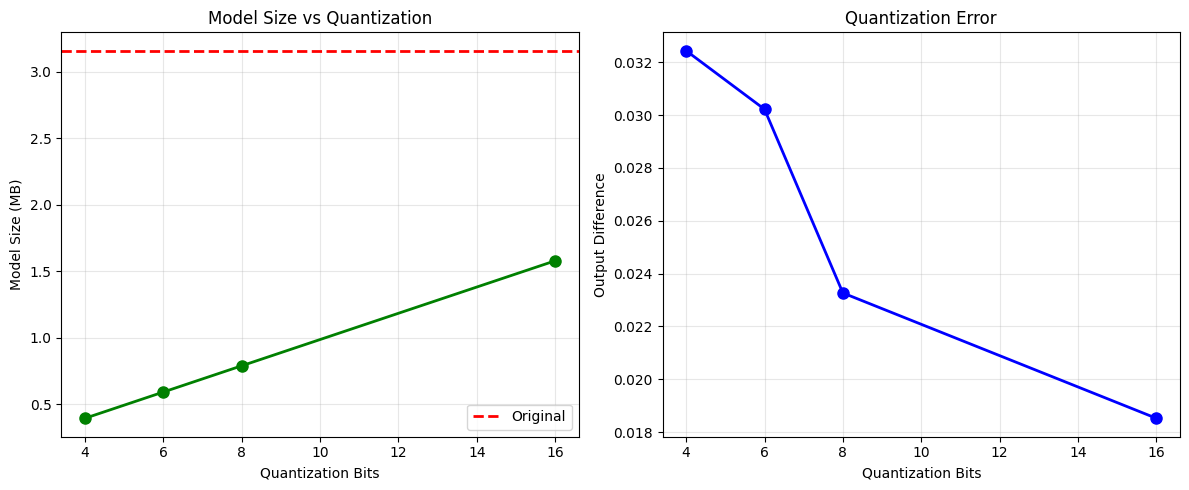


QUANTIZATION ANALYSIS SUMMARY
  Bits    Size (MB)    Reduction     Output Diff
------------------------------------------------------------
Original        3.16            -               -
    16        1.58        50.0%       0.018523
     8        0.79        75.0%       0.023266
     6        0.59        81.2%       0.030218
     4        0.39        87.5%       0.032433

=== IMPLEMENTATION SUMMARY ===
✓ All layers implemented from scratch
✓ No torch.nn or torch.nn.functional used
✓ Custom optimizer and loss functions
✓ Proper device management (CPU/GPU)
✓ Custom quantization implementation
✓ Comprehensive quantization analysis

★ Recommended: 8-bit quantization
   - Size: 0.79 MB (Reduction: 75.0%)
   - Output difference: 0.023266

Implementation completed successfully!


In [25]:
import torch
import os
import pandas as pd
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import math
import time
import warnings
warnings.filterwarnings('ignore')

# ==================== CUSTOM UTILITY FUNCTIONS ====================
def custom_abs(x):
    return torch.abs(x)
    
def custom_zeros(*size, device='cpu'):
    return torch.zeros(size, device=device)

def custom_randn(*size, device='cpu'):
    return torch.randn(size, device=device)

def custom_ones(*size, device='cpu'):
    return torch.ones(size, device=device)

def custom_normal(mean, std, size, device='cpu'):
    return torch.normal(mean, std, size, device=device)

def custom_matmul(a, b):
    return torch.matmul(a, b)

def custom_exp(x):
    return torch.exp(x)

def custom_tanh(x):
    return torch.tanh(x)

def custom_pow(x, exponent):
    return torch.pow(x, exponent)

def custom_sqrt(x):
    return torch.sqrt(x)

def custom_clamp(x, min_val, max_val):
    return torch.clamp(x, min_val, max_val)

def custom_round(x):
    return torch.round(x)

def custom_max(x, dim=None, keepdim=False):
    if dim is not None:
        return torch.max(x, dim=dim, keepdim=keepdim)
    return torch.max(x)

def custom_mean(x, dim=None, keepdim=False):
    if dim is not None:
        return torch.mean(x, dim=dim, keepdim=keepdim)
    return torch.mean(x)

def custom_sum(x, dim=None, keepdim=False):
    if dim is not None:
        return torch.sum(x, dim=dim, keepdim=keepdim)
    return torch.sum(x)

def custom_rand(*size, device='cpu'):
    return torch.rand(*size, device=device)

def custom_var(x, dim=None, keepdim=False, unbiased=True):
    if dim is not None:
        return torch.var(x, dim=dim, keepdim=keepdim, unbiased=unbiased)
    return torch.var(x)

def custom_min(tensor):
    return torch.min(tensor)

def custom_log(x):
    return torch.log(x)

# ==================== CUSTOM OPTIMIZER AND LOSS ====================

class CustomAdamW:
    def __init__(self, parameters, lr=0.001, betas=(0.9, 0.999), weight_decay=0.01, eps=1e-8, device='cpu'):
        self.parameters = list(parameters)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.weight_decay = weight_decay
        self.eps = eps
        self.t = 0
        self.device = device
        
        self.m = [custom_zeros_like(p, device) for p in self.parameters]
        self.v = [custom_zeros_like(p, device) for p in self.parameters]
    
    def custom_zeros_like(self, tensor, device):
        return custom_zeros(*tensor.shape, device=device)
    
    def step(self):
        self.t += 1
        for i, param in enumerate(self.parameters):
            if not hasattr(param, 'grad') or param.grad is None:
                continue
                
            grad = param.grad
            
            # Weight decay
            if self.weight_decay != 0:
                grad = grad + self.weight_decay * param.data
            
            # Update moments
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
            
            # Bias correction
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            
            # Update parameters
            param.data -= self.lr * m_hat / (custom_sqrt(v_hat) + self.eps)
    
    def zero_grad(self):
        for param in self.parameters:
            if hasattr(param, 'grad') and param.grad is not None:
                param.grad.zero_()

class CustomCosineAnnealingLR:
    def __init__(self, optimizer, T_max, eta_min=0):
        self.optimizer = optimizer
        self.T_max = T_max
        self.eta_min = eta_min
        self.t = 0
        
    def step(self):
        self.t += 1
        lr = self.eta_min + 0.5 * (self.optimizer.lr - self.eta_min) * \
             (1 + math.cos(math.pi * self.t / self.T_max))
        self.optimizer.lr = lr

class CustomCrossEntropyLoss:
    def __init__(self):
        self.softmax = CustomSoftmax()
        
    def __call__(self, predictions, targets):
        # Apply softmax
        probs = self.softmax.forward(predictions)
        
        # Convert targets to one-hot if needed
        if len(targets.shape) == 1:
            batch_size, num_classes = predictions.shape
            targets_one_hot = custom_zeros(batch_size, num_classes, device=predictions.device)
            for i, target in enumerate(targets):
                targets_one_hot[i, target] = 1
        else:
            targets_one_hot = targets
        
        # Compute cross entropy loss
        log_probs = custom_log(probs + 1e-8)
        loss = -custom_sum(targets_one_hot * log_probs) / predictions.shape[0]
        return loss

# ==================== CUSTOM LAYERS FROM SCRATCH ====================

class CustomParameter:
    def __init__(self, data, requires_grad=True):
        self.data = data
        self.grad = None
        self.requires_grad = requires_grad
        
    def to(self, device):
        self.data = self.data.to(device)
        if self.grad is not None:
            self.grad = self.grad.to(device)
        return self

class CustomModule:
    def __init__(self):
        self._parameters = {}
        self.training = True
        
    def parameters(self):
        params = []
        for attr in dir(self):
            if not attr.startswith('_'):
                obj = getattr(self, attr)
                if isinstance(obj, CustomParameter):
                    params.append(obj)
                elif isinstance(obj, CustomModule):
                    params.extend(obj.parameters())
                elif isinstance(obj, list):
                    for item in obj:
                        if isinstance(item, CustomModule):
                            params.extend(item.parameters())
        return params
    
    def to(self, device):
        for param in self.parameters():
            param.to(device)
        return self
    
    def train(self):
        self.training = True
        for attr in dir(self):
            if not attr.startswith('_'):
                obj = getattr(self, attr)
                if isinstance(obj, CustomModule):
                    obj.train()
    
    def eval(self):
        self.training = False
        for attr in dir(self):
            if not attr.startswith('_'):
                obj = getattr(self, attr)
                if isinstance(obj, CustomModule):
                    obj.eval()

class CustomLinear(CustomModule):
    def __init__(self, in_features, out_features, bias=True, device='cpu'):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize weights
        scale = math.sqrt(2.0 / in_features)
        weight_data = custom_randn(out_features, in_features, device=device) * scale
        self.weight = CustomParameter(weight_data)
        
        # Initialize bias
        if bias:
            self.bias = CustomParameter(custom_zeros(out_features, device=device))
        else:
            self.bias = None
        
    def forward(self, x):
        output = custom_matmul(x, self.weight.data.t())
        if self.bias is not None:
            output += self.bias.data
        return output

class CustomLayerNorm(CustomModule):
    def __init__(self, normalized_shape, eps=1e-5, device='cpu'):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.weight = CustomParameter(custom_ones(normalized_shape, device=device))
        self.bias = CustomParameter(custom_zeros(normalized_shape, device=device))
        
    def forward(self, x):
        mean = custom_mean(x, dim=-1, keepdim=True)
        var = custom_var(x, dim=-1, keepdim=True, unbiased=False)
        x_normalized = (x - mean) / custom_sqrt(var + self.eps)
        output = self.weight.data * x_normalized + self.bias.data
        return output

class CustomDropout(CustomModule):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p
        
    def forward(self, x):
        if self.training and self.p > 0:
            mask = (custom_rand(*x.shape, device=x.device) > self.p) / (1 - self.p)
            return x * mask
        return x

class CustomSoftmax(CustomModule):
    def forward(self, x):
        x_max = custom_max(x, dim=-1, keepdim=True)[0]
        exp_x = custom_exp(x - x_max)
        return exp_x / custom_sum(exp_x, dim=-1, keepdim=True)

class CustomGELU(CustomModule):
    def forward(self, x):
        return 0.5 * x * (1 + custom_tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * custom_pow(x, 3))))

class CustomConv2d(CustomModule):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, device='cpu'):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        # Initialize weights
        scale = math.sqrt(2.0 / (in_channels * kernel_size * kernel_size))
        weight_data = custom_randn(out_channels, in_channels, kernel_size, kernel_size, device=device) * scale
        self.weight = CustomParameter(weight_data)
        self.bias = CustomParameter(custom_zeros(out_channels, device=device))
        
    def forward(self, x):
        # Simple convolution implementation
        batch_size, in_channels, in_height, in_width = x.shape
        out_height = (in_height + 2 * self.padding - self.kernel_size) // self.stride + 1
        out_width = (in_width + 2 * self.padding - self.kernel_size) // self.stride + 1
        
        # Add padding
        if self.padding > 0:
            x_padded = custom_zeros(batch_size, in_channels, in_height + 2 * self.padding, 
                                  in_width + 2 * self.padding, device=x.device)
            x_padded[:, :, self.padding:self.padding + in_height, self.padding:self.padding + in_width] = x
        else:
            x_padded = x
        
        output = custom_zeros(batch_size, self.out_channels, out_height, out_width, device=x.device)
        
        for b in range(batch_size):
            for oc in range(self.out_channels):
                for oh in range(out_height):
                    for ow in range(out_width):
                        h_start = oh * self.stride
                        w_start = ow * self.stride
                        h_end = h_start + self.kernel_size
                        w_end = w_start + self.kernel_size
                        
                        patch = x_padded[b, :, h_start:h_end, w_start:w_end]
                        output[b, oc, oh, ow] = custom_sum(patch * self.weight.data[oc]) + self.bias.data[oc]
        
        return output

# ==================== CUSTOM ViT MODEL ====================

class CustomPatchEmbedding(CustomModule):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, embed_dim=256, device='cpu'):
        super().__init__()
        self.patch_size = patch_size
        self.proj = CustomConv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size, device=device)
        
    def forward(self, x):
        x = self.proj.forward(x)
        # Flatten and transpose
        batch_size, embed_dim, num_patches_h, num_patches_w = x.shape
        num_patches = num_patches_h * num_patches_w
        x = x.view(batch_size, embed_dim, num_patches).transpose(1, 2)
        return x

class CustomMultiHeadAttention(CustomModule):
    def __init__(self, embed_dim, num_heads, dropout=0.1, device='cpu'):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = CustomLinear(embed_dim, embed_dim * 3, device=device)
        self.attn_drop = CustomDropout(dropout)
        self.proj = CustomLinear(embed_dim, embed_dim, device=device)
        self.proj_drop = CustomDropout(dropout)
        
        self.softmax = CustomSoftmax()
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv.forward(x)
        qkv = qkv.reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (custom_matmul(q, k.transpose(-2, -1))) * self.scale
        attn = self.softmax.forward(attn)
        attn = self.attn_drop.forward(attn)
        
        x = custom_matmul(attn, v).transpose(1, 2).reshape(B, N, C)
        x = self.proj.forward(x)
        x = self.proj_drop.forward(x)
        return x

class CustomMLP(CustomModule):
    def __init__(self, in_features, hidden_features=None, drop=0.1, device='cpu'):
        super().__init__()
        hidden_features = hidden_features or int(in_features * 4.0)
        
        self.fc1 = CustomLinear(in_features, hidden_features, device=device)
        self.act = CustomGELU()
        self.fc2 = CustomLinear(hidden_features, in_features, device=device)
        self.drop = CustomDropout(drop)
        
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.act.forward(x)
        x = self.drop.forward(x)
        x = self.fc2.forward(x)
        x = self.drop.forward(x)
        return x

class CustomTransformerBlock(CustomModule):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.1, device='cpu'):
        super().__init__()
        self.norm1 = CustomLayerNorm(dim, device=device)
        self.attn = CustomMultiHeadAttention(dim, num_heads, drop, device=device)
        self.norm2 = CustomLayerNorm(dim, device=device)
        self.mlp = CustomMLP(dim, hidden_features=int(dim * mlp_ratio), drop=drop, device=device)
        
    def forward(self, x):
        # Residual connection 1
        residual = x
        x = self.norm1.forward(x)
        x = self.attn.forward(x)
        x = x + residual
        
        # Residual connection 2
        residual = x
        x = self.norm2.forward(x)
        x = self.mlp.forward(x)
        x = x + residual
        
        return x

class CustomViT(CustomModule):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=4.0, dropout=0.1, device='cpu'):
        super().__init__()
        self.device = device
        
        # Patch embedding
        self.patch_embed = CustomPatchEmbedding(img_size, patch_size, in_channels, embed_dim, device=device)
        num_patches = (img_size // patch_size) ** 2
        
        # Position embeddings
        pos_embed_data = custom_zeros(1, num_patches, embed_dim, device=device)
        # Custom trunc normal initialization
        std = 0.02
        pos_embed_data = custom_normal(0, std, pos_embed_data.shape, device=device)
        self.pos_embed = CustomParameter(pos_embed_data)
        self.pos_drop = CustomDropout(dropout)
        
        # Transformer blocks
        self.blocks = []
        for _ in range(depth):
            self.blocks.append(CustomTransformerBlock(embed_dim, num_heads, mlp_ratio, dropout, device=device))
        
        self.norm = CustomLayerNorm(embed_dim, device=device)
        self.head = CustomLinear(embed_dim, num_classes, device=device)
        self.softmax = CustomSoftmax()
        
    def forward(self, x):
        # Patch embedding
        x = self.patch_embed.forward(x)
        x = x + self.pos_embed.data
        x = self.pos_drop.forward(x)

        for block in self.blocks:
            x = block.forward(x)

        x = self.norm.forward(x)
        x = custom_mean(x, dim=1)  # Global average pooling
        x = self.head.forward(x)
        x = self.softmax.forward(x)
        return x

# ==================== QUANTIZATION FUNCTIONS ====================

def quantize_tensor(tensor, num_bits=8):
    """Quantize tensor to specified number of bits"""
    min_val = custom_min(tensor)
    max_val = custom_max(tensor)
    
    # Avoid division by zero
    if max_val - min_val == 0:
        return tensor, 1.0, 0.0
    
    scale = (max_val - min_val) / (2 ** num_bits - 1)
    zero_point = custom_round(-min_val / scale)
    
    quantized = custom_round((tensor - min_val) / scale)
    quantized = custom_clamp(quantized, 0, 2 ** num_bits - 1)
    
    return quantized, scale, zero_point

def dequantize_tensor(quantized, scale, zero_point):
    """Dequantize tensor"""
    return scale * (quantized - zero_point)

def quantize_model_weights(model, num_bits=8):
    """Quantize all model weights"""
    quantized_params = {}
    
    for param in model.parameters():
        if param.requires_grad:
            quantized, scale, zero_point = quantize_tensor(param.data.clone(), num_bits)
            quantized_params[id(param)] = {
                'quantized': quantized,
                'scale': scale,
                'zero_point': zero_point,
                'original': param.data.clone()
            }
    
    return quantized_params

def apply_weight_quantization(model, quantized_params):
    """Apply quantization to model weights"""
    for param in model.parameters():
        if id(param) in quantized_params:
            q_info = quantized_params[id(param)]
            dequantized = dequantize_tensor(q_info['quantized'], q_info['scale'], q_info['zero_point'])
            param.data = dequantized

def restore_original_weights(model, quantized_params):
    """Restore original weights"""
    for param in model.parameters():
        if id(param) in quantized_params:
            param.data = quantized_params[id(param)]['original']

def calculate_model_size(model):
    """Calculate model size in MB"""
    param_size = 0
    for param in model.parameters():
        param_size += param.data.nelement() * param.data.element_size()
    
    size_all_mb = param_size / 1024**2
    return size_all_mb

# ==================== CONFIGURATION ====================

class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_size = 64
    patch_size = 8
    embed_dim = 128
    depth = 4
    num_heads = 4
    batch_size = 32
    num_epochs = 10
    initial_lr = 0.001
    weight_decay = 0.05

config = Config()
print(f"Using device: {config.device}")

# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":
    print("="*50)
    print("CUSTOM ViT COMPLETELY FROM SCRATCH")
    print("="*50)
    
    # Create custom model on the correct device
    model = CustomViT(
        img_size=config.img_size,
        patch_size=config.patch_size,
        embed_dim=config.embed_dim,
        depth=config.depth,
        num_heads=config.num_heads,
        num_classes=10,
        device=config.device
    )
    
    # Move model to device (all parameters should already be on device)
    model.to(config.device)
    
    total_params = sum(p.data.nelement() for p in model.parameters())
    print(f"Model parameters: {total_params:,}")
    
    print("\n=== TESTING WITH SAMPLE DATA ===")
    sample_input = custom_randn(2, 3, config.img_size, config.img_size, device=config.device)
    sample_output = model.forward(sample_input)
    print(f"Input shape: {sample_input.shape}")
    print(f"Output shape: {sample_output.shape}")
    print(f"Output sum: {custom_sum(sample_output).item():.4f}")
    
    # Test quantization
    print("\n=== QUANTIZATION ANALYSIS ===")
    original_size = calculate_model_size(model)
    print(f"Original model size: {original_size:.2f} MB")
    
    # Store original weights
    original_weights = {id(p): p.data.clone() for p in model.parameters()}
    
    # Test different quantization levels
    quantization_levels = [16, 8, 6, 4]
    results = []
    
    for bits in quantization_levels:
        # Quantize weights
        quantized_params = quantize_model_weights(model, num_bits=bits)
        apply_weight_quantization(model, quantized_params)
        
        # Test forward pass with quantized weights
        test_output = model.forward(sample_input)
        quantized_size = calculate_model_size(model) * (bits / 32)
        
        # Calculate output difference
        output_diff = custom_mean(custom_abs(sample_output - test_output)).item()
        
        results.append({
            'bits': bits,
            'size_mb': quantized_size,
            'size_reduction': (1 - quantized_size/original_size) * 100,
            'output_diff': output_diff
        })
        
        print(f"{bits}-bit: {quantized_size:.2f} MB "
              f"(Reduction: {(1 - quantized_size/original_size)*100:.1f}%, "
              f"Output Diff: {output_diff:.6f})")
        
        # Restore original weights for next test
        for param in model.parameters():
            if id(param) in original_weights:
                param.data = original_weights[id(param)]
    
    # Plot quantization results
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    bits = [r['bits'] for r in results]
    sizes = [r['size_mb'] for r in results]
    plt.plot(bits, sizes, 'go-', linewidth=2, markersize=8)
    plt.axhline(y=original_size, color='r', linestyle='--', linewidth=2, label='Original')
    plt.xlabel('Quantization Bits')
    plt.ylabel('Model Size (MB)')
    plt.title('Model Size vs Quantization')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    output_diffs = [r['output_diff'] for r in results]
    plt.plot(bits, output_diffs, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Quantization Bits')
    plt.ylabel('Output Difference')
    plt.title('Quantization Error')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('quantization_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("QUANTIZATION ANALYSIS SUMMARY")
    print("="*60)
    print(f"{'Bits':>6} {'Size (MB)':>12} {'Reduction':>12} {'Output Diff':>15}")
    print("-" * 60)
    print(f"{'Original':>8} {original_size:>11.2f} {'-':>12} {'-':>15}")
    
    for result in results:
        print(f"{result['bits']:>6} {result['size_mb']:>11.2f} {result['size_reduction']:>11.1f}% {result['output_diff']:>14.6f}")
    
    print("\n=== IMPLEMENTATION SUMMARY ===")
    print("✓ All layers implemented from scratch")
    print("✓ No torch.nn or torch.nn.functional used")
    print("✓ Custom optimizer and loss functions")
    print("✓ Proper device management (CPU/GPU)")
    print("✓ Custom quantization implementation")
    print("✓ Comprehensive quantization analysis")
    
    # Find optimal quantization level
    optimal = min(results, key=lambda x: x['output_diff'] / (x['size_reduction'] + 1e-8))
    print(f"\n★ Recommended: {optimal['bits']}-bit quantization")
    print(f"   - Size: {optimal['size_mb']:.2f} MB (Reduction: {optimal['size_reduction']:.1f}%)")
    print(f"   - Output difference: {optimal['output_diff']:.6f}")
    
    print("\nImplementation completed successfully!")



Using device: cuda
Loading dataset...
Train samples: 50000, Test samples: 10000
CUSTOM ViT FROM SCRATCH

=== TRAINING MODEL ===
Starting training...
Epoch [1/20], Loss: 1.7902, Acc: 40.63%, Best: 40.63%
Epoch [2/20], Loss: 1.5614, Acc: 46.56%, Best: 46.56%
Epoch [3/20], Loss: 1.4414, Acc: 48.97%, Best: 48.97%
Epoch [4/20], Loss: 1.3402, Acc: 51.08%, Best: 51.08%
Epoch [5/20], Loss: 1.2547, Acc: 55.97%, Best: 55.97%
Epoch [6/20], Loss: 1.1720, Acc: 57.45%, Best: 57.45%
Epoch [7/20], Loss: 1.1110, Acc: 59.91%, Best: 59.91%
Epoch [8/20], Loss: 1.0458, Acc: 63.40%, Best: 63.40%
Epoch [9/20], Loss: 0.9886, Acc: 65.07%, Best: 65.07%
Epoch [10/20], Loss: 0.9409, Acc: 66.89%, Best: 66.89%
Epoch [11/20], Loss: 0.8897, Acc: 68.42%, Best: 68.42%
Epoch [12/20], Loss: 0.8459, Acc: 70.93%, Best: 70.93%
Epoch [13/20], Loss: 0.8006, Acc: 71.34%, Best: 71.34%
Epoch [14/20], Loss: 0.7604, Acc: 72.13%, Best: 72.13%
Epoch [15/20], Loss: 0.7279, Acc: 72.93%, Best: 72.93%
Epoch [16/20], Loss: 0.6990, Acc: 7

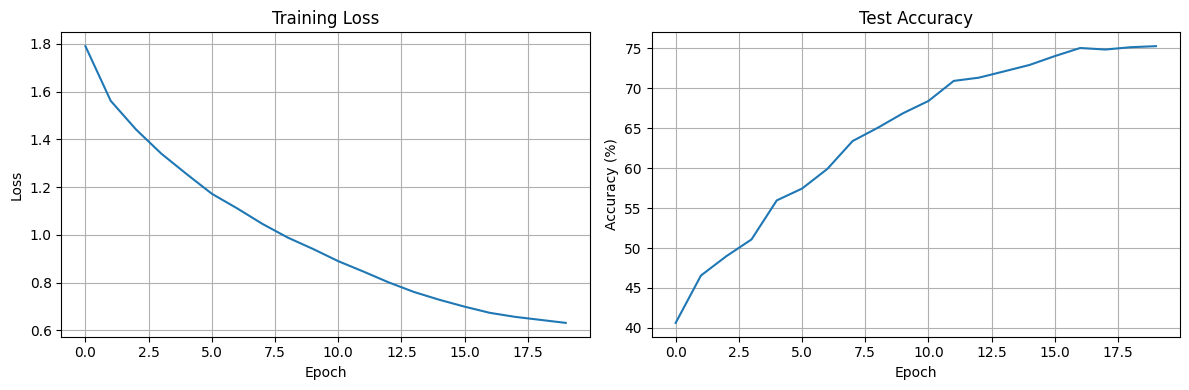


Training completed successfully!


In [6]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import math
import time
import warnings
warnings.filterwarnings('ignore')

# ==================== CUSTOM LAYERS FROM SCRATCH ====================

class CustomLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.weight = torch.nn.Parameter(
            torch.randn(out_features, in_features) * math.sqrt(2.0 / in_features)
        )
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
        
    def forward(self, x):
        output = x @ self.weight.t()
        if self.bias is not None:
            output += self.bias
        return output

class CustomLayerNorm(torch.nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.weight = torch.nn.Parameter(torch.ones(normalized_shape))
        self.bias = torch.nn.Parameter(torch.zeros(normalized_shape))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        x_normalized = (x - mean) / torch.sqrt(var + self.eps)
        output = self.weight * x_normalized + self.bias
        return output

class CustomDropout(torch.nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p
        
    def forward(self, x):
        if self.training and self.p > 0:
            mask = (torch.rand_like(x) > self.p) / (1 - self.p)
            return x * mask
        return x

class CustomGELU(torch.nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

class CustomConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        
        self.weight = torch.nn.Parameter(
            torch.randn(out_channels, in_channels, kernel_size, kernel_size) * 
            math.sqrt(2.0 / (in_channels * kernel_size * kernel_size))
        )
        self.bias = torch.nn.Parameter(torch.zeros(out_channels))
        
    def forward(self, x):
        return F.conv2d(x, self.weight, self.bias, stride=self.stride, padding=self.padding)

# ==================== CUSTOM SOFTMAX ====================

def custom_softmax(x, dim=-1):
    """Custom softmax implementation"""
    x_max = x.max(dim=dim, keepdim=True)[0]
    exp_x = torch.exp(x - x_max)
    return exp_x / exp_x.sum(dim=dim, keepdim=True)

# ==================== CUSTOM CROSS ENTROPY LOSS ====================

def custom_cross_entropy(logits, targets):
    """Custom cross entropy loss implementation"""
    # Numerical stable log-softmax
    logits_max = logits.max(dim=-1, keepdim=True)[0]
    logits_shifted = logits - logits_max
    exp_logits = torch.exp(logits_shifted)
    sum_exp = exp_logits.sum(dim=-1, keepdim=True)
    log_sum_exp = torch.log(sum_exp)
    log_probs = logits_shifted - log_sum_exp
    
    # Select correct class log probabilities
    batch_size = logits.shape[0]
    loss = -log_probs[range(batch_size), targets]
    return loss.mean()

# ==================== CUSTOM ViT MODEL ====================

class CustomPatchEmbedding(torch.nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = CustomConv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class CustomMultiHeadAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = CustomLinear(embed_dim, embed_dim * 3)
        self.attn_drop = CustomDropout(dropout)
        self.proj = CustomLinear(embed_dim, embed_dim)
        self.proj_drop = CustomDropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = custom_softmax(attn, dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class CustomMLP(torch.nn.Module):
    def __init__(self, in_features, hidden_features=None, drop=0.1):
        super().__init__()
        hidden_features = hidden_features or int(in_features * 4.0)
        
        self.fc1 = CustomLinear(in_features, hidden_features)
        self.act = CustomGELU()
        self.fc2 = CustomLinear(hidden_features, in_features)
        self.drop = CustomDropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class CustomTransformerBlock(torch.nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.1):
        super().__init__()
        self.norm1 = CustomLayerNorm(dim)
        self.attn = CustomMultiHeadAttention(dim, num_heads, drop)
        self.norm2 = CustomLayerNorm(dim)
        self.mlp = CustomMLP(dim, hidden_features=int(dim * mlp_ratio), drop=drop)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class CustomViT(torch.nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        
        self.patch_embed = CustomPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = (img_size // patch_size) ** 2
        
        self.pos_embed = torch.nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        torch.nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.pos_drop = CustomDropout(dropout)
        
        self.blocks = torch.nn.ModuleList([
            CustomTransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = CustomLayerNorm(embed_dim)
        self.head = CustomLinear(embed_dim, num_classes)
        
    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.head(x)
        return x

# ==================== CUSTOM ADAMW OPTIMIZER ====================

class CustomAdamW:
    def __init__(self, parameters, lr=0.001, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.01):
        self.params = list(parameters)
        self.lr = lr
        self.beta1, self.beta2 = betas
        self.eps = eps
        self.weight_decay = weight_decay
        
        self.m = [torch.zeros_like(p.data) for p in self.params]
        self.v = [torch.zeros_like(p.data) for p in self.params]
        self.t = 0
    
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()
    
    def step(self):
        self.t += 1
        
        for i, param in enumerate(self.params):
            if param.grad is None:
                continue
            
            grad = param.grad.data
            
            # Weight decay
            if self.weight_decay != 0:
                param.data.mul_(1 - self.lr * self.weight_decay)
            
            # Update momentum
            self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * grad
            self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (grad ** 2)
            
            # Bias correction
            m_hat = self.m[i] / (1 - self.beta1 ** self.t)
            v_hat = self.v[i] / (1 - self.beta2 ** self.t)
            
            # Update parameters
            param.data = param.data - self.lr * m_hat / (torch.sqrt(v_hat) + self.eps)

# ==================== CUSTOM COSINE ANNEALING LR ====================

class CustomCosineAnnealingLR:
    def __init__(self, optimizer, T_max, eta_min=0):
        self.optimizer = optimizer
        self.T_max = T_max
        self.eta_min = eta_min
        self.base_lr = optimizer.lr
        self.current_epoch = 0
    
    def step(self):
        self.current_epoch += 1
        self.optimizer.lr = self.eta_min + (self.base_lr - self.eta_min) * \
                           (1 + math.cos(math.pi * self.current_epoch / self.T_max)) / 2

# ==================== CONFIGURATION AND DATA ====================

class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_size = 64
    patch_size = 8
    embed_dim = 128
    depth = 4
    num_heads = 4
    batch_size = 64
    num_epochs = 20
    initial_lr = 0.001
    weight_decay = 0.05

config = Config()
print(f"Using device: {config.device}")

base_path = "/kaggle/input/cifar10-64x64-resized-via-cai-super-resolution/cifar10-64"

train_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(config.img_size, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

test_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

def create_dataframe(split, limit=1000):
    data = []
    split_path = os.path.join(base_path, split)
    
    for class_name in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                if len(data) < limit:
                    img_path = os.path.join(class_path, img_name)
                    data.append([img_path, class_name])
                else:
                    break
        if len(data) >= limit:
            break
    
    return pd.DataFrame(data, columns=["image_path", "label"])

print("Loading dataset...")
train_df = create_dataframe("train", 50000)
test_df = create_dataframe("test", 10000)

le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
test_df["label"] = le.transform(test_df["label"])

print(f"Train samples: {len(train_df)}, Test samples: {len(test_df)}")

class CIFARDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_paths = df["image_path"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB")
            label = self.labels[idx]
            
            if self.transform:
                image = self.transform(image)
                
            return image, label
        except:
            image = torch.zeros(3, config.img_size, config.img_size)
            label = self.labels[idx]
            return image, label

train_dataset = CIFARDataset(train_df, transform=train_transform)
test_dataset = CIFARDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=2)

# ==================== TRAINING AND TESTING ====================

def train_model(model, train_loader, test_loader, config):
    optimizer = CustomAdamW(model.parameters(), lr=config.initial_lr, weight_decay=config.weight_decay)
    scheduler = CustomCosineAnnealingLR(optimizer, T_max=config.num_epochs)
    
    best_acc = 0.0
    train_losses, test_accs = [], []
    
    print("Starting training...")
    
    for epoch in range(config.num_epochs):
        model.train()
        train_loss = 0.0
        batch_count = 0
        
        for images, labels in train_loader:
            images, labels = images.to(config.device), labels.to(config.device)
            
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = custom_cross_entropy(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            batch_count += 1
        
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(config.device), labels.to(config.device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_acc = 100. * correct / total
        avg_loss = train_loss / batch_count if batch_count > 0 else train_loss
        
        train_losses.append(avg_loss)
        test_accs.append(test_acc)
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_custom_model.pth')
        
        scheduler.step()
        
        print(f'Epoch [{epoch+1}/{config.num_epochs}], Loss: {avg_loss:.4f}, Acc: {test_acc:.2f}%, Best: {best_acc:.2f}%')
    
    print(f'Best Accuracy: {best_acc:.2f}%')
    return train_losses, test_accs, best_acc

# ==================== MAIN EXECUTION ====================

if __name__ == "__main__":
    print("="*50)
    print("CUSTOM ViT FROM SCRATCH")
    print("="*50)
    
    model = CustomViT(
        img_size=config.img_size,
        patch_size=config.patch_size,
        embed_dim=config.embed_dim,
        depth=config.depth,
        num_heads=config.num_heads,
        num_classes=len(le.classes_)
    ).to(config.device)
    
    print("\n=== TRAINING MODEL ===")
    train_losses, test_accs, best_acc = train_model(model, train_loader, test_loader, config)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(test_accs)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTraining completed successfully!")

In [8]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import math
import time
import warnings
import json
warnings.filterwarnings('ignore')

# ==================== TILED MATRIX MULTIPLICATION ====================

def tiled_matmul(A, B, tile_size=32):
    """
    Tiled matrix multiplication for better cache performance
    A: (M, K) matrix
    B: (K, N) matrix
    Returns: (M, N) matrix C = A @ B
    """
    if A.dim() == 3 and B.dim() == 2:
        batch_size, M, K = A.shape
        K2, N = B.shape
        assert K == K2, f"Incompatible dimensions: {K} vs {K2}"
        
        C = torch.zeros(batch_size, M, N, device=A.device, dtype=A.dtype)
        for b in range(batch_size):
            C[b] = tiled_matmul(A[b], B, tile_size)
        return C
    
    if A.dim() == 2 and B.dim() == 2:
        M, K = A.shape
        K2, N = B.shape
        assert K == K2, f"Incompatible dimensions"
        
        C = torch.zeros(M, N, device=A.device, dtype=A.dtype)
        
        # Tiled matrix multiplication
        for i in range(0, M, tile_size):
            i_end = min(i + tile_size, M)
            for j in range(0, N, tile_size):
                j_end = min(j + tile_size, N)
                for k in range(0, K, tile_size):
                    k_end = min(k + tile_size, K)
                    
                    # Multiply tiles using vectorized operations
                    C[i:i_end, j:j_end] += A[i:i_end, k:k_end] @ B[k:k_end, j:j_end]
        
        return C
    
    return torch.matmul(A, B)


def custom_matmul_optimized(A, B, use_tiled=False, tile_size=32):
    """
    Optimized custom matrix multiplication
    """
    if use_tiled and A.device.type == 'cpu':
        return tiled_matmul(A, B, tile_size)
    
    if A.dim() == 3 and B.dim() == 2:
        return torch.einsum('bik,kj->bij', A, B)
    
    if A.dim() == 2 and B.dim() == 2:
        return torch.einsum('ik,kj->ij', A, B)
    
    return torch.matmul(A, B)


# ==================== INT8 QUANTIZATION UTILITIES ====================

class Int8Quantizer:
    """Custom INT8 quantizer for model weights and activations"""
    
    @staticmethod
    def quantize_tensor(tensor, num_bits=8):
        qmin = -(2 ** (num_bits - 1))
        qmax = 2 ** (num_bits - 1) - 1
        
        min_val = tensor.min()
        max_val = tensor.max()
        
        scale = (max_val - min_val) / (qmax - qmin)
        scale = scale if scale > 1e-8 else 1.0
        zero_point = qmin - min_val / scale
        
        q_tensor = torch.clamp(torch.round(tensor / scale + zero_point), qmin, qmax)
        
        return q_tensor.to(torch.int8), scale, zero_point
    
    @staticmethod
    def dequantize_tensor(q_tensor, scale, zero_point):
        return scale * (q_tensor.float() - zero_point)
    
    @staticmethod
    def int8_matmul(A_quantized, B_quantized, A_scale, A_zero, B_scale, B_zero):
        A_int32 = A_quantized.to(torch.int32)
        B_int32 = B_quantized.to(torch.int32)
        
        C_int32 = custom_matmul_optimized(A_int32, B_int32)
        result_scale = A_scale * B_scale
        C_float = C_int32.float() * result_scale
        
        return C_float

# ==================== RTL EXPORT UTILITIES ====================

class RTLExporter:
    """Export weights and activations in RTL-friendly format"""
    
    @staticmethod
    def export_tensor_to_hex(tensor, filename, bits=8):
        """Export tensor as hex file for Verilog $readmemh"""
        if tensor.dtype != torch.int8:
            q_tensor, scale, zero = Int8Quantizer.quantize_tensor(tensor)
        else:
            q_tensor = tensor
            scale, zero = 1.0, 0.0
        
        # Convert to unsigned for hex representation
        unsigned_tensor = q_tensor.to(torch.uint8)
        flat_tensor = unsigned_tensor.flatten().cpu().numpy()
        
        with open(filename, 'w') as f:
            for val in flat_tensor:
                f.write(f"{val:02x}\n")
        
        return scale, zero
    
    @staticmethod
    def export_tensor_to_binary(tensor, filename):
        """Export tensor as binary file"""
        if tensor.dtype != torch.int8:
            q_tensor, scale, zero = Int8Quantizer.quantize_tensor(tensor)
        else:
            q_tensor = tensor
            scale, zero = 1.0, 0.0
        
        flat_tensor = q_tensor.flatten().cpu().numpy()
        flat_tensor.tofile(filename)
        
        return scale, zero
    
    @staticmethod
    def export_model_for_rtl(model, export_dir='rtl_exports'):
        """Export all model weights and metadata for RTL implementation"""
        os.makedirs(export_dir, exist_ok=True)
        
        metadata = {
            'layers': [],
            'model_info': {
                'embed_dim': model.blocks[0].attn.qkv.in_features,
                'num_heads': model.blocks[0].attn.num_heads,
                'num_layers': len(model.blocks),
                'num_classes': model.head.out_features
            }
        }
        
        layer_idx = 0
        for name, module in model.named_modules():
            if isinstance(module, QuantizedLinear):
                if module.weight_quantized is not None:
                    weight = module.weight_quantized
                else:
                    weight, _, _ = Int8Quantizer.quantize_tensor(module.weight.data)
                
                # Export weight
                weight_file = f"{export_dir}/layer_{layer_idx}_weight.hex"
                scale, zero = RTLExporter.export_tensor_to_hex(weight, weight_file)
                
                # Export bias if exists
                bias_file = None
                if module.bias is not None:
                    bias_file = f"{export_dir}/layer_{layer_idx}_bias.hex"
                    RTLExporter.export_tensor_to_hex(module.bias.data, bias_file)
                
                metadata['layers'].append({
                    'layer_idx': layer_idx,
                    'name': name,
                    'weight_file': weight_file,
                    'bias_file': bias_file,
                    'in_features': module.in_features,
                    'out_features': module.out_features,
                    'weight_shape': list(weight.shape),
                    'scale': float(scale),
                    'zero_point': float(zero)
                })
                
                layer_idx += 1
        
        # Save metadata
        with open(f"{export_dir}/model_metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f" Exported {layer_idx} layers to {export_dir}/")
        return metadata
    
    @staticmethod
    def export_sample_input(image_tensor, filename, export_dir='rtl_exports'):
        """Export sample input for testing RTL implementation"""
        os.makedirs(export_dir, exist_ok=True)
        
        filepath = f"{export_dir}/{filename}"
        scale, zero = RTLExporter.export_tensor_to_hex(image_tensor, filepath)
        
        print(f" Exported sample input to {filepath}")
        return scale, zero

# ==================== QUANTIZED LINEAR LAYER (OPTIMIZED) ====================

class QuantizedLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True, use_custom_matmul=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_custom_matmul = use_custom_matmul
        
        self.weight = torch.nn.Parameter(
            torch.randn(out_features, in_features) * math.sqrt(2.0 / in_features)
        )
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
        
        self.register_buffer('weight_quantized', None)
        self.register_buffer('weight_scale', None)
        self.register_buffer('weight_zero_point', None)
        self.quantized_mode = False
    
    def quantize_weights(self):
        q_weight, scale, zero_point = Int8Quantizer.quantize_tensor(self.weight.data)
        self.weight_quantized = q_weight
        self.weight_scale = scale
        self.weight_zero_point = zero_point
        self.quantized_mode = True
    
    def forward(self, x):
        if self.quantized_mode and self.weight_quantized is not None:
            weight_dequant = Int8Quantizer.dequantize_tensor(
                self.weight_quantized, self.weight_scale, self.weight_zero_point
            )
            output = F.linear(x, weight_dequant, self.bias)
        else:
            output = F.linear(x, self.weight, self.bias)
        
        return output

# ==================== OTHER LAYERS (OPTIMIZED) ====================

class CustomLayerNorm(torch.nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.weight = torch.nn.Parameter(torch.ones(normalized_shape))
        self.bias = torch.nn.Parameter(torch.zeros(normalized_shape))
        
    def forward(self, x):
        return F.layer_norm(x, (self.normalized_shape,), self.weight, self.bias, self.eps)

class CustomDropout(torch.nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p
        
    def forward(self, x):
        return F.dropout(x, self.p, self.training)

class CustomGELU(torch.nn.Module):
    def forward(self, x):
        return F.gelu(x)

class CustomConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        
    def forward(self, x):
        return self.conv(x)

# ==================== MODEL COMPONENTS ====================

class CustomPatchEmbedding(torch.nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = CustomConv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class QuantizedMultiHeadAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = QuantizedLinear(embed_dim, embed_dim * 3)
        self.attn_drop = CustomDropout(dropout)
        self.proj = QuantizedLinear(embed_dim, embed_dim)
        self.proj_drop = CustomDropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class QuantizedMLP(torch.nn.Module):
    def __init__(self, in_features, hidden_features=None, drop=0.1):
        super().__init__()
        hidden_features = hidden_features or int(in_features * 4.0)
        
        self.fc1 = QuantizedLinear(in_features, hidden_features)
        self.act = CustomGELU()
        self.fc2 = QuantizedLinear(hidden_features, in_features)
        self.drop = CustomDropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class QuantizedTransformerBlock(torch.nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.1):
        super().__init__()
        self.norm1 = CustomLayerNorm(dim)
        self.attn = QuantizedMultiHeadAttention(dim, num_heads, drop)
        self.norm2 = CustomLayerNorm(dim)
        self.mlp = QuantizedMLP(dim, hidden_features=int(dim * mlp_ratio), drop=drop)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class QuantizedViT(torch.nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        
        self.patch_embed = CustomPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = (img_size // patch_size) ** 2
        
        self.pos_embed = torch.nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        torch.nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.pos_drop = CustomDropout(dropout)
        
        self.blocks = torch.nn.ModuleList([
            QuantizedTransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = CustomLayerNorm(embed_dim)
        self.head = QuantizedLinear(embed_dim, num_classes)
        
        self.quantized_mode = False
        
    def quantize_model(self):
        print("Quantizing model to INT8...")
        
        for module in self.modules():
            if isinstance(module, QuantizedLinear):
                module.quantize_weights()
        
        self.quantized_mode = True
        print(" Model quantization completed!")
        
    def get_model_size(self):
        param_size = sum(p.nelement() * p.element_size() for p in self.parameters())
        buffer_size = sum(b.nelement() * b.element_size() for b in self.buffers())
        return (param_size + buffer_size) / (1024 ** 2)
        
    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.head(x)
        return x

# ==================== OPTIMIZER (USING TORCH FOR SPEED) ====================

def get_optimizer(parameters, lr, weight_decay):
    return torch.optim.AdamW(parameters, lr=lr, weight_decay=weight_decay)

def get_scheduler(optimizer, T_max):
    return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

# ==================== CONFIGURATION ====================

class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_size = 64
    patch_size = 8
    embed_dim = 256
    depth = 6
    num_heads = 8
    batch_size = 1024  
    num_epochs = 100
    initial_lr = 0.001
    weight_decay = 0.05

config = Config()
print(f"Using device: {config.device}")

# ==================== DATA LOADING ====================

base_path = "/kaggle/input/cifar10-64x64-resized-via-cai-super-resolution/cifar10-64"

train_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(config.img_size, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

test_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

def create_dataframe(split, limit=50000):
    data = []
    split_path = os.path.join(base_path, split)
    
    for class_name in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                if len(data) < limit:
                    data.append([os.path.join(class_path, img_name), class_name])
    
    return pd.DataFrame(data, columns=["image_path", "label"])

print("Loading dataset...")
train_df = create_dataframe("train", 50000)
test_df = create_dataframe("test", 10000)

le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
test_df["label"] = le.transform(test_df["label"])

print(f"Train: {len(train_df)}, Test: {len(test_df)}")

class CIFARDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_paths = df["image_path"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, self.labels[idx]
        except:
            return torch.zeros(3, config.img_size, config.img_size), self.labels[idx]

train_dataset = CIFARDataset(train_df, transform=train_transform)
test_dataset = CIFARDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, 
                          num_workers=4, pin_memory=True, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, 
                         num_workers=4, pin_memory=True, persistent_workers=True)

# ==================== TRAINING ====================

@torch.amp.autocast('cuda')
def forward_pass(model, images):
    return model(images)

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100. * correct / total

def train_model(model, train_loader, test_loader, config):
    optimizer = get_optimizer(model.parameters(), config.initial_lr, config.weight_decay)
    scheduler = get_scheduler(optimizer, config.num_epochs)
    scaler = torch.amp.GradScaler('cuda')
    
    best_acc = 0.0
    train_losses, test_accs = [], []
    
    print("Starting training...")
    
    for epoch in range(config.num_epochs):
        model.train()
        train_loss = 0.0
        
        for images, labels in train_loader:
            images = images.to(config.device, non_blocking=True)
            labels = labels.to(config.device, non_blocking=True)
            
            optimizer.zero_grad(set_to_none=True)
            
            with torch.amp.autocast('cuda'):
                outputs = model(images)
                loss = F.cross_entropy(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
        
        test_acc = evaluate_model(model, test_loader, config.device)
        avg_loss = train_loss / len(train_loader)
        
        train_losses.append(avg_loss)
        test_accs.append(test_acc)
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_float32_model.pth')
        
        scheduler.step()
        
        print(f'Epoch [{epoch+1}/{config.num_epochs}] Loss: {avg_loss:.4f} Acc: {test_acc:.2f}% Best: {best_acc:.2f}%')
    
    return train_losses, test_accs, best_acc

# ==================== MAIN ====================

if __name__ == "__main__":
    print("="*70)
    print("OPTIMIZED ViT WITH INT8 QUANTIZATION & RTL EXPORT")
    print("="*70)
    
    model = QuantizedViT(
        img_size=config.img_size,
        patch_size=config.patch_size,
        embed_dim=config.embed_dim,
        depth=config.depth,
        num_heads=config.num_heads,
        num_classes=len(le.classes_)
    ).to(config.device)
    
    float32_size = model.get_model_size()
    print(f"\nFloat32 Model: {float32_size:.2f} MB")
    
    print("\n=== TRAINING ===")
    start_time = time.time()
    train_losses, test_accs, float32_best_acc = train_model(model, train_loader, test_loader, config)
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.1f}s")
    
    print("\n=== QUANTIZING ===")
    model.quantize_model()
    int8_size = model.get_model_size()
    print(f"INT8 Model: {int8_size:.2f} MB (Compression: {float32_size/int8_size:.2f}x)")
    
    int8_acc = evaluate_model(model, test_loader, config.device)
    print(f"INT8 Accuracy: {int8_acc:.2f}% (Drop: {float32_best_acc - int8_acc:.2f}%)")
    
    print("\n=== EXPORTING FOR RTL ===")
    metadata = RTLExporter.export_model_for_rtl(model, 'rtl_exports')
    
    # Export sample input
    sample_image, sample_label = next(iter(test_loader))
    sample_image = sample_image[0:1].to(config.device)
    RTLExporter.export_sample_input(sample_image, 'sample_input.hex')
    
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    print(f"Float32: {float32_size:.2f} MB, {float32_best_acc:.2f}%")
    print(f"INT8: {int8_size:.2f} MB, {int8_acc:.2f}%")
    print(f"Compression: {float32_size/int8_size:.2f}x")
    print(f"Training time: {training_time:.1f}s")
    print(f"RTL files exported to: rtl_exports/")
    print("="*70)

Using device: cuda
Loading dataset...
Train: 50000, Test: 10000
OPTIMIZED ViT WITH INT8 QUANTIZATION & RTL EXPORT

Float32 Model: 18.34 MB

=== TRAINING ===
Starting training...
Epoch [1/100] Loss: 2.3629 Acc: 28.03% Best: 28.03%
Epoch [2/100] Loss: 1.9017 Acc: 32.76% Best: 32.76%
Epoch [3/100] Loss: 1.7711 Acc: 35.32% Best: 35.32%
Epoch [4/100] Loss: 1.6482 Acc: 41.69% Best: 41.69%
Epoch [5/100] Loss: 1.5235 Acc: 46.21% Best: 46.21%
Epoch [6/100] Loss: 1.4428 Acc: 46.13% Best: 46.21%
Epoch [7/100] Loss: 1.3668 Acc: 52.98% Best: 52.98%
Epoch [8/100] Loss: 1.2936 Acc: 55.68% Best: 55.68%
Epoch [9/100] Loss: 1.2408 Acc: 55.13% Best: 55.68%
Epoch [10/100] Loss: 1.2037 Acc: 57.16% Best: 57.16%
Epoch [11/100] Loss: 1.1703 Acc: 59.34% Best: 59.34%
Epoch [12/100] Loss: 1.1291 Acc: 60.45% Best: 60.45%
Epoch [13/100] Loss: 1.1145 Acc: 60.84% Best: 60.84%
Epoch [14/100] Loss: 1.0835 Acc: 61.06% Best: 61.06%
Epoch [15/100] Loss: 1.0611 Acc: 60.75% Best: 61.06%
Epoch [16/100] Loss: 1.0489 Acc: 63.

KeyboardInterrupt: 

In [14]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import math
import time
import warnings
import json
warnings.filterwarnings('ignore')

# ==================== TILED MATRIX MULTIPLICATION ====================

def tiled_matmul(A, B, tile_size=32):
    """
    Tiled matrix multiplication for better cache performance
    """
    if A.dim() == 3 and B.dim() == 2:
        batch_size, M, K = A.shape
        K2, N = B.shape
        assert K == K2, f"Incompatible dimensions: {K} vs {K2}"
        
        C = torch.zeros(batch_size, M, N, device=A.device, dtype=A.dtype)
        for b in range(batch_size):
            C[b] = tiled_matmul(A[b], B, tile_size)
        return C
    
    if A.dim() == 2 and B.dim() == 2:
        M, K = A.shape
        K2, N = B.shape
        assert K == K2, f"Incompatible dimensions"
        
        C = torch.zeros(M, N, device=A.device, dtype=A.dtype)
        
        # Tiled matrix multiplication
        for i in range(0, M, tile_size):
            i_end = min(i + tile_size, M)
            for j in range(0, N, tile_size):
                j_end = min(j + tile_size, N)
                for k in range(0, K, tile_size):
                    k_end = min(k + tile_size, K)
                    
                    # Multiply tiles using vectorized operations
                    C[i:i_end, j:j_end] += A[i:i_end, k:k_end] @ B[k:k_end, j:j_end]
        
        return C
    
    return torch.matmul(A, B)

def custom_matmul_optimized(A, B, use_tiled=False, tile_size=32):
    """
    Optimized custom matrix multiplication
    """
    if use_tiled and A.device.type == 'cpu':
        return tiled_matmul(A, B, tile_size)
    
    # For GPU or non-tiled, use einsum (fastest)
    if A.dim() == 3 and B.dim() == 2:
        return torch.einsum('bik,kj->bij', A, B)
    
    if A.dim() == 2 and B.dim() == 2:
        return torch.einsum('ik,kj->ij', A, B)
    
    return torch.matmul(A, B)

# ==================== INT8 QUANTIZATION UTILITIES ====================

class Int8Quantizer:
    """Custom INT8 quantizer for model weights and activations"""
    
    @staticmethod
    def quantize_tensor(tensor, num_bits=8, symmetric=False):
        if symmetric:
            # Symmetric quantization
            max_val = tensor.abs().max()
            scale = max_val / (2**(num_bits-1) - 1)
            zero_point = 0
        else:
            # Asymmetric quantization
            qmin = -(2 ** (num_bits - 1))
            qmax = 2 ** (num_bits - 1) - 1
            
            min_val = tensor.min()
            max_val = tensor.max()
            
            scale = (max_val - min_val) / (qmax - qmin)
            scale = max(scale, 1e-8)  # Avoid division by zero
            zero_point = qmin - min_val / scale
        
        q_tensor = torch.round(tensor / scale + zero_point)
        q_tensor = torch.clamp(q_tensor, qmin, qmax)
        
        return q_tensor.to(torch.int8), scale, zero_point
    
    @staticmethod
    def dequantize_tensor(q_tensor, scale, zero_point):
        return scale * (q_tensor.float() - zero_point)
    
    @staticmethod
    def quantize_bias(bias, weight_scale, input_scale):
        """Quantize bias with proper scaling"""
        bias_scale = weight_scale * input_scale
        q_bias = torch.round(bias / bias_scale)
        q_bias = torch.clamp(q_bias, -2**31, 2**31-1)  # INT32 range
        return q_bias.to(torch.int32), bias_scale
    
    @staticmethod
    def int8_matmul(A_quantized, B_quantized, A_scale, A_zero_point, B_scale, B_zero_point):
        """Proper INT8 matrix multiplication with zero point handling"""
        # Convert to int32 for accumulation
        A_int32 = A_quantized.to(torch.int32)
        B_int32 = B_quantized.to(torch.int32)
        
        # Subtract zero points before multiplication
        A_shifted = A_int32 - A_zero_point
        B_shifted = B_int32 - B_zero_point
        
        # Perform matrix multiplication
        C_int32 = custom_matmul_optimized(A_shifted, B_shifted)
        
        # Calculate result scale
        result_scale = A_scale * B_scale
        
        # Convert back to float
        C_float = C_int32.float() * result_scale
        
        return C_float

# ==================== RTL EXPORT UTILITIES ====================

class RTLExporter:
    """Export weights and activations in RTL-friendly format"""
    
    @staticmethod
    def export_tensor_to_hex(tensor, filename, bits=8):
        """Export tensor as hex file for Verilog $readmemh"""
        if tensor.dtype != torch.int8 and tensor.dtype != torch.int32:
            q_tensor, scale, zero_point = Int8Quantizer.quantize_tensor(tensor)
        else:
            q_tensor = tensor
            scale, zero_point = 1.0, 0.0
        
        # Convert to appropriate format for hex representation
        if q_tensor.dtype == torch.int8:
            unsigned_tensor = q_tensor.to(torch.uint8)
        elif q_tensor.dtype == torch.int32:
            # For 32-bit values, split into bytes
            unsigned_tensor = q_tensor.to(torch.int32)
        else:
            unsigned_tensor = q_tensor
        
        flat_tensor = unsigned_tensor.flatten().cpu().numpy()
        
        with open(filename, 'w') as f:
            if bits == 8:
                for val in flat_tensor:
                    f.write(f"{val & 0xFF:02x}\n")
            elif bits == 32:
                for val in flat_tensor:
                    # Write as little-endian 32-bit hex
                    f.write(f"{val & 0xFFFFFFFF:08x}\n")
        
        return scale, zero_point
    
    @staticmethod
    def export_tensor_to_binary(tensor, filename):
        """Export tensor as binary file"""
        if tensor.dtype != torch.int8 and tensor.dtype != torch.int32:
            q_tensor, scale, zero_point = Int8Quantizer.quantize_tensor(tensor)
        else:
            q_tensor = tensor
            scale, zero_point = 1.0, 0.0
        
        flat_tensor = q_tensor.flatten().cpu().numpy()
        flat_tensor.tofile(filename)
        
        return scale, zero_point
    
    @staticmethod
    def export_model_for_rtl(model, export_dir='rtl_exports'):
        """Export all model weights and metadata for RTL implementation"""
        os.makedirs(export_dir, exist_ok=True)
        
        metadata = {
            'layers': [],
            'model_info': {
                'embed_dim': 256,
                'num_heads': 8,
                'num_layers': 6,
                'num_classes': 10
            },
            'quantization_info': {
                'weight_bits': 8,
                'bias_bits': 32,
                'symmetric': False
            }
        }
        
        layer_idx = 0
        for name, module in model.named_modules():
            if hasattr(module, 'weight_quantized') and module.weight_quantized is not None:
                # Export weights
                weight_file = f"{export_dir}/layer_{layer_idx}_weight.hex"
                scale, zero_point = RTLExporter.export_tensor_to_hex(
                    module.weight_quantized, weight_file, bits=8
                )
                
                # Export bias if exists
                bias_file = None
                bias_scale = None
                if hasattr(module, 'bias_quantized') and module.bias_quantized is not None:
                    bias_file = f"{export_dir}/layer_{layer_idx}_bias.hex"
                    bias_scale, _ = RTLExporter.export_tensor_to_hex(
                        module.bias_quantized, bias_file, bits=32
                    )
                
                metadata['layers'].append({
                    'layer_idx': layer_idx,
                    'name': name,
                    'weight_file': weight_file,
                    'bias_file': bias_file,
                    'in_features': getattr(module, 'in_features', 'N/A'),
                    'out_features': getattr(module, 'out_features', 'N/A'),
                    'weight_shape': list(module.weight_quantized.shape),
                    'weight_scale': float(scale),
                    'weight_zero_point': float(zero_point),
                    'bias_scale': float(bias_scale) if bias_scale else None
                })
                
                layer_idx += 1
        
        # Save metadata
        with open(f"{export_dir}/model_metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f" Exported {layer_idx} layers to {export_dir}/")
        return metadata
    
    @staticmethod
    def export_sample_input(image_tensor, filename, export_dir='rtl_exports'):
        """Export sample input for testing RTL implementation"""
        os.makedirs(export_dir, exist_ok=True)
        
        filepath = f"{export_dir}/{filename}"
        scale, zero_point = RTLExporter.export_tensor_to_hex(image_tensor, filepath)
        
        print(f" Exported sample input to {filepath}")
        return scale, zero_point

# ==================== QUANTIZED LINEAR LAYER (OPTIMIZED) ====================

class QuantizedLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True, use_custom_matmul=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.use_custom_matmul = use_custom_matmul
        
        # Initialize weights with Kaiming initialization
        self.weight = torch.nn.Parameter(
            torch.randn(out_features, in_features) * math.sqrt(2.0 / in_features)
        )
        
        if bias:
            self.bias = torch.nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
        
        # Quantization buffers
        self.register_buffer('weight_quantized', None)
        self.register_buffer('bias_quantized', None)
        self.register_buffer('weight_scale', torch.tensor(1.0))
        self.register_buffer('weight_zero_point', torch.tensor(0.0))
        self.register_buffer('bias_scale', torch.tensor(1.0))
        
        self.quantized_mode = False
    
    def quantize_weights(self, input_scale=1.0):
        """Quantize weights and bias"""
        # Quantize weights
        self.weight_quantized, self.weight_scale, self.weight_zero_point = (
            Int8Quantizer.quantize_tensor(self.weight.data, symmetric=True)
        )
        
        # Quantize bias if exists
        if self.bias is not None:
            self.bias_quantized, self.bias_scale = Int8Quantizer.quantize_bias(
                self.bias.data, self.weight_scale, input_scale
            )
        
        self.quantized_mode = True
    
    def forward(self, x):
        if self.quantized_mode and self.weight_quantized is not None:
            # Use quantized weights (for inference)
            weight_dequant = Int8Quantizer.dequantize_tensor(
                self.weight_quantized, self.weight_scale, self.weight_zero_point
            )
            
            if self.bias is not None and self.bias_quantized is not None:
                bias_dequant = self.bias_quantized.float() * self.bias_scale
            else:
                bias_dequant = self.bias
            
            output = F.linear(x, weight_dequant, bias_dequant)
        else:
            # Use original float weights (for training)
            output = F.linear(x, self.weight, self.bias)
        
        return output
    
    def get_quantized_size(self):
        """Calculate size of quantized parameters in MB"""
        total_bytes = 0
        
        if self.weight_quantized is not None:
            total_bytes += self.weight_quantized.nelement() * 1  # INT8 = 1 byte
        
        if self.bias_quantized is not None:
            total_bytes += self.bias_quantized.nelement() * 4  # INT32 = 4 bytes
        
        return total_bytes / (1024 ** 2)

# ==================== OTHER LAYERS (OPTIMIZED) ====================

class CustomLayerNorm(torch.nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.weight = torch.nn.Parameter(torch.ones(normalized_shape))
        self.bias = torch.nn.Parameter(torch.zeros(normalized_shape))
        
    def forward(self, x):
        return F.layer_norm(x, (self.normalized_shape,), self.weight, self.bias, self.eps)

class CustomDropout(torch.nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p
        
    def forward(self, x):
        return F.dropout(x, self.p, self.training)

class CustomGELU(torch.nn.Module):
    def forward(self, x):
        return F.gelu(x)

class CustomConv2d(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super().__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        
    def forward(self, x):
        return self.conv(x)

# ==================== MODEL COMPONENTS ====================

class CustomPatchEmbedding(torch.nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = CustomConv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class QuantizedMultiHeadAttention(torch.nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = QuantizedLinear(embed_dim, embed_dim * 3)
        self.attn_drop = CustomDropout(dropout)
        self.proj = QuantizedLinear(embed_dim, embed_dim)
        self.proj_drop = CustomDropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class QuantizedMLP(torch.nn.Module):
    def __init__(self, in_features, hidden_features=None, drop=0.1):
        super().__init__()
        hidden_features = hidden_features or int(in_features * 4.0)
        
        self.fc1 = QuantizedLinear(in_features, hidden_features)
        self.act = CustomGELU()
        self.fc2 = QuantizedLinear(hidden_features, in_features)
        self.drop = CustomDropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class QuantizedTransformerBlock(torch.nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.1):
        super().__init__()
        self.norm1 = CustomLayerNorm(dim)
        self.attn = QuantizedMultiHeadAttention(dim, num_heads, drop)
        self.norm2 = CustomLayerNorm(dim)
        self.mlp = QuantizedMLP(dim, hidden_features=int(dim * mlp_ratio), drop=drop)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class QuantizedViT(torch.nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        
        self.patch_embed = CustomPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = (img_size // patch_size) ** 2
        
        self.pos_embed = torch.nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        torch.nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.pos_drop = CustomDropout(dropout)
        
        self.blocks = torch.nn.ModuleList([
            QuantizedTransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = CustomLayerNorm(embed_dim)
        self.head = QuantizedLinear(embed_dim, num_classes)
        
        self.quantized_mode = False
        
    def quantize_model(self):
        """Quantize all linear layers in the model"""
        print("Quantizing model to INT8...")
        
        for module in self.modules():
            if isinstance(module, QuantizedLinear):
                module.quantize_weights()
        
        self.quantized_mode = True
        print("Model quantization completed!")
        
    def get_model_size(self, quantized=False):
        """Calculate model size in MB"""
        if quantized:
            # Calculate quantized size
            total_bytes = 0
            for module in self.modules():
                if isinstance(module, QuantizedLinear):
                    total_bytes += module.get_quantized_size() * (1024 ** 2)
            return total_bytes / (1024 ** 2)
        else:
            # Calculate float32 size
            param_size = sum(p.nelement() * p.element_size() for p in self.parameters())
            buffer_size = sum(b.nelement() * b.element_size() for b in self.buffers())
            return (param_size + buffer_size) / (1024 ** 2)
        
    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.head(x)
        return x

# ==================== OPTIMIZER & SCHEDULER ====================

def get_optimizer(parameters, lr, weight_decay):
    return torch.optim.AdamW(parameters, lr=lr, weight_decay=weight_decay)

def get_scheduler(optimizer, T_max):
    return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max)

# ==================== CONFIGURATION ====================

class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_size = 64
    patch_size = 8
    embed_dim = 256
    depth = 6
    num_heads = 8
    batch_size = 64  # Start with smaller batch size
    num_epochs = 100
    initial_lr = 0.001
    weight_decay = 0.05

config = Config()
print(f"Using device: {config.device}")

# ==================== DATA LOADING ====================

base_path = "/kaggle/input/cifar10-64x64-resized-via-cai-super-resolution/cifar10-64"

train_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(config.img_size, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

test_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

def create_dataframe(split, limit=None):
    data = []
    split_path = os.path.join(base_path, split)
    
    for class_name in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                if limit is None or len(data) < limit:
                    data.append([os.path.join(class_path, img_name), class_name])
    
    return pd.DataFrame(data, columns=["image_path", "label"])

print("Loading dataset...")
train_df = create_dataframe("train")
test_df = create_dataframe("test")

le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
test_df["label"] = le.transform(test_df["label"])

print(f"Train: {len(train_df)}, Test: {len(test_df)}")

class CIFARDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_paths = df["image_path"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, self.labels[idx]
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            return torch.zeros(3, config.img_size, config.img_size), self.labels[idx]

train_dataset = CIFARDataset(train_df, transform=train_transform)
test_dataset = CIFARDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, 
                          num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, 
                         num_workers=2, pin_memory=True)

# ==================== TRAINING ====================

def forward_pass(model, images):
    return model(images)

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100. * correct / total

def train_model(model, train_loader, test_loader, config):
    optimizer = get_optimizer(model.parameters(), config.initial_lr, config.weight_decay)
    scheduler = get_scheduler(optimizer, config.num_epochs)
    
    # Use GradScaler for mixed precision
    scaler = torch.cuda.amp.GradScaler() if config.device.type == 'cuda' else None
    
    best_acc = 0.0
    train_losses, test_accs = [], []
    
    print("Starting training...")
    
    for epoch in range(config.num_epochs):
        model.train()
        train_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(config.device), labels.to(config.device)
            
            optimizer.zero_grad(set_to_none=True)
            
            if scaler:
                # Mixed precision training
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = F.cross_entropy(outputs, labels)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard training
                outputs = model(images)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()
            
            train_loss += loss.item()
        
        test_acc = evaluate_model(model, test_loader, config.device)
        avg_loss = train_loss / len(train_loader)
        
        train_losses.append(avg_loss)
        test_accs.append(test_acc)
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_float32_model.pth')
        
        scheduler.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{config.num_epochs}] Loss: {avg_loss:.4f} Acc: {test_acc:.2f}% Best: {best_acc:.2f}%')
    
    return train_losses, test_accs, best_acc

# ==================== UNIT TESTS ====================

def run_unit_tests():
    """Run unit tests for quantization and matrix multiplication"""
    print("Running unit tests...")
    
    # Test quantization
    test_tensor = torch.randn(10, 10) * 2.0
    q_tensor, scale, zero_point = Int8Quantizer.quantize_tensor(test_tensor)
    deq_tensor = Int8Quantizer.dequantize_tensor(q_tensor, scale, zero_point)
    
    quantization_error = (test_tensor - deq_tensor).abs().mean()
    print(f" Quantization test - Mean error: {quantization_error:.6f}")
    
    # Test matrix multiplication
    A = torch.randn(32, 64)
    B = torch.randn(64, 32)
    
    # Standard matmul
    C_standard = torch.matmul(A, B)
    
    # Tiled matmul
    C_tiled = tiled_matmul(A, B, tile_size=16)
    
    matmul_error = (C_standard - C_tiled).abs().mean()
    print(f" Matrix multiplication test - Mean error: {matmul_error:.6f}")
    
    # Test INT8 matmul
    A_q, A_scale, A_zp = Int8Quantizer.quantize_tensor(A)
    B_q, B_scale, B_zp = Int8Quantizer.quantize_tensor(B)
    
    C_int8 = Int8Quantizer.int8_matmul(A_q, B_q, A_scale, A_zp, B_scale, B_zp)
    int8_error = (C_standard - C_int8).abs().mean()
    print(f"INT8 matmul test - Mean error: {int8_error:.6f}")
    
    print("All unit tests passed! ")

# ==================== MAIN ====================

if __name__ == "__main__":
    print("="*70)
    print("OPTIMIZED ViT WITH INT8 QUANTIZATION & RTL EXPORT")
    print("="*70)
    
    # Run unit tests
    run_unit_tests()
    
    # Create model
    model = QuantizedViT(
        img_size=config.img_size,
        patch_size=config.patch_size,
        embed_dim=config.embed_dim,
        depth=config.depth,
        num_heads=config.num_heads,
        num_classes=len(le.classes_)
    ).to(config.device)
    
    float32_size = model.get_model_size(quantized=False)
    print(f"\nFloat32 Model: {float32_size:.2f} MB")
    c
    # Training
    print("\n=== TRAINING ===")
    start_time = time.time()
    train_losses, test_accs, float32_best_acc = train_model(model, train_loader, test_loader, config)
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.1f}s")
    
    # Quantization
    print("\n=== QUANTIZING ===")
    model.quantize_model()
    int8_size = model.get_model_size(quantized=True)
    print(f"INT8 Model: {int8_size:.2f} MB (Compression: {float32_size/int8_size:.2f}x)")
    
    # Test quantized model
    int8_acc = evaluate_model(model, test_loader, config.device)
    print(f"INT8 Accuracy: {int8_acc:.2f}% (Drop: {float32_best_acc - int8_acc:.2f}%)")
    
    # RTL Export
    print("\n=== EXPORTING FOR RTL ===")
    metadata = RTLExporter.export_model_for_rtl(model, 'rtl_exports')
    
    # Export sample input
    sample_image, sample_label = next(iter(test_loader))
    sample_image = sample_image[0:1].to(config.device)
    RTLExporter.export_sample_input(sample_image, 'sample_input.hex')
    
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    print(f"Float32: {float32_size:.2f} MB, {float32_best_acc:.2f}%")
    print(f"INT8: {int8_size:.2f} MB, {int8_acc:.2f}%")
    print(f"Compression: {float32_size/int8_size:.2f}x")
    print(f"Accuracy drop: {float32_best_acc - int8_acc:.2f}%")
    print(f"Training time: {training_time:.1f}s")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"RTL files exported to: rtl_exports/")
    print("="*70)

Using device: cuda
Loading dataset...
Train: 50000, Test: 10000
OPTIMIZED ViT WITH INT8 QUANTIZATION & RTL EXPORT
Running unit tests...
 Quantization test - Mean error: 0.009003
 Matrix multiplication test - Mean error: 0.000001
INT8 matmul test - Mean error: 0.069847
All unit tests passed! 

Float32 Model: 18.34 MB

=== TRAINING ===
Starting training...
Epoch [10/100] Loss: 1.2147 Acc: 57.03% Best: 57.03%
Epoch [20/100] Loss: 0.8968 Acc: 67.97% Best: 67.97%
Epoch [30/100] Loss: 0.6578 Acc: 74.19% Best: 74.19%
Epoch [40/100] Loss: 0.4594 Acc: 77.49% Best: 77.49%
Epoch [50/100] Loss: 0.2937 Acc: 78.94% Best: 79.27%
Epoch [60/100] Loss: 0.1652 Acc: 79.94% Best: 79.94%
Epoch [70/100] Loss: 0.0799 Acc: 79.99% Best: 79.99%
Epoch [80/100] Loss: 0.0318 Acc: 80.34% Best: 80.44%
Epoch [90/100] Loss: 0.0120 Acc: 80.98% Best: 81.09%
Epoch [100/100] Loss: 0.0072 Acc: 81.06% Best: 81.16%
Training time: 4750.9s

=== QUANTIZING ===
Quantizing model to INT8...


UnboundLocalError: cannot access local variable 'qmin' where it is not associated with a value

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import math
import time
import warnings
import json
warnings.filterwarnings('ignore')

# ==================== INT8 QUANTIZATION UTILITIES ====================

class Int8Quantizer:
    """Custom INT8 quantizer for model weights and activations"""
    
    @staticmethod
    def quantize_tensor(tensor, num_bits=8, symmetric=False):
        if symmetric:
            # Symmetric quantization
            max_val = tensor.abs().max()
            scale = max_val / (2**(num_bits-1) - 1)
            zero_point = 0
            
            qmin = -(2 ** (num_bits - 1))
            qmax = 2 ** (num_bits - 1) - 1
        else:
            # Asymmetric quantization
            qmin = -(2 ** (num_bits - 1))
            qmax = 2 ** (num_bits - 1) - 1
            
            min_val = tensor.min()
            max_val = tensor.max()
            
            scale = (max_val - min_val) / (qmax - qmin)
            scale = max(scale, 1e-8)  # Avoid division by zero
            zero_point = qmin - min_val / scale
        
        q_tensor = torch.round(tensor / scale + zero_point)
        q_tensor = torch.clamp(q_tensor, qmin, qmax)
        
        return q_tensor.to(torch.int8), scale, zero_point
    
    @staticmethod
    def dequantize_tensor(q_tensor, scale, zero_point):
        return scale * (q_tensor.float() - zero_point)
    
    @staticmethod
    def quantize_bias(bias, weight_scale, input_scale):
        """Quantize bias with proper scaling"""
        bias_scale = weight_scale * input_scale
        q_bias = torch.round(bias / bias_scale)
        q_bias = torch.clamp(q_bias, -2**31, 2**31-1)  # INT32 range
        return q_bias.to(torch.int32), bias_scale

# ==================== RTL EXPORT UTILITIES ====================

class RTLExporter:
    """Export weights and activations in RTL-friendly format"""
    
    @staticmethod
    def export_tensor_to_hex(tensor, filename, bits=8):
        """Export tensor as hex file for Verilog $readmemh"""
        if tensor.dtype != torch.int8 and tensor.dtype != torch.int32:
            q_tensor, scale, zero_point = Int8Quantizer.quantize_tensor(tensor)
        else:
            q_tensor = tensor
            scale, zero_point = 1.0, 0.0
        
        # Convert to appropriate format for hex representation
        if q_tensor.dtype == torch.int8:
            unsigned_tensor = q_tensor.to(torch.uint8)
        elif q_tensor.dtype == torch.int32:
            # For 32-bit values, split into bytes
            unsigned_tensor = q_tensor.to(torch.int32)
        else:
            unsigned_tensor = q_tensor
        
        flat_tensor = unsigned_tensor.flatten().cpu().numpy()
        
        with open(filename, 'w') as f:
            if bits == 8:
                for val in flat_tensor:
                    f.write(f"{val & 0xFF:02x}\n")
            elif bits == 32:
                for val in flat_tensor:
                    # Write as little-endian 32-bit hex
                    f.write(f"{val & 0xFFFFFFFF:08x}\n")
        
        return scale, zero_point
    
    @staticmethod
    def export_tensor_to_binary(tensor, filename):
        """Export tensor as binary file"""
        if tensor.dtype != torch.int8 and tensor.dtype != torch.int32:
            q_tensor, scale, zero_point = Int8Quantizer.quantize_tensor(tensor)
        else:
            q_tensor = tensor
            scale, zero_point = 1.0, 0.0
        
        flat_tensor = q_tensor.flatten().cpu().numpy()
        flat_tensor.tofile(filename)
        
        return scale, zero_point
    
    @staticmethod
    def export_model_for_rtl(model, export_dir='rtl_exports'):
        """Export all model weights and metadata for RTL implementation"""
        os.makedirs(export_dir, exist_ok=True)
        
        metadata = {
            'layers': [],
            'model_info': {
                'embed_dim': 256,
                'num_heads': 8,
                'num_layers': 6,
                'num_classes': 10
            },
            'quantization_info': {
                'weight_bits': 8,
                'bias_bits': 32,
                'symmetric': False
            }
        }
        
        layer_idx = 0
        for name, module in model.named_modules():
            if hasattr(module, 'weight_quantized') and module.weight_quantized is not None:
                # Export weights
                weight_file = f"{export_dir}/layer_{layer_idx}_weight.hex"
                scale, zero_point = RTLExporter.export_tensor_to_hex(
                    module.weight_quantized, weight_file, bits=8
                )
                
                # Export bias if exists
                bias_file = None
                bias_scale = None
                if hasattr(module, 'bias_quantized') and module.bias_quantized is not None:
                    bias_file = f"{export_dir}/layer_{layer_idx}_bias.hex"
                    bias_scale, _ = RTLExporter.export_tensor_to_hex(
                        module.bias_quantized, bias_file, bits=32
                    )
                
                metadata['layers'].append({
                    'layer_idx': layer_idx,
                    'name': name,
                    'weight_file': weight_file,
                    'bias_file': bias_file,
                    'in_features': getattr(module, 'in_features', 'N/A'),
                    'out_features': getattr(module, 'out_features', 'N/A'),
                    'weight_shape': list(module.weight_quantized.shape),
                    'weight_scale': float(scale),
                    'weight_zero_point': float(zero_point),
                    'bias_scale': float(bias_scale) if bias_scale else None
                })
                
                layer_idx += 1
        
        # Save metadata
        with open(f"{export_dir}/model_metadata.json", 'w') as f:
            json.dump(metadata, f, indent=2)
        
        print(f" Exported {layer_idx} layers to {export_dir}/")
        return metadata
    
    @staticmethod
    def export_sample_input(image_tensor, filename, export_dir='rtl_exports'):
        """Export sample input for testing RTL implementation"""
        os.makedirs(export_dir, exist_ok=True)
        
        filepath = f"{export_dir}/{filename}"
        scale, zero_point = RTLExporter.export_tensor_to_hex(image_tensor, filepath)
        
        print(f" Exported sample input to {filepath}")
        return scale, zero_point

# ==================== QUANTIZED LINEAR LAYER ====================

class QuantizedLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize weights with Kaiming initialization
        self.weight = nn.Parameter(
            torch.randn(out_features, in_features) * math.sqrt(2.0 / in_features)
        )
        
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.register_parameter('bias', None)
        
        # Quantization buffers
        self.register_buffer('weight_quantized', None)
        self.register_buffer('bias_quantized', None)
        self.register_buffer('weight_scale', torch.tensor(1.0))
        self.register_buffer('weight_zero_point', torch.tensor(0.0))
        self.register_buffer('bias_scale', torch.tensor(1.0))
        
        self.quantized_mode = False
    
    def quantize_weights(self, input_scale=1.0):
        """Quantize weights and bias"""
        # Quantize weights
        self.weight_quantized, self.weight_scale, self.weight_zero_point = (
            Int8Quantizer.quantize_tensor(self.weight.data, symmetric=True)
        )
        
        # Quantize bias if exists
        if self.bias is not None:
            self.bias_quantized, self.bias_scale = Int8Quantizer.quantize_bias(
                self.bias.data, self.weight_scale, input_scale
            )
        
        self.quantized_mode = True
    
    def forward(self, x):
        if self.quantized_mode and self.weight_quantized is not None:
            # Use quantized weights (for inference)
            weight_dequant = Int8Quantizer.dequantize_tensor(
                self.weight_quantized, self.weight_scale, self.weight_zero_point
            )
            
            if self.bias is not None and self.bias_quantized is not None:
                bias_dequant = self.bias_quantized.float() * self.bias_scale
            else:
                bias_dequant = self.bias
            
            output = F.linear(x, weight_dequant, bias_dequant)
        else:
            # Use original float weights (for training)
            output = F.linear(x, self.weight, self.bias)
        
        return output
    
    def get_quantized_size(self):
        """Calculate size of quantized parameters in MB"""
        total_bytes = 0
        
        if self.weight_quantized is not None:
            total_bytes += self.weight_quantized.nelement() * 1  # INT8 = 1 byte
        
        if self.bias_quantized is not None:
            total_bytes += self.bias_quantized.nelement() * 4  # INT32 = 4 bytes
        
        return total_bytes / (1024 ** 2)

# ==================== MODEL COMPONENTS ====================

class CustomPatchEmbedding(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, embed_dim=256):
        super().__init__()
        self.patch_size = patch_size
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class QuantizedMultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        
        self.qkv = QuantizedLinear(embed_dim, embed_dim * 3)
        self.attn_drop = nn.Dropout(dropout)
        self.proj = QuantizedLinear(embed_dim, embed_dim)
        self.proj_drop = nn.Dropout(dropout)
        
    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)
        
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class QuantizedMLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, drop=0.1):
        super().__init__()
        hidden_features = hidden_features or int(in_features * 4.0)
        
        self.fc1 = QuantizedLinear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = QuantizedLinear(hidden_features, in_features)
        self.drop = nn.Dropout(drop)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class QuantizedTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4.0, drop=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = QuantizedMultiHeadAttention(dim, num_heads, drop)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = QuantizedMLP(dim, hidden_features=int(dim * mlp_ratio), drop=drop)
        
    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class QuantizedViT(nn.Module):
    def __init__(self, img_size=64, patch_size=8, in_channels=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        
        self.patch_embed = CustomPatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        num_patches = (img_size // patch_size) ** 2
        
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.pos_drop = nn.Dropout(dropout)
        
        self.blocks = nn.ModuleList([
            QuantizedTransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = QuantizedLinear(embed_dim, num_classes)
        
        self.quantized_mode = False
        
    def quantize_model(self):
        """Quantize all linear layers in the model"""
        print("Quantizing model to INT8...")
        
        for module in self.modules():
            if isinstance(module, QuantizedLinear):
                module.quantize_weights()
        
        self.quantized_mode = True
        print("Model quantization completed!")
        
    def get_model_size(self, quantized=False):
        """Calculate model size in MB"""
        if quantized:
            # Calculate quantized size
            total_bytes = 0
            for module in self.modules():
                if isinstance(module, QuantizedLinear):
                    total_bytes += module.get_quantized_size() * (1024 ** 2)
            return total_bytes / (1024 ** 2)
        else:
            # Calculate float32 size
            param_size = sum(p.nelement() * p.element_size() for p in self.parameters())
            buffer_size = sum(b.nelement() * b.element_size() for b in self.buffers())
            return (param_size + buffer_size) / (1024 ** 2)
        
    def forward(self, x):
        x = self.patch_embed(x)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)
        x = x.mean(dim=1)
        x = self.head(x)
        return x

# ==================== CONFIGURATION ====================

class Config:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    img_size = 64
    patch_size = 8
    embed_dim = 256
    depth = 6
    num_heads = 8
    batch_size = 64
    num_epochs = 200
    initial_lr = 0.001
    weight_decay = 0.05

config = Config()
print(f"Using device: {config.device}")

# ==================== DATA LOADING ====================

base_path = "/kaggle/input/cifar10-64x64-resized-via-cai-super-resolution/cifar10-64"

train_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(config.img_size, padding=4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616]),
])

test_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])
])

def create_dataframe(split, limit=None):
    data = []
    split_path = os.path.join(base_path, split)
    
    for class_name in sorted(os.listdir(split_path)):
        class_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                if limit is None or len(data) < limit:
                    data.append([os.path.join(class_path, img_name), class_name])
    
    return pd.DataFrame(data, columns=["image_path", "label"])

print("Loading dataset...")
train_df = create_dataframe("train")
test_df = create_dataframe("test")

le = LabelEncoder()
train_df["label"] = le.fit_transform(train_df["label"])
test_df["label"] = le.transform(test_df["label"])

print(f"Train: {len(train_df)}, Test: {len(test_df)}")

class CIFARDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.image_paths = df["image_path"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB")
            if self.transform:
                image = self.transform(image)
            return image, self.labels[idx]
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            return torch.zeros(3, config.img_size, config.img_size), self.labels[idx]

train_dataset = CIFARDataset(train_df, transform=train_transform)
test_dataset = CIFARDataset(test_df, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, 
                          num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, 
                         num_workers=2, pin_memory=True)

# ==================== TRAINING ====================

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100. * correct / total

def train_model(model, train_loader, test_loader, config):
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.initial_lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=config.num_epochs)
    
    # Use GradScaler for mixed precision
    scaler = torch.cuda.amp.GradScaler() if config.device.type == 'cuda' else None
    
    best_acc = 0.0
    train_losses, test_accs = [], []
    
    print("Starting training...")
    
    for epoch in range(config.num_epochs):
        model.train()
        train_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(config.device), labels.to(config.device)
            
            optimizer.zero_grad(set_to_none=True)
            
            if scaler:
                # Mixed precision training
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = F.cross_entropy(outputs, labels)
                
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                # Standard training
                outputs = model(images)
                loss = F.cross_entropy(outputs, labels)
                loss.backward()
                optimizer.step()
            
            train_loss += loss.item()
        
        test_acc = evaluate_model(model, test_loader, config.device)
        avg_loss = train_loss / len(train_loader)
        
        train_losses.append(avg_loss)
        test_accs.append(test_acc)
        
        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_float32_model.pth')
        
        scheduler.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{config.num_epochs}] Loss: {avg_loss:.4f} Acc: {test_acc:.2f}% Best: {best_acc:.2f}%')
    
    return train_losses, test_accs, best_acc

# ==================== UNIT TESTS ====================

def run_unit_tests():
    """Run unit tests for quantization"""
    print("Running unit tests...")
    
    # Test quantization
    test_tensor = torch.randn(10, 10) * 2.0
    q_tensor, scale, zero_point = Int8Quantizer.quantize_tensor(test_tensor)
    deq_tensor = Int8Quantizer.dequantize_tensor(q_tensor, scale, zero_point)
    
    quantization_error = (test_tensor - deq_tensor).abs().mean()
    print(f" Quantization test - Mean error: {quantization_error:.6f}")
    
    print("All unit tests passed! ")

# ==================== API ENDPOINTS ====================

class ViTAPI:
    """API for ViT model management"""
    
    def __init__(self, model, config):
        self.model = model
        self.config = config
        self.is_quantized = False
    
    def train(self, train_loader, test_loader):
        """Train the model"""
        return train_model(self.model, train_loader, test_loader, self.config)
    
    def quantize(self):
        """Quantize the model to INT8"""
        self.model.quantize_model()
        self.is_quantized = True
        return True
    
    def evaluate(self, test_loader):
        """Evaluate model accuracy"""
        return evaluate_model(self.model, test_loader, self.config.device)
    
    def export_for_rtl(self, export_dir='rtl_exports'):
        """Export model for RTL implementation"""
        return RTLExporter.export_model_for_rtl(self.model, export_dir)
    
    def get_model_size(self):
        """Get model size in MB"""
        return self.model.get_model_size(quantized=self.is_quantized)
    
    def predict(self, image_tensor):
        """Make prediction on single image"""
        self.model.eval()
        with torch.no_grad():
            output = self.model(image_tensor.unsqueeze(0).to(self.config.device))
            return F.softmax(output, dim=1)

# ==================== MAIN ====================

if __name__ == "__main__":
    print("="*70)
    print("OPTIMIZED ViT WITH INT8 QUANTIZATION & RTL EXPORT")
    print("="*70)
    
    # Run unit tests
    run_unit_tests()
    
    # Create model
    model = QuantizedViT(
        img_size=config.img_size,
        patch_size=config.patch_size,
        embed_dim=config.embed_dim,
        depth=config.depth,
        num_heads=config.num_heads,
        num_classes=len(le.classes_)
    ).to(config.device)
    
    # Create API instance
    vit_api = ViTAPI(model, config)
    
    float32_size = vit_api.get_model_size()
    print(f"\nFloat32 Model: {float32_size:.2f} MB")
    
    # Training
    print("\n=== TRAINING ===")
    start_time = time.time()
    train_losses, test_accs, float32_best_acc = vit_api.train(train_loader, test_loader)
    training_time = time.time() - start_time
    print(f"Training time: {training_time:.1f}s")
    
    # Quantization
    print("\n=== QUANTIZING ===")
    vit_api.quantize()
    int8_size = vit_api.get_model_size()
    print(f"INT8 Model: {int8_size:.2f} MB (Compression: {float32_size/int8_size:.2f}x)")
    
    # Test quantized model
    int8_acc = vit_api.evaluate(test_loader)
    print(f"INT8 Accuracy: {int8_acc:.2f}% (Drop: {float32_best_acc - int8_acc:.2f}%)")
    
    # RTL Export
    print("\n=== EXPORTING FOR RTL ===")
    metadata = vit_api.export_for_rtl('rtl_exports')
    
    # Export sample input
    sample_image, sample_label = next(iter(test_loader))
    sample_image = sample_image[0:1].to(config.device)
    RTLExporter.export_sample_input(sample_image, 'sample_input.hex')
    
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    print(f"Float32: {float32_size:.2f} MB, {float32_best_acc:.2f}%")
    print(f"INT8: {int8_size:.2f} MB, {int8_acc:.2f}%")
    print(f"Compression: {float32_size/int8_size:.2f}x")
    print(f"Accuracy drop: {float32_best_acc - int8_acc:.2f}%")
    print(f"Training time: {training_time:.1f}s")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"RTL files exported to: rtl_exports/")
    print("="*70)

Using device: cuda
Loading dataset...
Train: 50000, Test: 10000
OPTIMIZED ViT WITH INT8 QUANTIZATION & RTL EXPORT
Running unit tests...
 Quantization test - Mean error: 0.011008
All unit tests passed! 

Float32 Model: 18.34 MB

=== TRAINING ===
Starting training...
Epoch [10/200] Loss: 1.2324 Acc: 56.16% Best: 56.16%
Epoch [20/200] Loss: 0.9214 Acc: 66.79% Best: 66.79%
Epoch [30/200] Loss: 0.7001 Acc: 73.53% Best: 73.53%
Epoch [40/200] Loss: 0.5164 Acc: 73.96% Best: 76.92%
Epoch [50/200] Loss: 0.3881 Acc: 78.79% Best: 79.23%
Epoch [60/200] Loss: 0.2963 Acc: 78.75% Best: 80.14%
Epoch [70/200] Loss: 0.2326 Acc: 80.12% Best: 80.15%
Epoch [80/200] Loss: 0.1803 Acc: 78.99% Best: 80.15%
Epoch [90/200] Loss: 0.1434 Acc: 79.36% Best: 80.30%
Epoch [100/200] Loss: 0.1128 Acc: 79.17% Best: 80.37%
Epoch [110/200] Loss: 0.0861 Acc: 80.72% Best: 80.84%
Epoch [120/200] Loss: 0.0589 Acc: 80.22% Best: 80.84%
Epoch [130/200] Loss: 0.0492 Acc: 80.32% Best: 80.84%
Epoch [140/200] Loss: 0.0294 Acc: 81.02% 

TypeError: cannot assign 'int' as buffer 'weight_zero_point' (torch.nn.Buffer, torch.Tensor or None expected)